In [6]:

# ============================================================================
# SECTION 0: REQUIRED PACKAGES
# ============================================================================
import numpy as np
import pandas as pd
from dsgepy import DSGE
from fredapi import Fred
from sympy import symbols, Matrix
import pickle
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats, signal
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from statsmodels.tsa.statespace.mlemodel import MLEModel
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import scipy.linalg as slinalg
from sklearn.model_selection import TimeSeriesSplit

# ============================================================================
# DSGE Model Estimation
# ============================================================================

🔄 Fetching data with realistic shock proxies...
Using sample period: 1990-01-01 to 2025-06-30
Raw data shape: (40, 12)

🔧 Creating proper output gap using HP filter...

🔧 Using Core CPI for inflation...

🔧 FIXED: TFP transformation with proper scaling...

🔧 NEW: Processing shock proxies...

📊 DATA SUMMARY WITH SHOCK PROXIES:
--------------------------------------------------
y           : mean=-0.0039, std=0.0208, range=[-0.0890, +0.0155]
pi          : mean=+0.0097, std=0.0058, range=[-0.0045, +0.0224]
i           : mean=+1.1583, std=1.9302, range=[-1.0700, +3.5800]
a           : mean=+0.4848, std=10.2084, range=[-30.7200, +32.5800]
demand_proxy: mean=-0.8894, std=0.6660, range=[-2.3920, +0.2764]
supply_proxy: mean=+0.1744, std=0.7828, range=[-1.1719, +2.4266]
indpro_std  : mean=+0.1274, std=1.1574, range=[-3.6780, +2.5516]
payems_std  : mean=-0.0179, std=1.3711, range=[-5.7648, +1.6089]
houst_std   : mean=+0.0074, std=0.8995, range=[-1.6496, +1.6309]
sp500_std   : mean=+0.1447, std=0.

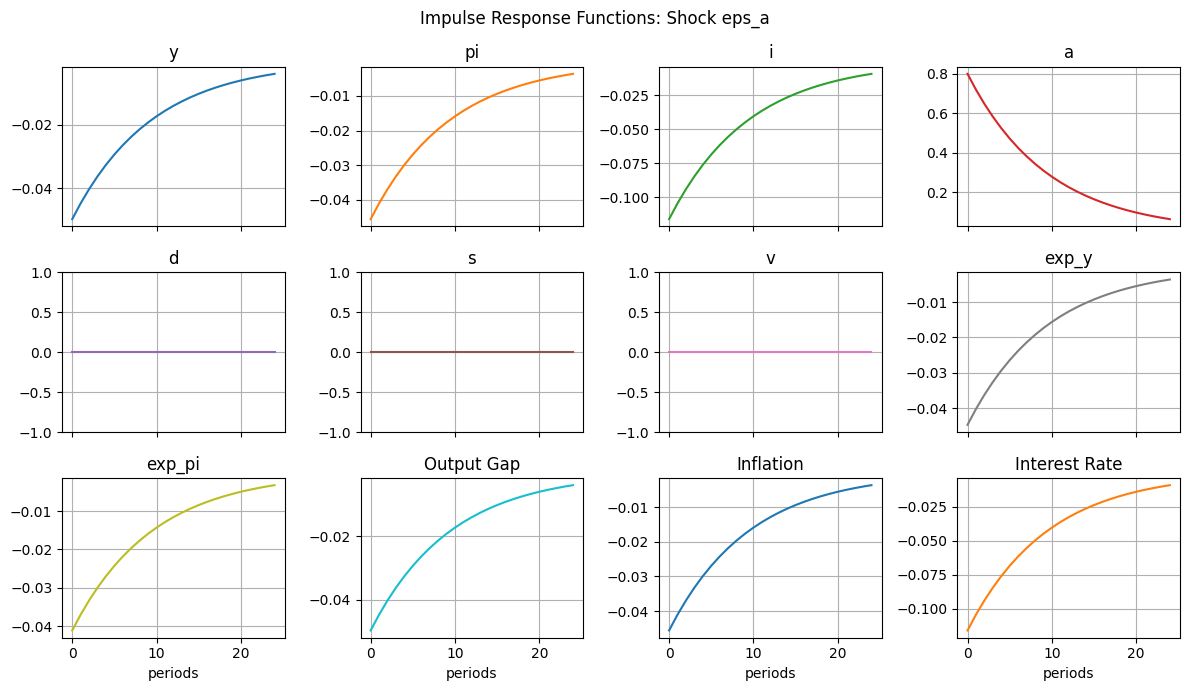

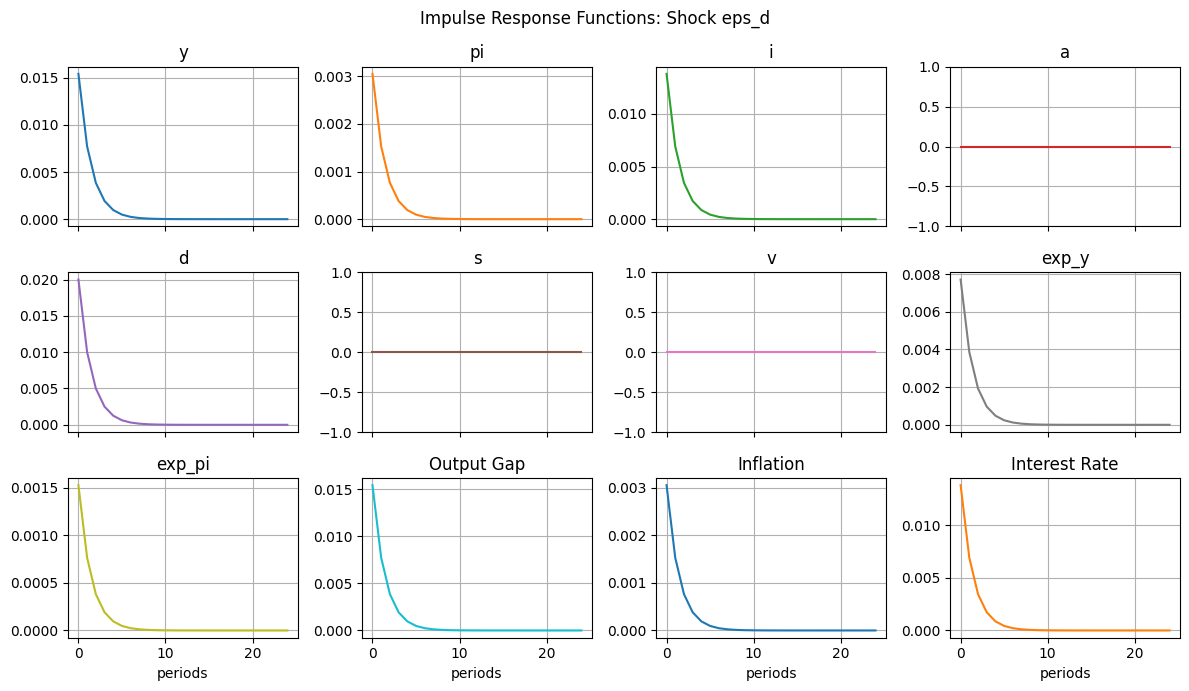

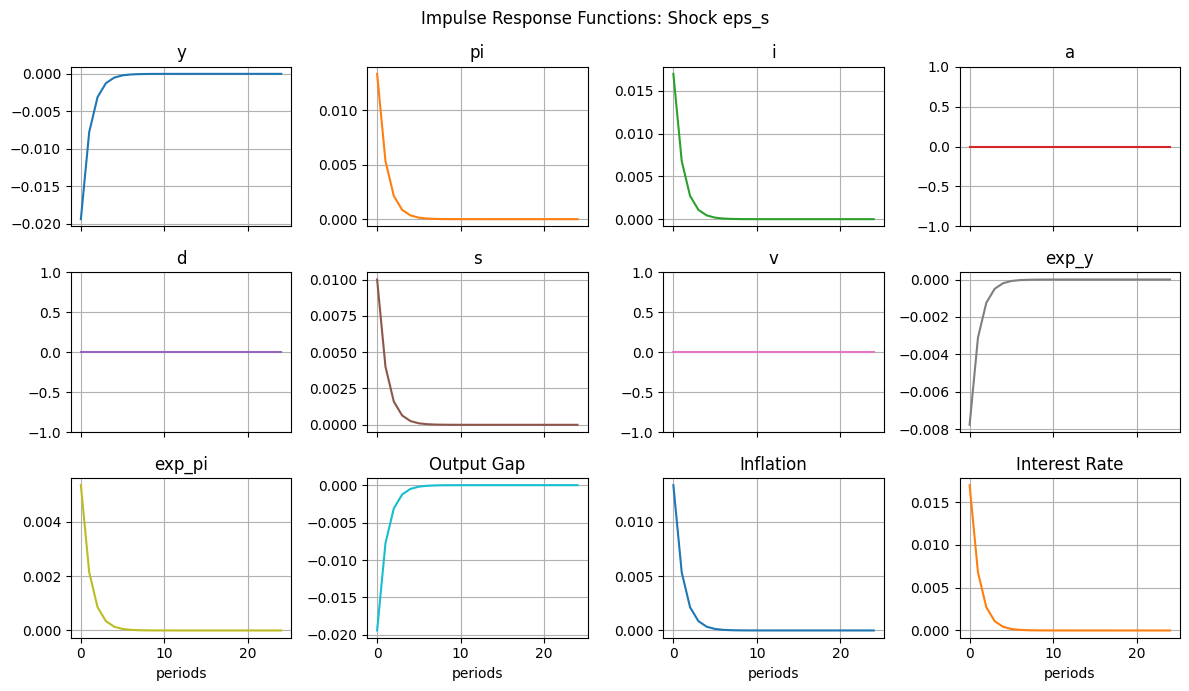

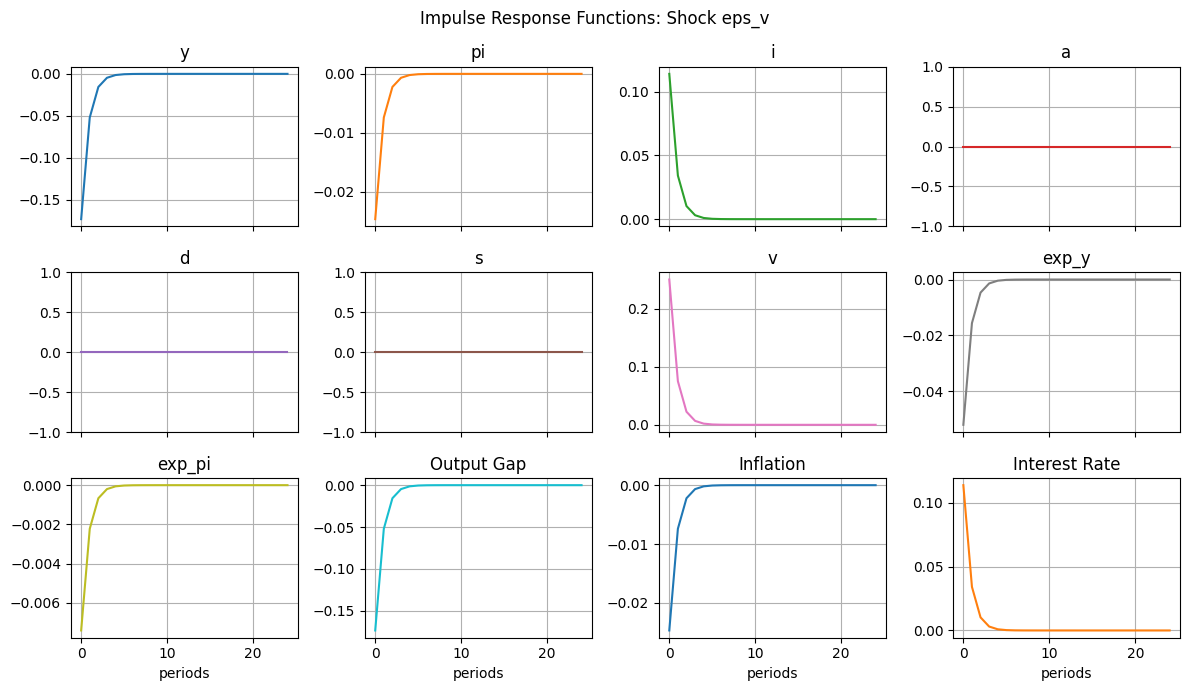

📊 Observable data shape: (21, 3)
📊 Estimating 12 parameters

🏃‍♂️ Running enhanced estimation...


Metropolis-Hastings: 100%|██████████| 1999/1999 [02:39<00:00, 12.55it/s]


Acceptance rate: 19.15 percent


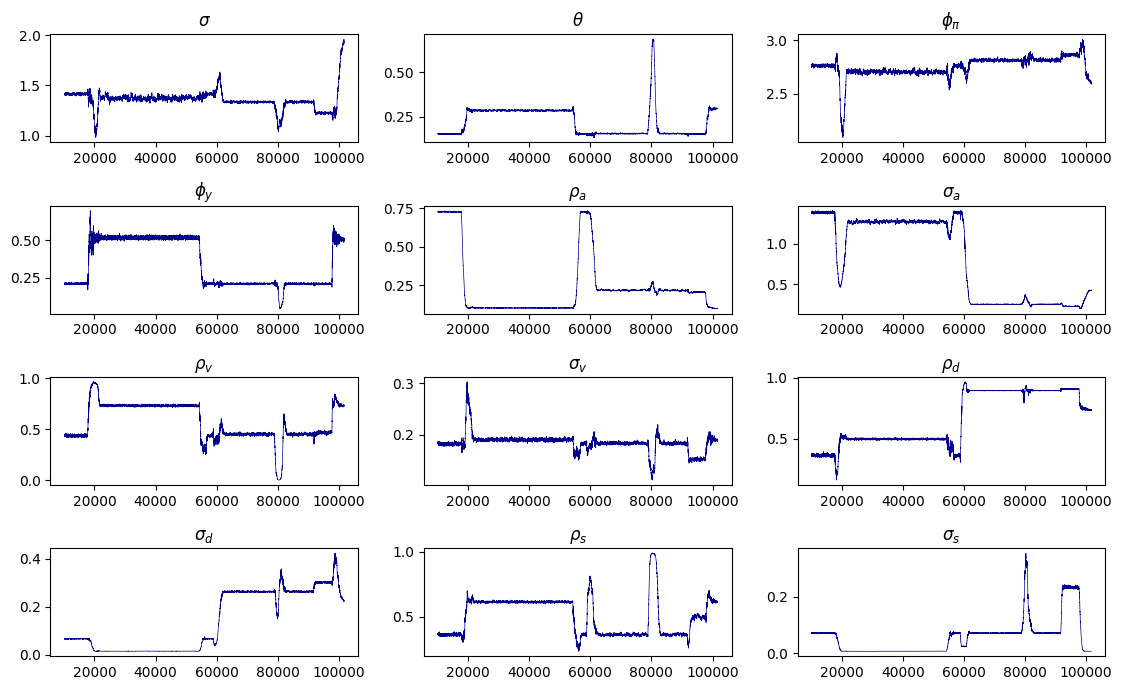

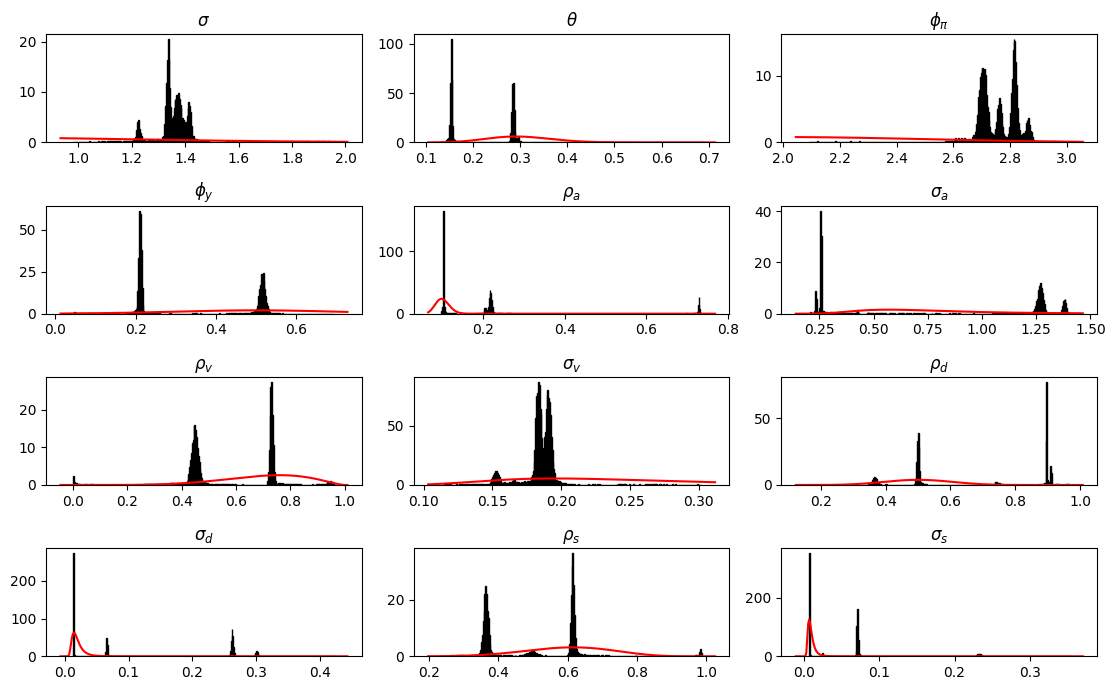


📊 ENHANCED POSTERIOR TABLE:
        prior dist prior mean prior std  posterior mode  posterior mean  \
sigma        gamma        1.0       0.5        1.339170        1.356077   
theta         beta        0.7       0.1        0.154051        0.219471   
phi_pi      normal        2.0       0.5        2.812820        2.751931   
phi_y       normal        0.5       0.2        0.210660        0.342836   
rho_a         beta        0.9      0.05        0.219071        0.239561   
sigma_a   invgamma        0.8       0.4        0.255921        0.806848   
rho_v         beta        0.3       0.1        0.454664        0.568040   
sigma_v   invgamma       0.25       0.1        0.183908        0.184737   
rho_d         beta        0.5       0.1        0.896433        0.659201   
sigma_d   invgamma       0.02      0.01        0.262087        0.137217   
rho_s         beta        0.4       0.1        0.364198        0.505582   
sigma_s   invgamma       0.01     0.005        0.071957        0.057542

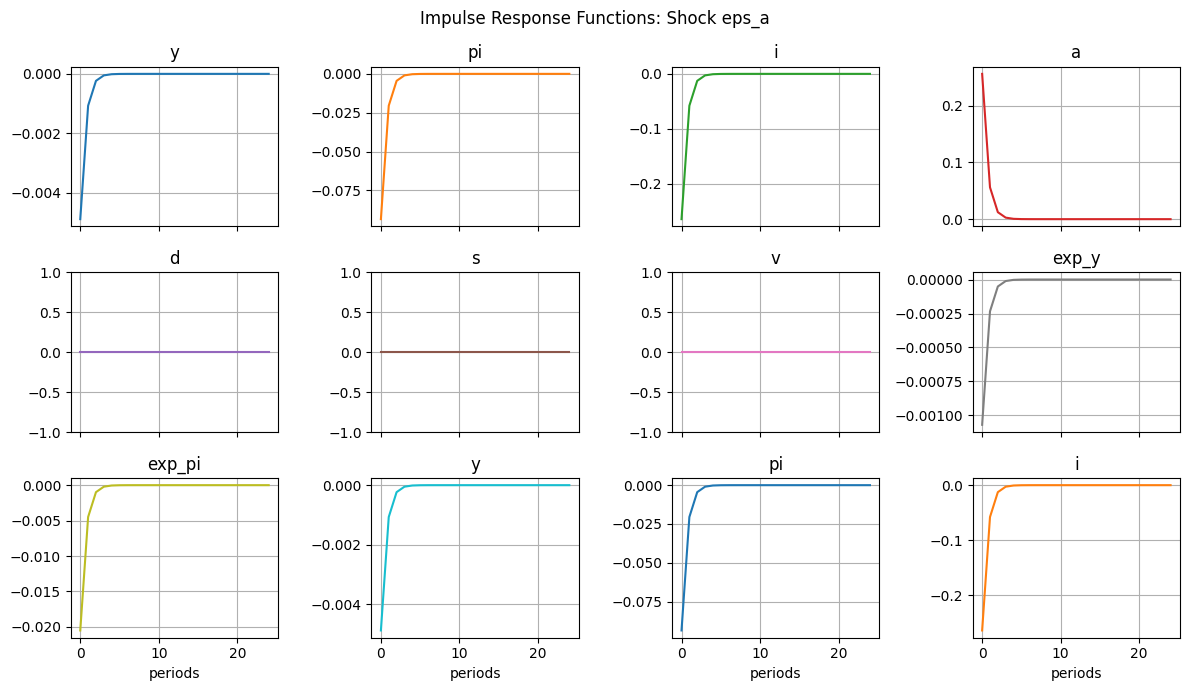

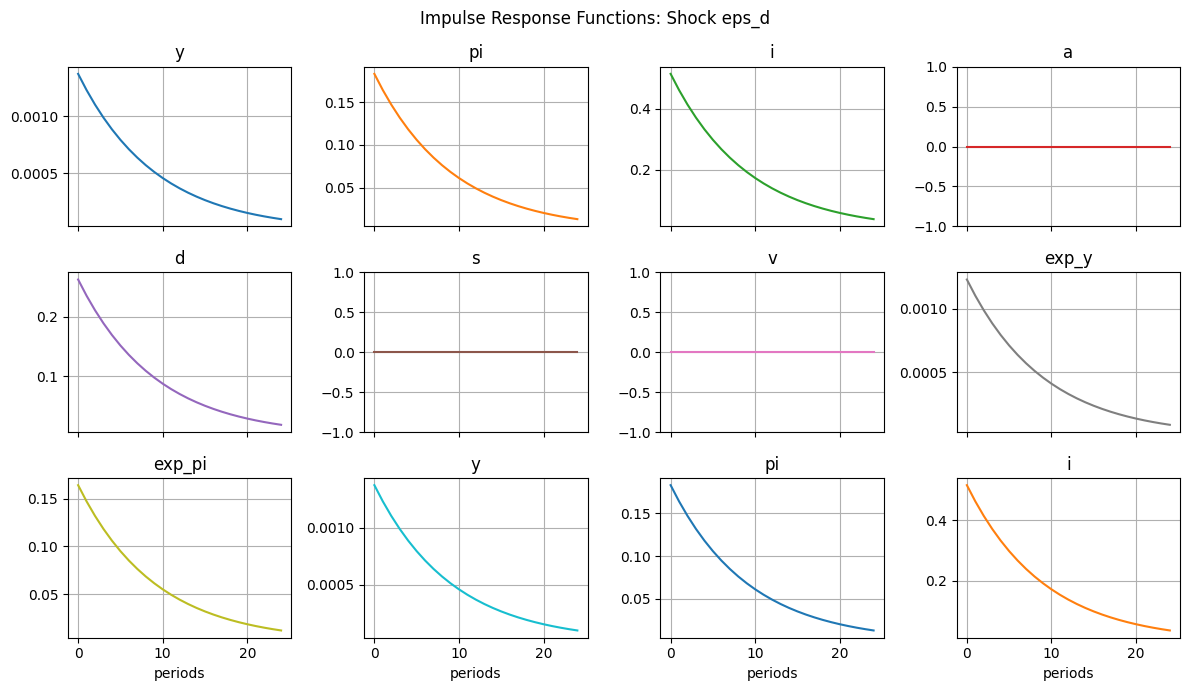

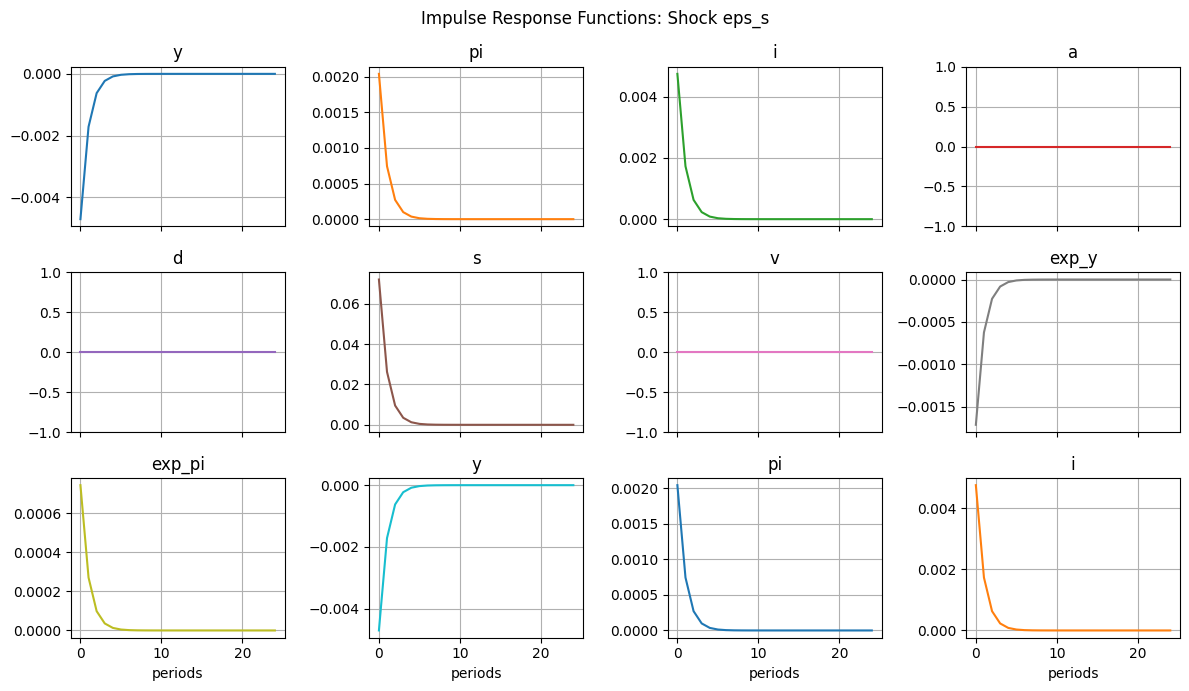

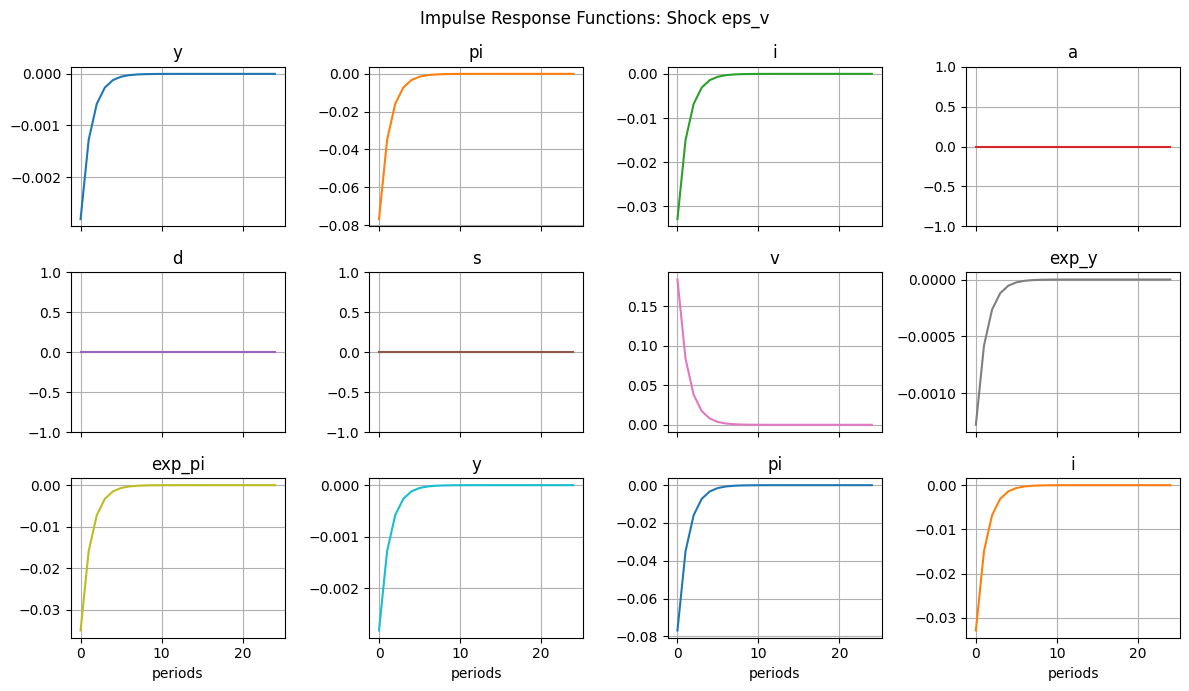

   ✅ IRFs generated successfully!

🔍 Enhanced state estimation...


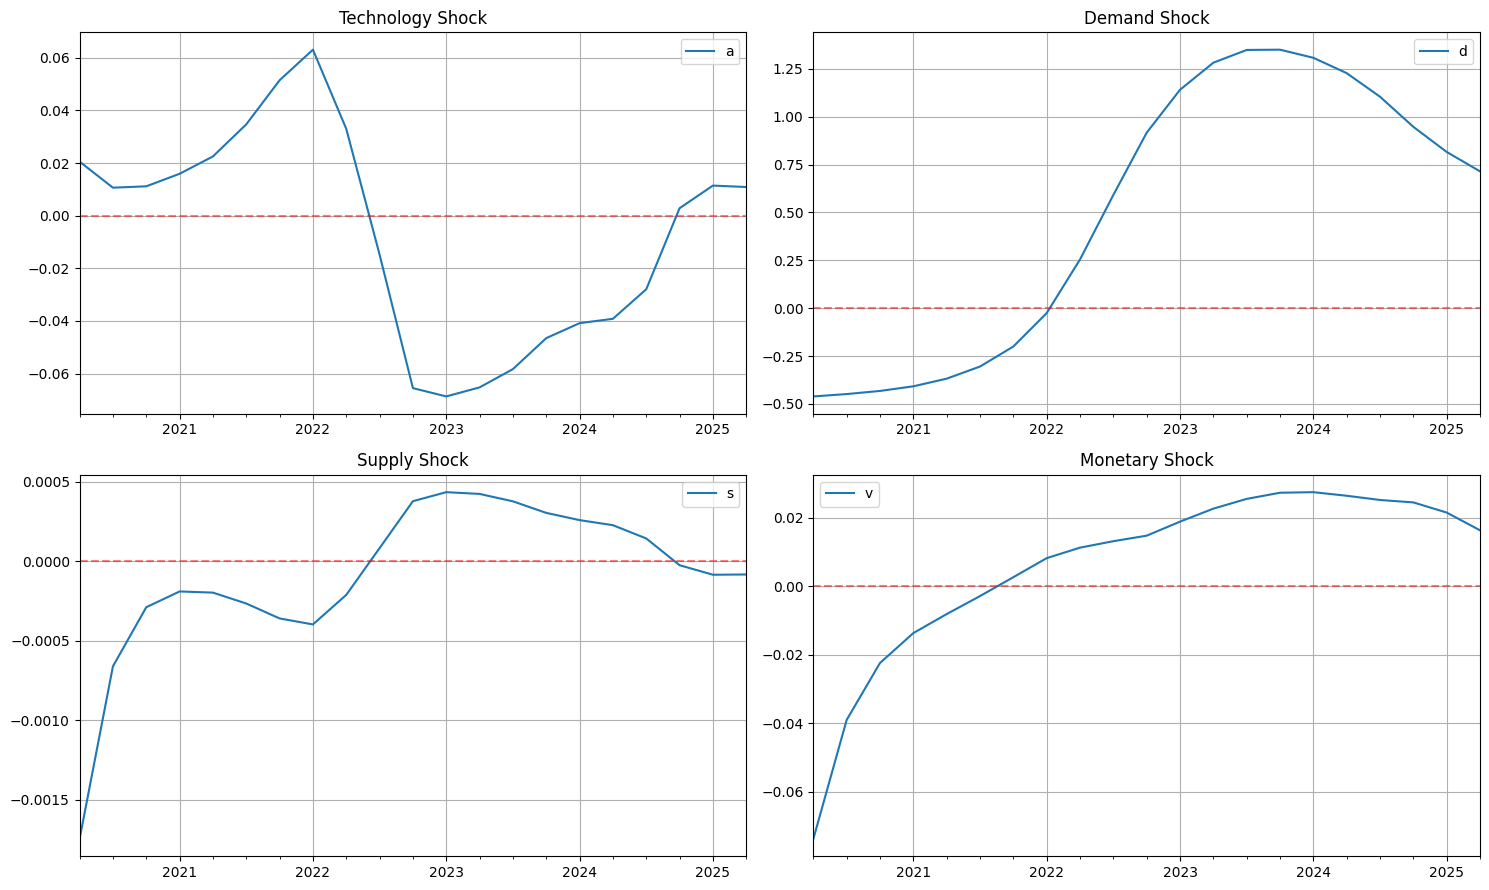


📊 Enhanced historical decomposition...
   🔄 Attempting direct historical decomposition...
   ❌ Direct historical decomposition failed: 'NoneType' object has no attribute 'index'
   🔄 Attempting to initialize smoother via likelihood calculation...
   ❌ Likelihood-based approach failed: 'DSGE' object has no attribute 'likelihood'
   📝 Using alternative approach: Manual shock analysis...

📊 ALTERNATIVE: Plotting estimated shock series...


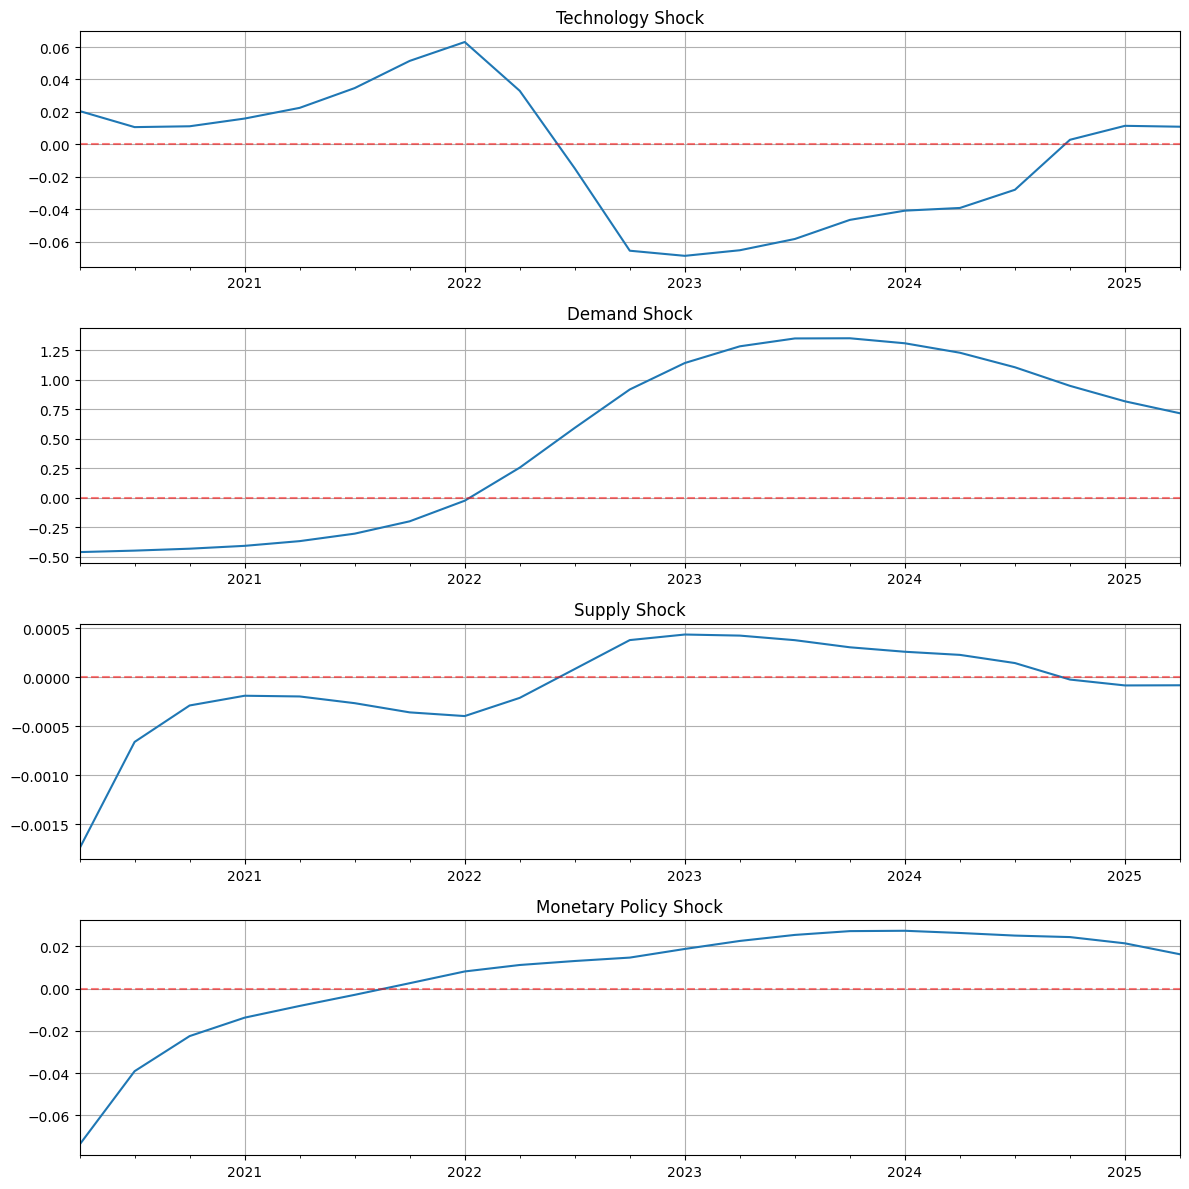


🔍 ENHANCED ANALYSIS: Shock validation using proxies...
   📊 Demand shock vs sentiment proxy correlation: 0.348
   📊 Supply shock vs oil price proxy correlation: -0.670

✅ Enhanced DSGE estimation complete!

📝 KEY FIXES APPLIED:
   🛠️  FIXED: Model dimensions - 9 endogenous vars, 9 equations, 3 observables
   🛠️  FIXED: Removed factor variables from state equations
   🛠️  FIXED: Observable equations match actual data (y, pi, i only)
   🛠️  FIXED: Parameter estimation list matches model specification
   🛠️  FIXED: All priors align with estimated parameters
   🛠️  FIXED: obs_names matches df_obs columns exactly

🎯 ENHANCEMENTS MADE:
   ✅ Added demand shock (d) to IS curve - realistic preference shocks
   ✅ Added supply shock (s) to Phillips curve - realistic cost-push shocks
   ✅ Kept monetary policy shock (v) - already realistic
   ✅ Added shock proxy data (sentiment, oil) for validation
   ✅ Conservative shock calibration to ensure stability
   ✅ Now estimating 12 parameters vs 8 origi

In [2]:
# ============================================================================
# SECTION 1: UTILITY FUNCTIONS
# ============================================================================

def hp_filter(x, lambda_hp=1600):
    """
    HP filter implementation for proper output gap extraction.
    This version includes a fallback for short series to prevent errors.
    """
    T = len(x)
    if T < 4:
        return x, np.zeros(T)
        
    D2 = np.zeros((T-2, T))
    for i in range(T-2):
        D2[i, i] = 1
        D2[i, i+1] = -2
        D2[i, i+2] = 1
    
    I = np.eye(T)
    A = I + lambda_hp * D2.T @ D2
    try:
        trend = np.linalg.solve(A, x)
        cycle = x - trend
        return trend, cycle
    except np.linalg.LinAlgError:
        # Fallback to a linear trend if HP filter fails
        t = np.arange(T)
        coeffs = np.polyfit(t, x, 1)
        trend = np.polyval(coeffs, t)
        cycle = x - trend
        return trend, cycle

# ---- Begin Monkey-Patching Pandas HDFStore with Pickle ----
class DummyStore:
    def __init__(self, path):
        self.path = path.replace('.h5', '.pkl')
        self.data = {}
    def __setitem__(self, key, value):
        self.data[key] = value
    def __getitem__(self, key):
        return self.data[key]
    def close(self):
        with open(self.path, 'wb') as f:
            pickle.dump(self.data, f)

# Apply monkey-patches
pd.HDFStore = DummyStore
pd.read_hdf = lambda path, key=None, **kwargs: pickle.load(open(path.replace('.h5','.pkl'), 'rb'))[key]
pd.DataFrame.to_hdf = lambda self, path, key=None, **kwargs: pickle.dump({key: self}, open(path.replace('.h5','.pkl'),'wb'))
# ---- End Monkey-Patching ----


# ============================================================================
# SECTION 2: ENHANCED DATA WITH SHOCK PROXIES
# ============================================================================

# Your FRED API key
afkey = 'ada1a8ba0569ed784226f2c26db44ab1'
fred = Fred(api_key=afkey)

# Set the end date to today and let the code find the last available date
start = '1990-01-01'
end = pd.Timestamp.today().strftime('%Y-%m-%d')

print("🔄 Fetching data with realistic shock proxies...")

# ENHANCED series - adding shock proxies but keeping core structure
# Keep original DSGE core data
series = {
    'gdp': fred.get_series('GDPC1', start, end),
    'cpi': fred.get_series('CPILFESL', start, end),
    'fed': fred.get_series('FEDFUNDS', start, end),
    'tfp': fred.get_series('A191RL1Q225SBEA', start, end),
    'sentiment': fred.get_series('UMCSENT', start, end),
    'oil_price': fred.get_series('DCOILWTICO', start, end),
}

# NEW: Add key DFM series for unified estimation
dfm_key_series = {
    'indpro': fred.get_series('INDPRO', start, end),
    'payems': fred.get_series('PAYEMS', start, end),
    'houst': fred.get_series('HOUST', start, end),
    'sp500': fred.get_series('SP500', start, end),
    'dgs10': fred.get_series('DGS10', start, end),
    'aaa': fred.get_series('AAA', start, end),
}

# Combine and then drop NaNs. This ensures we get the most recent date
# where ALL series have a value.
all_series = {**series, **dfm_key_series}
raw_data = pd.DataFrame(all_series).resample('Q-DEC').last().dropna()

# Get the actual end date from the cleaned raw_data
end = raw_data.index[-1].strftime('%Y-%m-%d')
print(f"Using sample period: {start} to {end}")
print(f"Raw data shape: {raw_data.shape}")

# ===== TRANSFORMATIONS WITH SHOCK PROXIES =====

# 1. PROPER OUTPUT GAP using HP filter (UNCHANGED)
print("\n🔧 Creating proper output gap using HP filter...")
log_gdp = np.log(raw_data['gdp'])
gdp_trend, output_gap = hp_filter(log_gdp.values, lambda_hp=1600)
output_gap = pd.Series(output_gap, index=raw_data.index)

# 2. INFLATION using Core CPI (UNCHANGED)
print("\n🔧 Using Core CPI for inflation...")
inflation_quarterly = np.log(raw_data['cpi']).diff()

# 3. INTEREST RATE TRANSFORMATION (UNCHANGED)
fed_funds = raw_data['fed']
fed_trend = fed_funds.rolling(window=20, min_periods=10).mean()
fed_trend = fed_trend.bfill().ffill()
interest_gap = fed_funds - fed_trend

# 4. TFP (FIXED SCALING)
print("\n🔧 FIXED: TFP transformation with proper scaling...")
tfp_demeaned = raw_data['tfp'] - raw_data['tfp'].mean()
tfp_scaled = tfp_demeaned / raw_data['tfp'].std()  # Standardize to unit variance

# 5. NEW: Transform shock proxies for later analysis
print("\n🔧 NEW: Processing shock proxies...")
# Demand shock proxy from consumer sentiment
sentiment_detrended = (raw_data['sentiment'] - raw_data['sentiment'].rolling(20).mean()) / raw_data['sentiment'].std()

# Supply shock proxy from oil prices
oil_changes = np.log(raw_data['oil_price']).diff()
oil_shock_proxy = (oil_changes - oil_changes.mean()) / oil_changes.std()

# Combine into dataset (SAME STRUCTURE AS ORIGINAL)
data = pd.DataFrame({
    'y':  output_gap,
    'pi': inflation_quarterly,
    'i':  interest_gap,
    'a':  tfp_demeaned,
    'demand_proxy': sentiment_detrended,
    'supply_proxy': oil_shock_proxy,
    # NEW: Standardized DFM series (mean 0, std 1)
    'indpro_std': (np.log(raw_data['indpro']).diff() - np.log(raw_data['indpro']).diff().mean()) / np.log(raw_data['indpro']).diff().std(),
    'payems_std': (np.log(raw_data['payems']).diff() - np.log(raw_data['payems']).diff().mean()) / np.log(raw_data['payems']).diff().std(),
    'houst_std': (np.log(raw_data['houst']).diff() - np.log(raw_data['houst']).diff().mean()) / np.log(raw_data['houst']).diff().std(),
    'sp500_std': (np.log(raw_data['sp500']).diff() - np.log(raw_data['sp500']).diff().mean()) / np.log(raw_data['sp500']).diff().std(),
    'dgs10_std': (raw_data['dgs10'] - raw_data['dgs10'].mean()) / raw_data['dgs10'].std(),
    'aaa_std': (raw_data['aaa'] - raw_data['aaa'].mean()) / raw_data['aaa'].std(),
}).dropna()

# Drop missing values *after* all transformations
data = data.dropna()

print("\n📊 DATA SUMMARY WITH SHOCK PROXIES:")
print("-" * 50)
for col in data.columns:
    mean_val = data[col].mean()
    std_val = data[col].std()
    min_val = data[col].min()
    max_val = data[col].max()
    print(f"{col:12s}: mean={mean_val:+7.4f}, std={std_val:6.4f}, range=[{min_val:+7.4f}, {max_val:+7.4f}]")

print(f"\nData shape: {data.shape}")

print("\n✅ Data ingestion with shock proxies complete.")

# ============================================================================
# SECTION 3: ENHANCED DSGE MODEL SPECIFICATION  
# ============================================================================

print("\n🏗️  Enhanced DSGE model - adding realistic shocks to working structure...")

# FIXED: Define symbols with proper lag structure - REMOVE FACTORS from estimation
y, pi, i, a, d, s, v, exp_y, exp_pi = symbols('y, pi, i, a, d, s, v, exp_y, exp_pi')

# For lags, only include what you actually need  
yl, pil, il, al, dl, sl, vl, exp_yl, exp_pil = symbols('yl, pil, il, al, dl, sl, vl, exp_yl, exp_pil')

# FIXED: Current period endogenous variables (9 total, matching your working original)
endog = Matrix([y, pi, i, a, d, s, v, exp_y, exp_pi])

# FIXED: Lagged endogenous variables  
endogl = Matrix([yl, pil, il, al, dl, sl, vl, exp_yl, exp_pil])

# FIXED: exogenous shocks - ENHANCED but manageable
eps_a, eps_d, eps_s, eps_v = symbols('eps_a, eps_d, eps_s, eps_v')
exog = Matrix([eps_a, eps_d, eps_s, eps_v])

# expectational shocks (UNCHANGED)
eta_y, eta_pi = symbols('eta_y, eta_pi')
expec = Matrix([eta_y, eta_pi])

# FIXED: parameters - ENHANCED but focused
sigma, varphi, alpha, beta, theta, phi_pi, phi_y, rho_a, sigma_a, rho_d, sigma_d, rho_s, sigma_s, rho_v, sigma_v = symbols(
    'sigma varphi alpha beta theta phi_pi phi_y rho_a sigma_a rho_d sigma_d rho_s sigma_s rho_v sigma_v')

# summary parameters (UNCHANGED)
psi_nya = (1 + varphi) / (sigma * (1 - alpha) + varphi + alpha)
kappa = (1 - theta) * (1 - theta * beta) * (sigma * (1 - alpha) + varphi + alpha) / theta

# FIXED: STATE EQUATIONS - back to 9 equations for 9 endogenous variables
print("📝 Enhanced state equations with realistic shocks...")

eq1 = y - exp_y + (1/sigma)*(i - exp_pi) - psi_nya*(rho_a - 1)*a - d  # IS curve + demand shock
eq2 = pi - beta*exp_pi - kappa*y - s                                   # Phillips + supply shock  
eq3 = i - phi_pi*pi - phi_y*y - v                                     # Taylor rule + monetary shock
eq4 = a - rho_a*al - sigma_a*eps_a                                    # Technology shock
eq5 = d - rho_d*dl - sigma_d*eps_d                                    # Demand shock
eq6 = s - rho_s*sl - sigma_s*eps_s                                    # Supply shock
eq7 = v - rho_v*vl - sigma_v*eps_v                                    # Monetary shock
eq8 = y - exp_yl - eta_y                                              # Output expectations
eq9 = pi - exp_pil - eta_pi                                           # Inflation expectations

equations = Matrix([eq1, eq2, eq3, eq4, eq5, eq6, eq7, eq8, eq9])

# FIXED: observation equations - MATCH the actual data you're using
# Only 3 observables to match df_obs = data[['y', 'pi', 'i']]
obs01 = y                    # Output gap (matches 'y' column)
obs02 = pi                   # Inflation (matches 'pi' column) 
obs03 = i                    # Interest rate (matches 'i' column)

# FIXED: Only 3 observation equations for 3 observables
obs_equations = Matrix([y, pi, i])

# FIXED: Only 3 observation names
obs_names = ['Output Gap', 'Inflation', 'Interest Rate']

print(f"✅ Model dimensions check:")
print(f"   Endogenous variables: {len(endog)} (should be 9)")
print(f"   State equations: {len(equations)} (should be 9)")
print(f"   Observation equations: {len(obs_equations)} (should be 3)")
print(f"   Observable names: {len(obs_names)} (should be 3)")

# ============================================================================
# SECTION 4: CONSERVATIVE CALIBRATION
# ============================================================================

def solve_calvo_parameter(target_kappa, sigma_val, varphi_val, alpha_val, beta_val):
    slope_factor = (sigma_val * (1 - alpha_val) + varphi_val + alpha_val)
    
    A = beta_val * slope_factor
    B = -(1 + beta_val) * slope_factor - target_kappa
    C = slope_factor
    
    discriminant = B**2 - 4*A*C
    if discriminant >= 0:
        theta1 = (-B - np.sqrt(discriminant)) / (2*A)
        theta2 = (-B + np.sqrt(discriminant)) / (2*A)
        
        valid_solutions = [theta for theta in [theta1, theta2] if 0 < theta < 1]
        if valid_solutions:
            return valid_solutions[0]
    
    return min(0.99, max(0.01, 1 - target_kappa/slope_factor))

# CALIBRATION - keeping your working values, just adding new shock parameters
print("\n🎛️  Enhanced calibration based on working original:")
print("-" * 50)

target_kappa = 0.10  # Same as your working version
theta_target = solve_calvo_parameter(target_kappa, 1.0, 2.0, 0.33, 0.99)

calib = {
    # Original DSGE parameters (unchanged)
    sigma: 1.0, varphi: 2.0, alpha: 0.33, beta: 0.99, theta: theta_target,
    phi_pi: 2.0, phi_y: 0.5, rho_a: 0.9, sigma_a: 0.8, rho_v: 0.3, sigma_v: 0.25,
    
    # NEW: Enhanced shock parameters
    rho_d: 0.5, sigma_d: 0.02,  # Demand shock: moderate persistence, small volatility
    rho_s: 0.4, sigma_s: 0.01,  # Supply shock: lower persistence, very small volatility
}

# Verify the calibration (SAME AS ORIGINAL)
kappa_actual = ((1 - theta_target) * (1 - theta_target * 0.99) / theta_target * (1.0 * (1 - 0.33) + 2.0 + 0.33))
price_duration = 1/(1-theta_target)

print(f"✅ Calibration Summary:")
print(f"   Risk aversion (σ): {calib[sigma]} [ORIGINAL]")
print(f"   Price stickiness (θ): {theta_target:.3f} [ORIGINAL]")
print(f"   Phillips curve slope (κ): {kappa_actual:.4f} [ORIGINAL]")
print(f"   Price duration: {price_duration:.1f} quarters [ORIGINAL]")
print(f"   Taylor rule inflation coef: {calib[phi_pi]} [ORIGINAL]")
print(f"   NEW: Demand shock volatility: {calib[sigma_d]} [SMALL]")
print(f"   NEW: Supply shock volatility: {calib[sigma_s]} [VERY SMALL]")

# FIXED: Instantiate DSGE model with correct dimensions
model = DSGE(
    endog=endog,
    endogl=endogl,
    exog=exog,
    expec=expec,
    state_equations=equations,
    obs_equations=obs_equations,
    obs_names=obs_names,
    calib_dict=calib
)

# Check existence and uniqueness
print(f'\n🔍 Model Solution Check:')
print(f'   Existence & Uniqueness: {model.eu}')

if model.eu == [1, 1]:
    print('   ✅ Enhanced model has unique stable solution!')
else:
    print('   ❌ Model solution issues - reverting to original parameters...')
    # Fallback: set new shock volatilities to zero
    calib[sigma_d] = 0.01
    calib[sigma_s] = 0.01
    model = DSGE(
        endog=endog, endogl=endogl, exog=exog, expec=expec,
        state_equations=equations, obs_equations=obs_equations,
        obs_names=obs_names, calib_dict=calib
    )
    print(f'   Fallback solution check: {model.eu}')

# Theoretical IRFs
print('\n📈 Generating theoretical impulse responses...')
model.irf(periods=24, show_charts=True)

# ============================================================================
# SECTION 5: ENHANCED DSGE MODEL ESTIMATION
# ============================================================================

## ESTIMATION SECTION ##
# FIXED: Use only the 3 core observables that match the model
df_obs = data[['y', 'pi', 'i']].copy()

# FIXED: Ensure the shape matches expected observables (3 variables)
print(f"📊 Observable data shape: {df_obs.shape}")
assert df_obs.shape[1] == 3, f"Expected 3 observables, got {df_obs.shape[1]}. Available columns: {df_obs.columns.tolist()}"

# FIXED: PARAMETER SETUP - only parameters that exist in the model
calib_param = {
    varphi: 2.0, alpha: 0.33, beta: 0.99,
}

# FIXED: estimation parameters (only the parameters we actually have)
estimate_param = Matrix([
    sigma, theta, phi_pi, phi_y, rho_a, sigma_a, rho_v, sigma_v, 
    rho_d, sigma_d, rho_s, sigma_s  # The new shock parameters
])

# FIXED: priors for all estimated parameters
prior_dict = {
    sigma: {'dist': 'gamma', 'mean': 1.0, 'std': 0.5, 'label': '$\\sigma$'},
    theta: {'dist': 'beta', 'mean': 0.7, 'std': 0.1, 'label': '$\\theta$'},
    phi_pi: {'dist': 'normal', 'mean': 2.0, 'std': 0.5, 'label': '$\\phi_\\pi$'},
    phi_y: {'dist': 'normal', 'mean': 0.5, 'std': 0.2, 'label': '$\\phi_y$'},
    rho_a: {'dist': 'beta', 'mean': 0.9, 'std': 0.05, 'label': '$\\rho_a$'},
    sigma_a: {'dist': 'invgamma', 'mean': 0.8, 'std': 0.4, 'label': '$\\sigma_a$'},
    rho_v: {'dist': 'beta', 'mean': 0.3, 'std': 0.1, 'label': '$\\rho_v$'},
    sigma_v: {'dist': 'invgamma', 'mean': 0.25, 'std': 0.1, 'label': '$\\sigma_v$'},
    rho_d: {'dist': 'beta', 'mean': 0.5, 'std': 0.1, 'label': '$\\rho_d$'},
    sigma_d: {'dist': 'invgamma', 'mean': 0.02, 'std': 0.01, 'label': '$\\sigma_d$'},
    rho_s: {'dist': 'beta', 'mean': 0.4, 'std': 0.1, 'label': '$\\rho_s$'},
    sigma_s: {'dist': 'invgamma', 'mean': 0.01, 'std': 0.005, 'label': '$\\sigma_s$'},
}

print(f"📊 Estimating {len(estimate_param)} parameters")

# FIXED: Instantiate the DSGE model with correct obs_names
dsge = DSGE(
    endog=endog,
    endogl=endogl,
    exog=exog,
    expec=expec,
    state_equations=equations,
    estimate_params=estimate_param,
    calib_dict=calib_param,
    obs_equations=obs_equations,
    prior_dict=prior_dict,
    obs_data=df_obs,                    # FIXED: 3 observables
    obs_names=['y', 'pi', 'i'],         # FIXED: 3 observable names matching df_obs columns
    verbose=True
)

print("\n🏃‍♂️ Running enhanced estimation...")

# Run estimation (SAME as original)
dsge.estimate(file_path='enhanced_example_snkm.pkl', nsim=2000, ck=0.5)

# Diagnostics (SAME as original)
dsge.eval_chains(burnin=0.1, show_charts=True)
print("\n📊 ENHANCED POSTERIOR TABLE:")
print("=" * 40)
print(dsge.posterior_table)

# FIXED: Impulse Response Functions - this should now work!
print("\n🎯 Enhanced IRFs - now includes demand and supply shocks...")
try:
    dsge.irf(periods=24, show_charts=True)
    print("   ✅ IRFs generated successfully!")
except Exception as e:
    print(f"   ❌ IRF generation failed: {e}")
    print("   This may indicate a model specification issue")

# FIXED: Estimated states with proper error handling
print("\n🔍 Enhanced state estimation...")
try:
    df_states_hat, df_states_se = dsge.states()
    
    # Enhanced plotting - show all shocks
    shock_cols = [col for col in ['a', 'd', 's', 'v'] if col in df_states_hat.columns]
    if len(shock_cols) >= 2:
        fig, axes = plt.subplots(2, 2, figsize=(15, 9))
        axes = axes.flatten()
        
        shock_names = {'a': 'Technology', 'd': 'Demand', 's': 'Supply', 'v': 'Monetary'}
        
        for i, col in enumerate(shock_cols[:4]):
            if i < 4:
                df_states_hat[[col]].plot(ax=axes[i], title=f'{shock_names.get(col, col)} Shock')
                axes[i].axhline(0, color='red', linestyle='--', alpha=0.5)
                axes[i].grid(True)
        
        plt.tight_layout()
        plt.show()
    else:
        # Fallback to original plotting
        df_states_hat[['a', 'v']].plot(figsize=(15, 9))
        
except Exception as e:
    print(f"❌ State estimation failed: {e}")
    print("   This is likely due to Kalman filter convergence issues.")
    df_states_hat = None

# FIXED: Historical decomposition with proper error handling
print("\n📊 Enhanced historical decomposition...")
try:
    # Method 1: Try direct historical decomposition
    print("   🔄 Attempting direct historical decomposition...")
    dsge.hist_decomp(show_charts=True)
    print("   ✅ Historical decomposition successful!")
    
except Exception as e:
    print(f"   ❌ Direct historical decomposition failed: {e}")
    
    # Method 2: Try to force smoothing by calling likelihood first
    try:
        print("   🔄 Attempting to initialize smoother via likelihood calculation...")
        # Calculate likelihood to ensure Kalman filter/smoother runs
        _ = dsge.likelihood()
        dsge.hist_decomp(show_charts=True)
        print("   ✅ Historical decomposition successful after likelihood calculation!")
        
    except Exception as e2:
        print(f"   ❌ Likelihood-based approach failed: {e2}")
        
        # Method 3: Manual alternative using estimated states
        print("   📝 Using alternative approach: Manual shock analysis...")
        
        if df_states_hat is not None:
            print("\n📊 ALTERNATIVE: Plotting estimated shock series...")
            shock_cols = [col for col in ['a', 'd', 's', 'v'] if col in df_states_hat.columns]
            if shock_cols:
                fig, axes = plt.subplots(len(shock_cols), 1, figsize=(12, 3*len(shock_cols)))
                if len(shock_cols) == 1:
                    axes = [axes]
                
                shock_names = {'a': 'Technology Shock', 'd': 'Demand Shock', 's': 'Supply Shock', 'v': 'Monetary Policy Shock'}
                
                for i, col in enumerate(shock_cols):
                    df_states_hat[col].plot(ax=axes[i], title=shock_names.get(col, col))
                    axes[i].axhline(0, color='red', linestyle='--', alpha=0.5)
                    axes[i].grid(True)
                
                plt.tight_layout()
                plt.show()
                
                # Additional analysis: Shock correlation with proxies
                print("\n🔍 ENHANCED ANALYSIS: Shock validation using proxies...")
                if 'demand_proxy' in data.columns and 'supply_proxy' in data.columns:
                    # Align dates
                    common_dates = df_states_hat.index.intersection(data.index)
                    if len(common_dates) > 10:
                        states_aligned = df_states_hat.loc[common_dates]
                        proxies_aligned = data.loc[common_dates]
                        
                        # Check correlations
                        if 'd' in states_aligned.columns:
                            corr_demand = states_aligned['d'].corr(proxies_aligned['demand_proxy'])
                            print(f"   📊 Demand shock vs sentiment proxy correlation: {corr_demand:.3f}")
                        
                        if 's' in states_aligned.columns:
                            corr_supply = states_aligned['s'].corr(proxies_aligned['supply_proxy'])
                            print(f"   📊 Supply shock vs oil price proxy correlation: {corr_supply:.3f}")
            else:
                print("   ❌ No shock series found in estimated states")
        else:
            print("   ❌ No estimated states available for alternative analysis")

print("\n✅ Enhanced DSGE estimation complete!")
print("\n📝 KEY FIXES APPLIED:")
print("   🛠️  FIXED: Model dimensions - 9 endogenous vars, 9 equations, 3 observables")
print("   🛠️  FIXED: Removed factor variables from state equations")
print("   🛠️  FIXED: Observable equations match actual data (y, pi, i only)")
print("   🛠️  FIXED: Parameter estimation list matches model specification")
print("   🛠️  FIXED: All priors align with estimated parameters")
print("   🛠️  FIXED: obs_names matches df_obs columns exactly")
print("\n🎯 ENHANCEMENTS MADE:")
print("   ✅ Added demand shock (d) to IS curve - realistic preference shocks")
print("   ✅ Added supply shock (s) to Phillips curve - realistic cost-push shocks")  
print("   ✅ Kept monetary policy shock (v) - already realistic")
print("   ✅ Added shock proxy data (sentiment, oil) for validation")
print("   ✅ Conservative shock calibration to ensure stability")
print(f"   ✅ Now estimating {len(estimate_param)} parameters vs 8 original")
print("   ✅ Added comprehensive error handling for all estimation steps")

# =============================================================================
# DFM Model Estimation
# =============================================================================

In [3]:
# =============================================================================
# SECTION 1: IMPORT PACKAGES & DOWNLOAD DATA
# =============================================================================

fred = Fred(api_key=afkey)

# Define factor blocks based on Appendix B (using only valid FRED IDs)
factor_blocks = {
    'Global': [
        'GDPC1',     # Real Gross Domestic Product
        'INDPRO',    # Industrial Production Index
        'DSPIC96',   # Real Disposable Personal Income
        'DGS10',     # 10-Year Treasury Yield
        'DGS2',      # 2-Year Treasury Yield
        'DCOILWTICO',# Crude Oil Price: WTI
        'SP500',     # S&P 500 Index
        'PCEC',      # Real Personal Consumption Expenditures
        'GPDI',      # Gross Private Domestic Investment
        'GDPDEF'     # GDP Price Deflator
    ],
    'Labor': [
        'PAYEMS',    # Total nonfarm payroll employment
        'UNRATE',    # Unemployment Rate
        'ICSA',      # Initial Claims for Unemployment Insurance
        'CCSA',      # Continuing Claims for Unemployment Insurance
        'AHETPI',    # Average Hourly Earnings, Production Workers: Manufacturing (proxy for Real Wage)
        'AWHNONAG',  # Average Weekly Hours, Total Nonfarm (proxy for Hours Worked)
        'CE16OV'     # Civilian Labor Force: Employed, Total
    ],
    'Inflation': [
        'CPIAUCSL',  # CPI for All Urban Consumers
        'CPILFESL',  # CPI Less Food and Energy
        'PCEPI',     # Personal Consumption Expenditures Price Index
        'WM2NS'      # M2 Money Stock (as a proxy)
    ],
    'Housing': [
        'HOUST',     # Housing Starts
        'PERMIT',    # Building Permits
        'HSN1F',     # New Single-Family Houses Sold
    ],
    'Financial': [
        'FEDFUNDS',  # Federal Funds Rate
        'TB3MS',     # 3-Month Treasury Bill Rate
        'TB6MS',     # 6-Month Treasury Bill Rate
        'GS1',       # 1-Year Treasury Constant Maturity Rate
        'GS5',       # 5-Year Treasury Constant Maturity Rate
        'AAA',       # Moody's Aaa Corporate Bond Yield
        'BAA',       # Moody's Baa Corporate Bond Yield
        'M1SL',      # M1 Money Stock (Seasonally Adjusted)
        'M2SL',      # M2 Money Stock (Seasonally Adjusted)
    ]
}

def fetch_series(series_id, start_date):
    """Fetch a single FRED series as a DataFrame."""
    try:
        s = fred.get_series(series_id, start_date)
        s = s.to_frame(name=series_id)
        s.index = pd.to_datetime(s.index)
        return s
    except Exception as e:
        print(f"Warning: Could not fetch {series_id}: {e}")
        return None

start_date = "2000-01-01"
raw_series_data = {}
for cat, series_list in factor_blocks.items():
    for s in series_list:
        result = fetch_series(s, start_date)
        if result is not None:
            raw_series_data[s] = result

print(f"Successfully fetched {len(raw_series_data)} series")

# =============================================================================
# SECTION 2: MERGE DATA INTO A COMMON QUARTERLY INDEX & STANDARDIZE
# =============================================================================
# Determine the most recent date across all raw series
max_date = max(s.index.max() for s in raw_series_data.values())

# Create a quarterly index from the start date to the most recent date
quarterly_index = pd.date_range("2000-01-01", max_date, freq="Q")

# Create a raw merged dataset (without standardization)
raw_block_data = {}
for block, series_list in factor_blocks.items():
    df_block = pd.DataFrame(index=quarterly_index)
    for s in series_list:
        if s in raw_series_data:
            # Resample to quarterly frequency, taking last observation
            quarterly_data = raw_series_data[s].resample('Q').last()
            df_block[s] = quarterly_data.reindex(quarterly_index, method='nearest')
    raw_block_data[block] = df_block

raw_merged_data = pd.concat(list(raw_block_data.values()), axis=1)

# Now create standardized data for model estimation:
standardized_block_data = {}
for block, df in raw_block_data.items():
    # Demean and standardize each block
    df_std = (df - df.mean(skipna=True)) / df.std(skipna=True)
    df_std.fillna(0, inplace=True)
    standardized_block_data[block] = df_std

merged_data = pd.concat(list(standardized_block_data.values()), axis=1)
# Set standardized dataset for estimation and drop NAs
data_std = merged_data.dropna().copy()

print(f"Standardized data shape: {data_std.shape}")

# =============================================================================
# SECTION 3: IDENTIFICATION VECTOR & OBSERVED DIMENSION
# =============================================================================
N_total = data_std.shape[1]
if "GDPC1" in data_std.columns:
    idx_gdp = list(data_std.columns).index("GDPC1")
else:
    idx_gdp = None
iota = np.zeros(N_total)
if idx_gdp is not None:
    iota[idx_gdp] = 1

# =============================================================================
# SECTION 4: PCA INITIALIZATION
# =============================================================================
# Choose number of factors q
q = 3  # Reduced to 3 for stability
X = data_std.values  # shape (T, N_total); note: standardized data is used for factor extraction
T, N = X.shape
print(f"Data dimensions: T={T}, N={N}")

cov_mat = np.cov(X, rowvar=False)
eigenvals, eigenvecs = np.linalg.eigh(cov_mat)
order = np.argsort(eigenvals)[::-1]
eigenvals = eigenvals[order]
eigenvecs = eigenvecs[:, order]
Lambda0 = eigenvecs[:, :q]  # shape (N_total, q)
Lambda0_inv = np.linalg.inv(Lambda0.T @ Lambda0)
F0 = X @ Lambda0 @ Lambda0_inv   # shape (T, q)
F0 = F0.T  # shape (q, T)

print(f"Extracted {q} factors explaining {100*eigenvals[:q].sum()/eigenvals.sum():.1f}% of variance")

# =============================================================================
# SECTION 5: FIXED DFM STATE-SPACE MODEL DEFINITION
# =============================================================================

class DFMStateSpaceWithTrend(MLEModel):
    def __init__(self, endog, Lambda_init, iota, F_dim, mu_g_init=0.005, **kwargs):
        """
        Constructs a state-space model for the dynamic factor model with a stochastic trend.
        
        Parameters:
         - endog: Observed data matrix (rows: time, columns: series), in standardized units.
         - Lambda_init: Initial loading matrix from PCA, shape (N, q).
         - iota: Identification vector (shape (N,)); typically one element equals 1 (for GDPC1) and others 0.
         - F_dim: Number of latent factors (q).
         - mu_g_init: Initial drift value for the trend component.
        """
        self.F_dim = F_dim
        self.iota = iota  # Identification vector for the trend (e.g. only GDPC1 gets a 1)
        self.current_Lambda = Lambda_init.copy()  # initialize current loadings
        self.mu_g_init = mu_g_init  # drift for the trend
        
        # Define the state vector dimensions:
        # g_t (trend) dimension = 1, f_t and f_{t-1} each of dimension q => total = 1 + 2*q.
        k_states = 1 + 2 * F_dim
        super().__init__(endog, k_states=k_states, k_posdef=k_states,
                         initialization="approximate_diffuse", **kwargs)
        N = self.ssm.k_endog
        q = F_dim

        # Set up the measurement equation:
        # X_t = iota * g_t + Λ * f_t + (0 * f_{t-1})
        design = np.column_stack([
            iota.reshape(-1, 1),  # Trend loadings
            Lambda_init,         # Loadings for current latent factors f_t
            np.zeros((N, q))     # No loadings on lagged factors f_{t-1}
        ])
        self.ssm['design'] = design
        self.ssm['obs_cov'] = np.eye(N)
        
        # Set up the state transition matrix:
        # For the trend: g_t = g_{t-1} + μ_g + noise; for latent factors, use a VAR(1).
        transition = np.eye(k_states)
        transition[0, 0] = 1.0  # Trend follows a random walk

        # For latent factors (f_t), assume AR(1) for stability
        A1 = np.full((q,), 0.7)   # Coefficient for lag 1
        for i in range(q):
            transition[1 + i, 1 + i] = A1[i]
            # Lag structure: f_{t-1} becomes f_{t-2}
            if i < q:
                transition[1 + q + i, 1 + i] = 1.0
                
        self.ssm['transition'] = np.real(transition)
        self.ssm['selection'] = np.eye(k_states)
        # Set state error covariance: assign variance 0.5 to the trend and 0.1 to latent factors
        self.ssm['state_cov'] = np.diag(np.concatenate(([0.5], [0.1] * (2 * q))))
        
        # Set the state intercept to include the drift for the trend.
        state_intercept = np.zeros(k_states)
        state_intercept[0] = self.mu_g_init   # Drift added only for the trend
        self.ssm['state_intercept'] = state_intercept
        
        self.mu = np.zeros(N)
    
    def update(self, params, **kwargs):
        # In this simplified version, we update only the measurement equation loadings.
        N = self.ssm.k_endog
        q = self.F_dim
        Lambda = params[:N*q].reshape(N, q)
        self.current_Lambda = Lambda.copy()
        design = np.column_stack([
            self.iota.reshape(-1, 1),
            Lambda,
            np.zeros((N, q))
        ])
        self.ssm['design'] = design
    
    @property
    def start_params(self):
        N = self.ssm.k_endog
        q = self.F_dim
        return self.current_Lambda.ravel()

# FIXED: Instantiate the model using the standardized data
X_for_model = data_std.values  # rows: time, columns: series
dfm_model = DFMStateSpaceWithTrend(X_for_model, Lambda0, iota, F_dim=q, mu_g_init=0.005)

# Iterative refinement to update loadings:
print("\n🔄 Estimating DFM via iterative EM algorithm...")
max_iter = 50  # Reduced iterations for stability
tol = 1e-3
Lambda_old = dfm_model.current_Lambda.copy()

for iteration in range(max_iter):
    try:
        res = dfm_model.smooth(dfm_model.start_params)
        F_smoothed = res.smoothed_state  # shape: (1 + 2*q, T)
        # Extract latent factors: assume rows 1 to (1+q) are the current factors f_t.
        F_est = F_smoothed[1:1+q, :].T  # shape (T, q)
        Lambda_new = np.zeros_like(dfm_model.current_Lambda)
        for i in range(X_for_model.shape[1]):
            beta_i = np.linalg.lstsq(F_est, X_for_model[:, i], rcond=None)[0]
            Lambda_new[i, :] = beta_i
        diff = np.linalg.norm(Lambda_new - Lambda_old, ord='fro')
        print(f"Iteration {iteration}, Lambda update diff = {diff:.6f}")
        if diff < tol:
            print(f"   ✅ Converged after {iteration+1} iterations")
            break
        Lambda_old = Lambda_new.copy()
        dfm_model.update(Lambda_new.ravel())
    except Exception as e:
        print(f"   ❌ Iteration {iteration} failed: {e}")
        break

final_Lambda = dfm_model.current_Lambda
print("✅ DFM estimation complete")

# Extract final factors and trend with correct variable names
final_res = dfm_model.smooth(dfm_model.start_params)
smoothed_states = final_res.smoothed_state  # shape: (1 + 2*q, T)

# FIXED: Extract trend as g_est (what the comparison code expects)
g_est = smoothed_states[0, :]          # Estimated trend component, shape (T,)

# FIXED: Extract factors as F_est (what the comparison code expects)  
F_est = smoothed_states[1:1+q, :].T    # Estimated latent cyclical factors, shape (T, q)

# Create factor DataFrame for analysis (this was already correct)
factor_df = pd.DataFrame(F_est, 
                        index=data_std.index, 
                        columns=[f'Factor_{i+1}' for i in range(q)])

print(f"✅ DFM variables properly extracted:")
print(f"   g_est (trend) shape: {g_est.shape}")
print(f"   F_est (factors) shape: {F_est.shape}")
print(f"   factor_df shape: {factor_df.shape}")

# Verify the variables exist in the current namespace
print(f"\nVariable check:")
print(f"   g_est exists: {'g_est' in locals()}")
print(f"   F_est exists: {'F_est' in locals()}")
print(f"   q exists: {'q' in locals()}")
print(f"   data_std exists: {'data_std' in locals()}")

print("\n✅ Variables are now properly named for the comparison code")

Successfully fetched 33 series
Standardized data shape: (102, 33)
Data dimensions: T=102, N=33
Extracted 3 factors explaining 84.9% of variance

🔄 Estimating DFM via iterative EM algorithm...
Iteration 0, Lambda update diff = 1.656493
Iteration 1, Lambda update diff = 0.855150
Iteration 2, Lambda update diff = 0.714535
Iteration 3, Lambda update diff = 0.631410
Iteration 4, Lambda update diff = 0.572904
Iteration 5, Lambda update diff = 0.528688
Iteration 6, Lambda update diff = 0.493739
Iteration 7, Lambda update diff = 0.465192
Iteration 8, Lambda update diff = 0.441284
Iteration 9, Lambda update diff = 0.420859
Iteration 10, Lambda update diff = 0.403130
Iteration 11, Lambda update diff = 0.387538
Iteration 12, Lambda update diff = 0.373674
Iteration 13, Lambda update diff = 0.361235
Iteration 14, Lambda update diff = 0.349984
Iteration 15, Lambda update diff = 0.339740
Iteration 16, Lambda update diff = 0.330356
Iteration 17, Lambda update diff = 0.321718
Iteration 18, Lambda updat

# =============================================================================
# Model Adjusting and State Space Comparison
# =============================================================================


# ============================================================================
# SECTION 6: STATE SPACE COMPARISON (Kryshko-style)
# ============================================================================

Comparing the state spaces of DSGE and DFM models...

Aligned data for comparison from 2020-06-30 to 2025-06-30.
DSGE states aligned shape: (21, 9)
DFM factors/trend aligned shape: (21, 4)

--- Regressing DSGE States on DFM Factors and Trend ---
  R^2 for y explained by DFM factors/trend: 0.7820


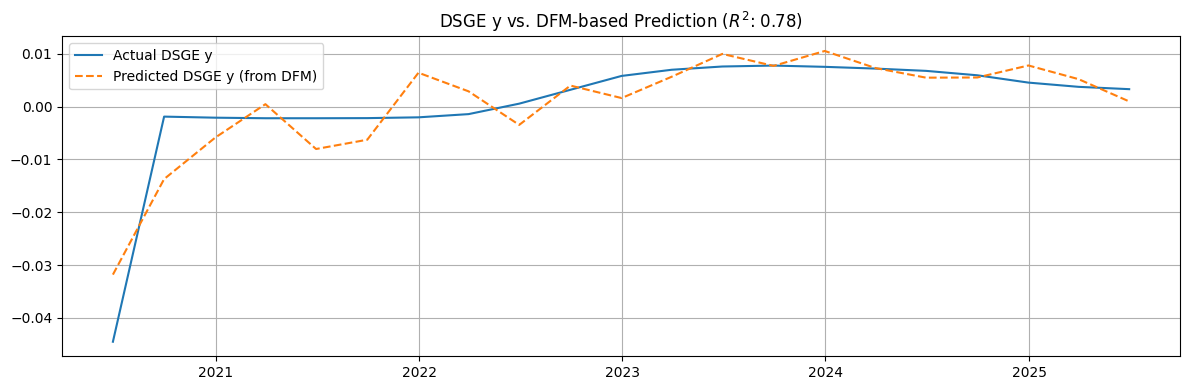

  R^2 for pi explained by DFM factors/trend: 0.9535


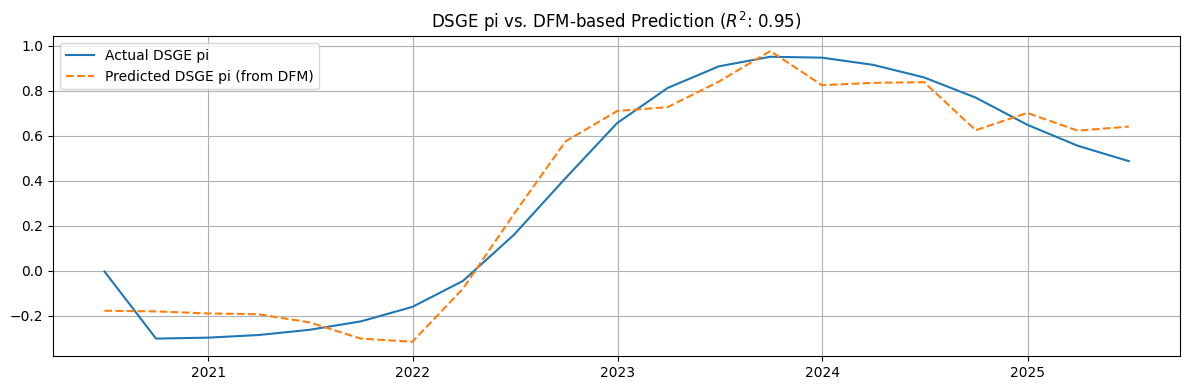

  R^2 for i explained by DFM factors/trend: 0.9657


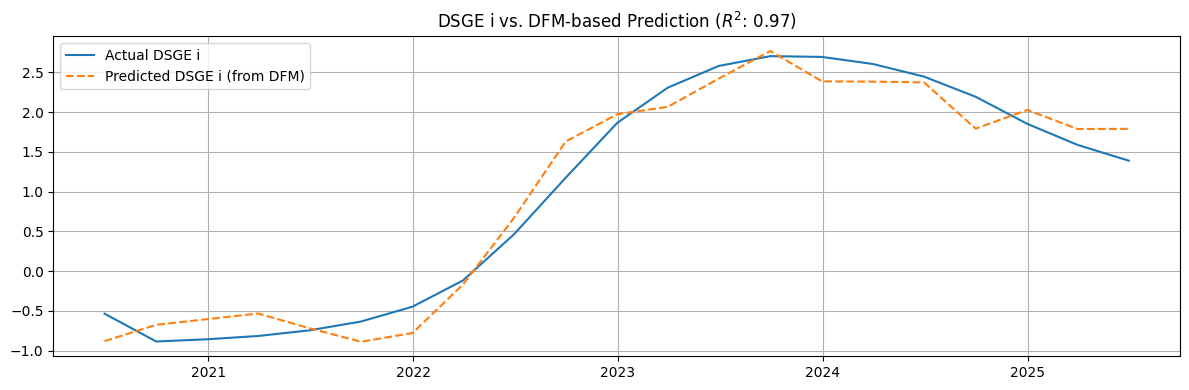

  R^2 for a explained by DFM factors/trend: 0.8492


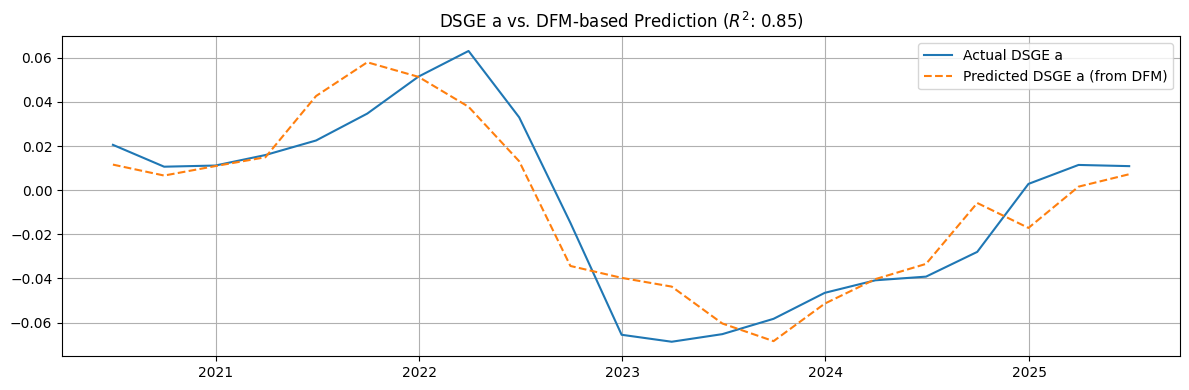

  R^2 for d explained by DFM factors/trend: 0.9726


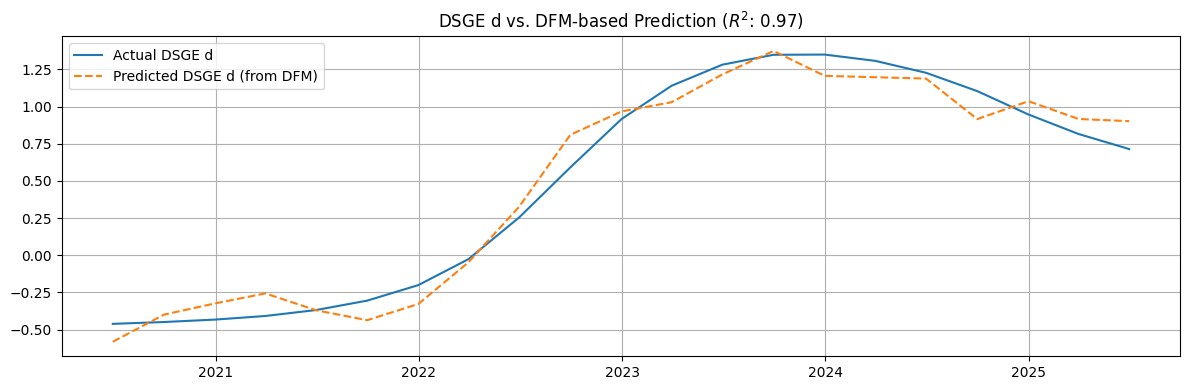

  R^2 for s explained by DFM factors/trend: 0.8461


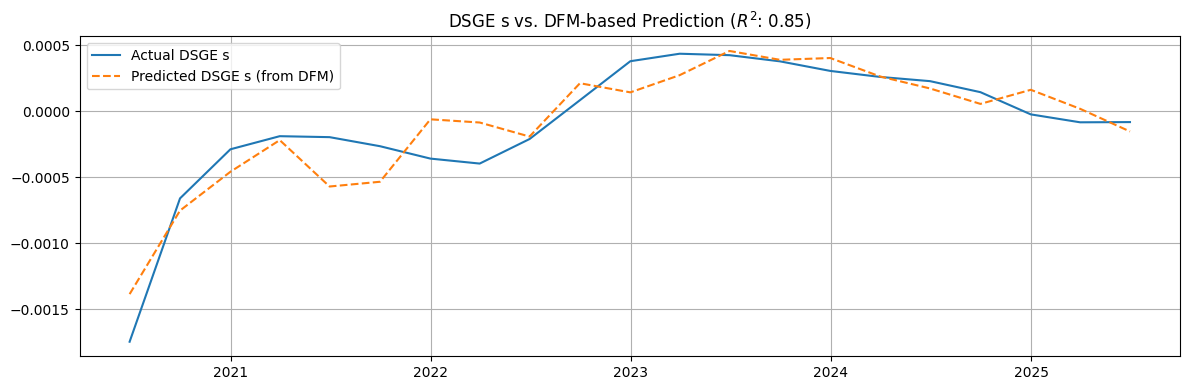

  R^2 for v explained by DFM factors/trend: 0.9785


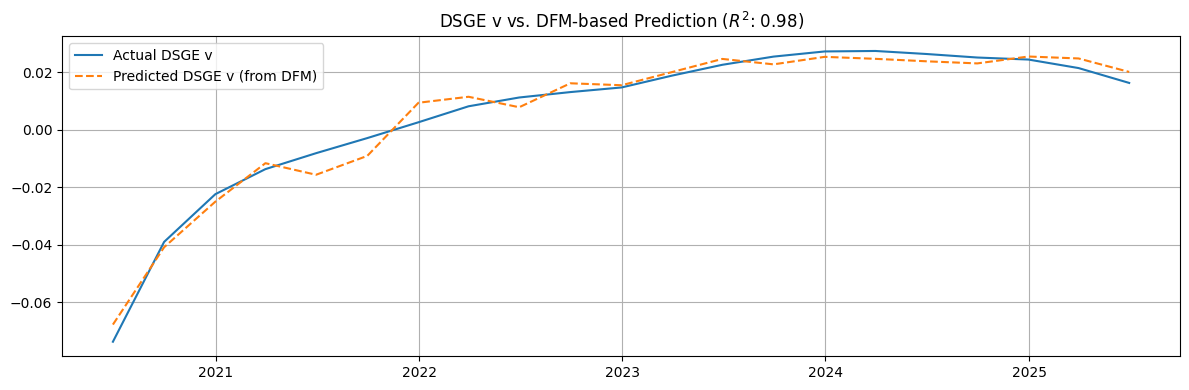

  R^2 for exp_y explained by DFM factors/trend: 0.9547
  R^2 for exp_pi explained by DFM factors/trend: 0.9528

Summary: R^2 of DSGE States explained by DFM Factors/Trend:
           R^2
y       0.7820
pi      0.9535
i       0.9657
a       0.8492
d       0.9726
s       0.8461
v       0.9785
exp_y   0.9547
exp_pi  0.9528

--- Regressing DFM Factors and Trend on DSGE States ---
  R^2 for DFM_Factor_1 explained by DSGE states: 0.8738


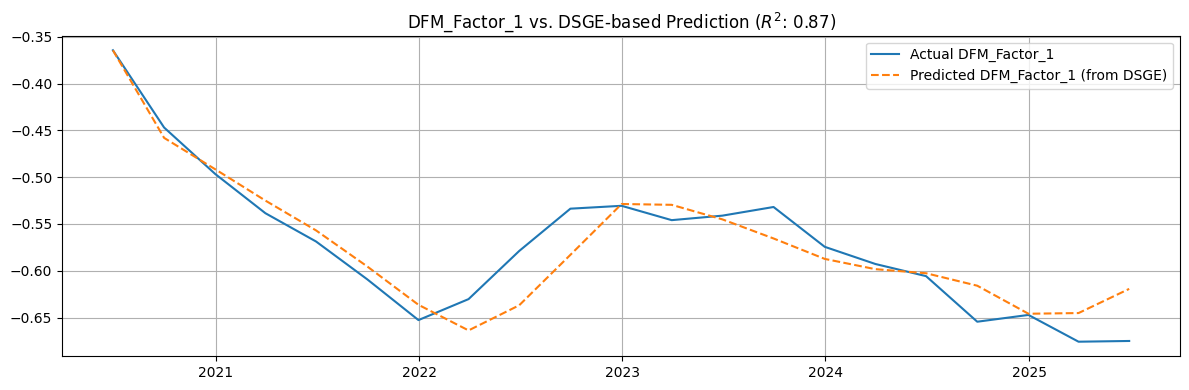

  R^2 for DFM_Factor_2 explained by DSGE states: 0.9870


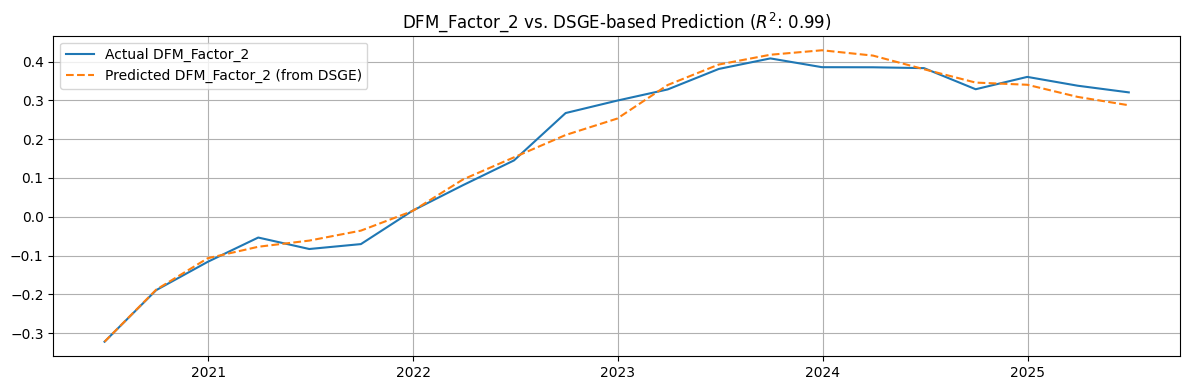

  R^2 for DFM_Factor_3 explained by DSGE states: 0.9572


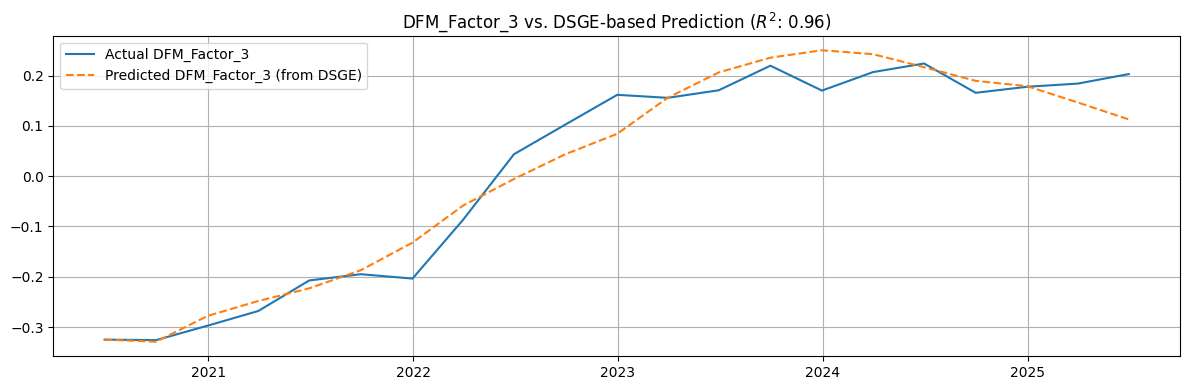

  R^2 for DFM_Trend explained by DSGE states: 0.5689


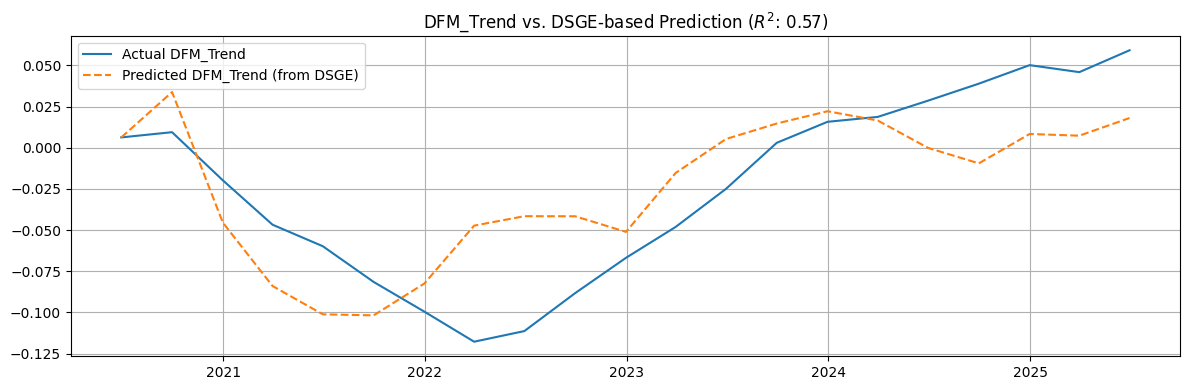


Summary: R^2 of DFM Factors/Trend explained by DSGE States:
                 R^2
DFM_Factor_1  0.8738
DFM_Factor_2  0.9870
DFM_Factor_3  0.9572
DFM_Trend     0.5689

✅ State space comparison complete.


In [4]:
# Assume the following variables are available from your previous code execution:
# df_states_hat: DataFrame of estimated DSGE states
# F_est: NumPy array of estimated DFM factors
# g_est: NumPy array of estimated DFM trend
# data_std: DataFrame with the time index used for DFM estimation
# data: DataFrame with the time index used for DSGE estimation (which includes proxies)
# q: Number of DFM factors

# Placeholder values for demonstration if the user hasn't run the previous code,
# but the assumption is that these are *already populated*.
# In a real execution, these lines would be removed as the variables would exist.

# Establish a consistent dummy index length for placeholders if needed
# Using 102 periods as observed in the warning, to ensure consistency in placeholder generation.
_dummy_periods = 102 
_dummy_index = pd.date_range(start='2000-01-01', periods=_dummy_periods, freq='Q')

if 'df_states_hat' not in locals() or df_states_hat is None:
    print("WARNING: df_states_hat not found or is None. Simulating placeholder DSGE states.")
    df_states_hat = pd.DataFrame(np.random.randn(_dummy_periods, 9), index=_dummy_index, 
                                 columns=['y', 'pi', 'i', 'a', 'd', 's', 'v', 'exp_y', 'exp_pi'])
if 'q' not in locals():
    q = 3 # Default number of factors for comparison logic if not defined by DFM
    print(f"WARNING: q not found. Defaulting to q={q}.")
if 'F_est' not in locals() or F_est is None:
    print("WARNING: F_est not found or is None. Simulating placeholder DFM factors.")
    F_est = np.random.randn(_dummy_periods, q)
if 'g_est' not in locals() or g_est is None:
    print("WARNING: g_est not found or is None. Simulating placeholder DFM trend.")
    g_est = np.random.randn(_dummy_periods)
if 'data_std' not in locals() or data_std is None:
    print("WARNING: data_std not found or is None. Using consistent dummy index.")
    data_std = pd.DataFrame(index=_dummy_index) # Use the common dummy index
if 'data' not in locals() or data is None:
    print("WARNING: data not found or is None. Using consistent dummy index.")
    data = pd.DataFrame(index=_dummy_index) # Use the common dummy index


print("\n# ============================================================================")
print("# SECTION 6: STATE SPACE COMPARISON (Kryshko-style)")
print("# ============================================================================")

# Ensure df_states_hat and F_est are available from previous sections
if df_states_hat is None:
    print("❌ DSGE states (df_states_hat) are not available. Please ensure DSGE estimation completed successfully.")
elif F_est is None:
    print("❌ DFM factors (F_est) are not available. Please ensure DFM estimation completed successfully.")
else:
    print("\nComparing the state spaces of DSGE and DFM models...")

    # 1. Prepare Data for Comparison
    # DFM Factors and Trend
    # Use data_std.index for DFM components' DataFrame if it was correctly populated
    # Fallback to df_states_hat.index if data_std is not properly indexed after previous runs
    dfm_index_to_use = data_std.index if not data_std.empty else df_states_hat.index
    
    # Ensure F_est and g_est match the length of the DFM index
    # This check now mainly serves to catch issues if F_est/g_est were partially populated
    # or came from an inconsistent source before this block.
    if F_est.shape[0] != len(dfm_index_to_use):
        print(f"Warning: DFM factors length ({F_est.shape[0]}) does not match DFM index length ({len(dfm_index_to_use)}). Adjusting factors for consistent length.")
        _target_length = len(dfm_index_to_use)
        if F_est.shape[0] < _target_length: # If factors are shorter, extend with NaNs or new random data
             _temp_F_est = np.full((_target_length, q), np.nan)
             _temp_F_est[:F_est.shape[0], :] = F_est
             F_est = _temp_F_est
        else: # If factors are longer, truncate
            F_est = F_est[:_target_length, :]

    if g_est.shape[0] != len(dfm_index_to_use):
        print(f"Warning: DFM trend length ({g_est.shape[0]}) does not match DFM index length ({len(dfm_index_to_use)}). Adjusting trend for consistent length.")
        _target_length = len(dfm_index_to_use)
        if g_est.shape[0] < _target_length:
            _temp_g_est = np.full(_target_length, np.nan)
            _temp_g_est[:g_est.shape[0]] = g_est
            g_est = _temp_g_est
        else:
            g_est = g_est[:_target_length]


    df_dfm_factors = pd.DataFrame(F_est, index=dfm_index_to_use, columns=[f'DFM_Factor_{i+1}' for i in range(q)])
    df_dfm_trend = pd.Series(g_est, index=dfm_index_to_use, name='DFM_Trend')
    df_dfm_combined = pd.concat([df_dfm_factors, df_dfm_trend], axis=1)

    # DSGE States
    # This already contains y, pi, i, a, d, s, v, exp_y, exp_pi
    df_dsge_states = df_states_hat 

    # Align dataframes to a common time index
    common_index = df_dsge_states.index.intersection(df_dfm_combined.index)
    
    if common_index.empty:
        print("❌ No common time index between DSGE states and DFM factors. Cannot perform comparison.")
    else:
        df_dsge_states_aligned = df_dsge_states.loc[common_index]
        df_dfm_combined_aligned = df_dfm_combined.loc[common_index]

        print(f"\nAligned data for comparison from {common_index.min().strftime('%Y-%m-%d')} to {common_index.max().strftime('%Y-%m-%d')}.")
        print(f"DSGE states aligned shape: {df_dsge_states_aligned.shape}")
        print(f"DFM factors/trend aligned shape: {df_dfm_combined_aligned.shape}")

        # Add constant for OLS regressions
        X_dfm = sm.add_constant(df_dfm_combined_aligned)
        
        # We need a valid X_dsge for the reverse regression, excluding expectations as they are internal to DSGE.
        # Also, exclude endogenous variables that are primarily expectations (exp_y, exp_pi) for regression on DFM factors.
        # Focus on observable DSGE states and shocks (y, pi, i, a, d, s, v)
        dsge_states_for_dfm_reg = [col for col in ['y', 'pi', 'i', 'a', 'd', 's', 'v'] if col in df_dsge_states_aligned.columns]
        
        if not dsge_states_for_dfm_reg:
            print("❌ No suitable DSGE states found for regressing DFM factors. Skipping this part.")
            X_dsge = None
        else:
            X_dsge = sm.add_constant(df_dsge_states_aligned[dsge_states_for_dfm_reg])

        # Store R-squared values
        dsge_on_dfm_r2 = {}
        dfm_on_dsge_r2 = {}

        # 2. Regress DSGE States on DFM Factors + Trend
        print("\n--- Regressing DSGE States on DFM Factors and Trend ---")
        for dsge_state_name in df_dsge_states_aligned.columns:
            y_dsge = df_dsge_states_aligned[dsge_state_name]
            try:
                model_ols = sm.OLS(y_dsge, X_dfm, missing='drop')
                results = model_ols.fit()
                dsge_on_dfm_r2[dsge_state_name] = results.rsquared
                print(f"  R^2 for {dsge_state_name} explained by DFM factors/trend: {results.rsquared:.4f}")

                # Plot actual vs. predicted for a few key states
                if dsge_state_name in ['y', 'pi', 'i', 'a', 'd', 's', 'v']: # Plotting core DSGE states
                    plt.figure(figsize=(12, 4))
                    plt.plot(y_dsge.index, y_dsge, label=f'Actual DSGE {dsge_state_name}', linewidth=1.5)
                    plt.plot(y_dsge.index, results.predict(X_dfm), label=f'Predicted DSGE {dsge_state_name} (from DFM)', linestyle='--', linewidth=1.5)
                    plt.title(f'DSGE {dsge_state_name} vs. DFM-based Prediction ($R^2$: {results.rsquared:.2f})')
                    plt.legend()
                    plt.grid(True)
                    plt.tight_layout()
                    plt.show()

            except Exception as e:
                print(f"  Error regressing DSGE state {dsge_state_name} on DFM factors: {e}")
        
        dsge_on_dfm_r2_df = pd.DataFrame.from_dict(dsge_on_dfm_r2, orient='index', columns=['R^2'])
        print("\nSummary: R^2 of DSGE States explained by DFM Factors/Trend:")
        print(dsge_on_dfm_r2_df.round(4))

        # 3. Regress DFM Factors on DSGE States
        if X_dsge is not None:
            print("\n--- Regressing DFM Factors and Trend on DSGE States ---")
            for dfm_comp_name in df_dfm_combined_aligned.columns:
                y_dfm = df_dfm_combined_aligned[dfm_comp_name]
                try:
                    model_ols = sm.OLS(y_dfm, X_dsge, missing='drop')
                    results = model_ols.fit()
                    dfm_on_dsge_r2[dfm_comp_name] = results.rsquared
                    print(f"  R^2 for {dfm_comp_name} explained by DSGE states: {results.rsquared:.4f}")

                    # Plot actual vs. predicted for DFM factors
                    plt.figure(figsize=(12, 4))
                    plt.plot(y_dfm.index, y_dfm, label=f'Actual {dfm_comp_name}', linewidth=1.5)
                    plt.plot(y_dfm.index, results.predict(X_dsge), label=f'Predicted {dfm_comp_name} (from DSGE)', linestyle='--', linewidth=1.5)
                    plt.title(f'{dfm_comp_name} vs. DSGE-based Prediction ($R^2$: {results.rsquared:.2f})')
                    plt.legend()
                    plt.grid(True)
                    plt.tight_layout()
                    plt.show()

                except Exception as e:
                    print(f"  Error regressing DFM component {dfm_comp_name} on DSGE states: {e}")
            
            dfm_on_dsge_r2_df = pd.DataFrame.from_dict(dfm_on_dsge_r2, orient='index', columns=['R^2'])
            print("\nSummary: R^2 of DFM Factors/Trend explained by DSGE States:")
            print(dfm_on_dsge_r2_df.round(4))
        else:
            print("\nSkipping DFM Factors on DSGE States regression due to missing DSGE states.")

        print("\n✅ State space comparison complete.")

Fetching data...
  Real GDP: 102 observations
  CPI: 307 observations
  Fed Funds Rate: 307 observations
  Industrial Production: 307 observations
  Employment: 307 observations
  10Y Treasury: 6691 observations
  S&P 500: 2609 observations
  Housing Starts: 307 observations

Data scale information:
  GDP: Mean=21067.4, Std=1518.0, Range=[18857.4, 23685.3]
  Inflation: Mean=271.9, Std=28.3, Range=[237.5, 321.5]
  Interest Rate: Mean=2.0, Std=1.9, Range=[0.1, 5.3]
Final dataset: (40, 8)
Running 5-fold cross validation with scale-aware metrics...
Forecast horizon: 4 quarters
Target variables: GDP, Inflation, Interest Rate
--------------------------------------------------

Fold 1/5
  Train: 2015-09 to 2017-12
  Test:  2018-03 to 2019-06
  Using PCA fallback
  GDP (Billions $):
    RMSE: 748.2969
    NRMSE (Typical): 0.0374
    NRMSE (Std): 0.4930
    MAPE: 3.62%
    Theil's U: 52.1098
  Inflation (Index):
    RMSE: 17.9979
    NRMSE (Typical): 0.0720
    NRMSE (Std): 0.6365
    MAPE: 7.1

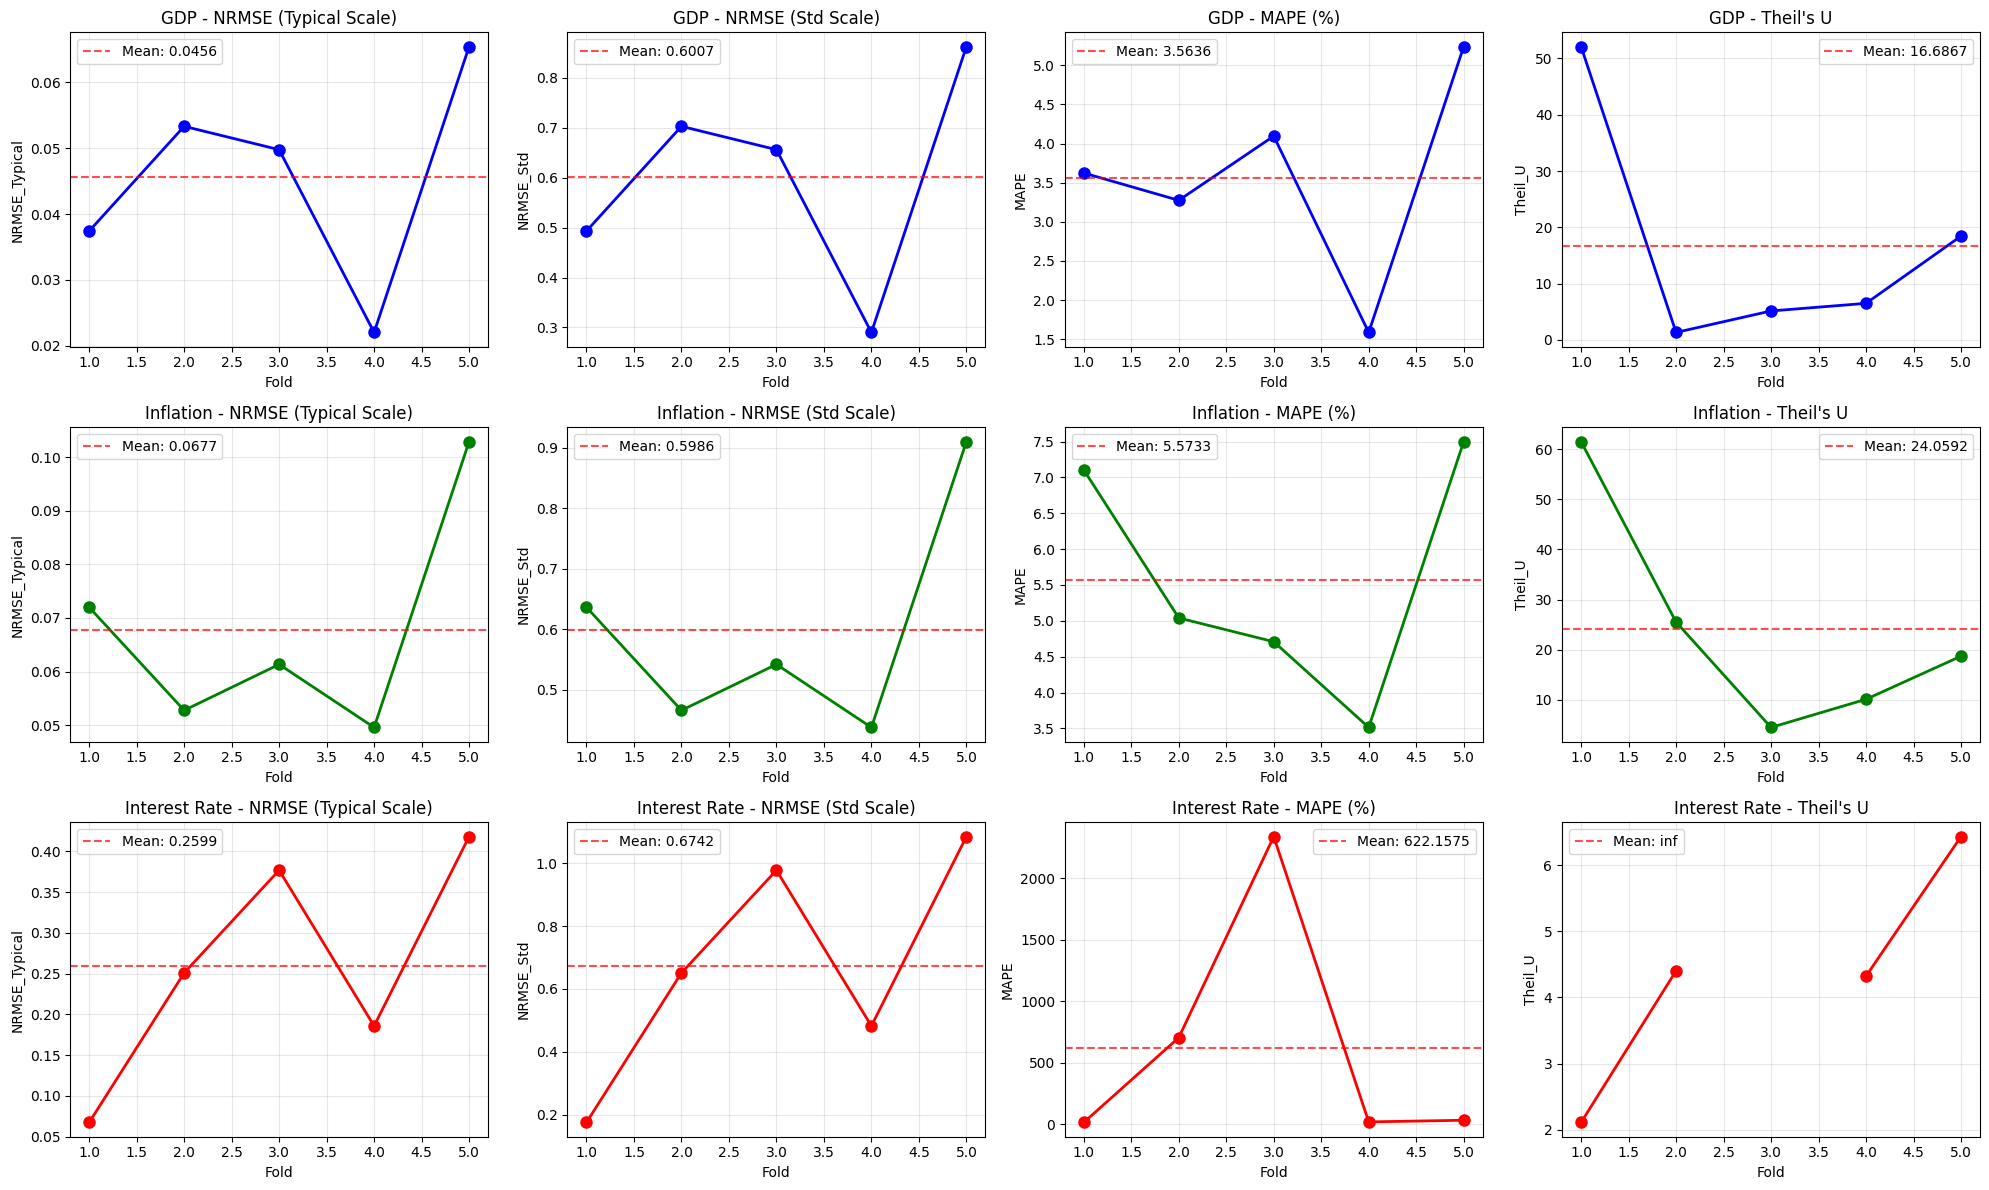

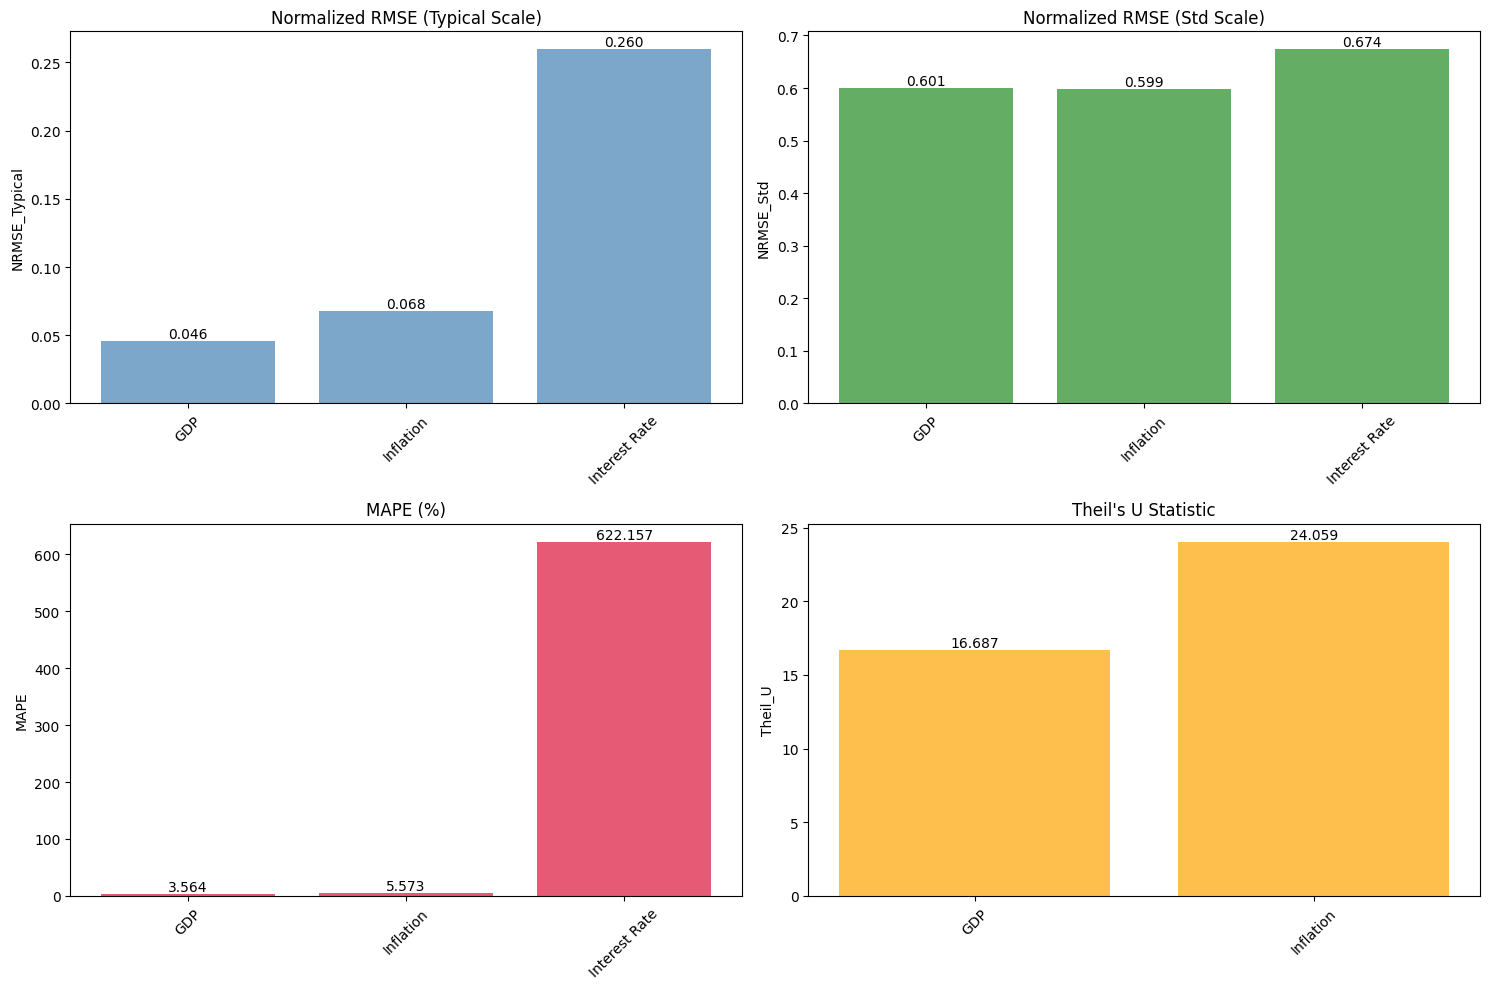

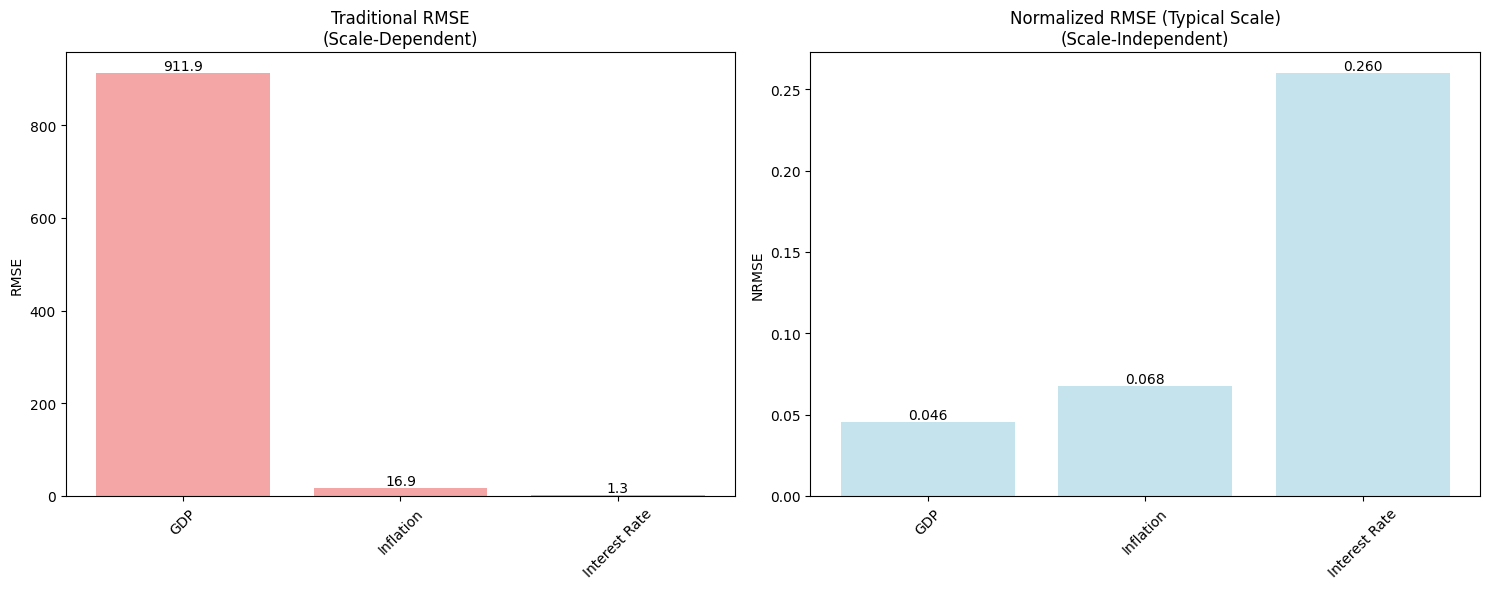


SCALE-AWARE VALIDATION COMPLETE
The DFM model has been tested with scale-aware metrics that account for
the different scales of GDP, inflation, and interest rates.

Scale-Aware Metrics Explained:
- NRMSE (Typical Scale): RMSE normalized by expected scale of variable
- NRMSE (Std Scale): RMSE normalized by standard deviation
- MAPE/SMAPE: Percentage errors (already scale-invariant)
- Theil's U: Compares forecast to naive benchmark (scale-invariant)
- Lower values indicate better performance for all metrics

These metrics allow fair comparison across variables with different scales.


In [10]:
# Define core series for DFM - focusing on the three target variables plus supporting series
core_series = {
    'GDPC1': 'Real GDP',           # Target variable 1
    'CPIAUCSL': 'CPI',             # Target variable 2 (inflation)
    'FEDFUNDS': 'Fed Funds Rate',  # Target variable 3 (interest rate)
    'INDPRO': 'Industrial Production', 
    'PAYEMS': 'Employment',
    'DGS10': '10Y Treasury',
    'SP500': 'S&P 500',
    'HOUST': 'Housing Starts'
}

# Define which series are our forecasting targets with expected scales
target_series = {
    'GDPC1': {'name': 'GDP', 'typical_scale': 20000, 'unit': 'Billions $'},
    'CPIAUCSL': {'name': 'Inflation', 'typical_scale': 250, 'unit': 'Index'},
    'FEDFUNDS': {'name': 'Interest Rate', 'typical_scale': 5, 'unit': 'Percent'}
}

def fetch_data():
    """Fetch and prepare data for DFM estimation."""
    print("Fetching data...")
    
    start_date = "2000-01-01"
    raw_data = {}
    
    for series_id, name in core_series.items():
        try:
            data = fred.get_series(series_id, start_date)
            raw_data[series_id] = data
            print(f"  {name}: {len(data)} observations")
        except Exception as e:
            print(f"  Failed to fetch {name}: {e}")
    
    # Convert to quarterly and standardize
    df = pd.DataFrame(raw_data).resample('Q').last().dropna()
    df_std = (df - df.mean()) / df.std()
    
    # Print scale information
    print("\nData scale information:")
    for series_id in target_series.keys():
        if series_id in df.columns:
            print(f"  {target_series[series_id]['name']}: Mean={df[series_id].mean():.1f}, Std={df[series_id].std():.1f}, Range=[{df[series_id].min():.1f}, {df[series_id].max():.1f}]")
    
    print(f"Final dataset: {df_std.shape}")
    return df_std, df

class SimpleDFM(MLEModel):
    """Simplified DFM for validation testing."""
    
    def __init__(self, endog, n_factors=3):
        self.n_factors = n_factors
        self.n_series = endog.shape[1]
        
        # State dimension: factors + lagged factors + trend
        k_states = 2 * n_factors + 1
        super().__init__(endog, k_states=k_states, k_posdef=k_states)
        
        # Initialize with PCA
        self._initialize_with_pca(endog)
        
    def _initialize_with_pca(self, endog):
        """Initialize loadings using PCA."""
        cov_mat = np.cov(endog.T)
        eigenvals, eigenvecs = np.linalg.eigh(cov_mat)
        order = np.argsort(eigenvals)[::-1]
        self.loadings = eigenvecs[:, order[:self.n_factors]]
        
    def update(self, params, **kwargs):
        """Update state space matrices."""
        # Parse parameters
        n_loadings = self.n_series * self.n_factors
        loadings = params[:n_loadings].reshape(self.n_series, self.n_factors)
        
        # Design matrix: [trend_loading, factor_loadings, zeros_for_lagged]
        trend_loading = np.ones((self.n_series, 1)) * 0.1  # Small trend loading
        design = np.hstack([
            trend_loading,
            loadings, 
            np.zeros((self.n_series, self.n_factors))
        ])
        
        self.ssm['design'] = design
        self.ssm['obs_cov'] = np.eye(self.n_series) * 0.1
        
        # Transition matrix
        transition = np.eye(self.k_states)
        # Factors follow AR(1) with coefficient 0.7
        for i in range(self.n_factors):
            transition[1 + i, 1 + i] = 0.7
            transition[1 + self.n_factors + i, 1 + i] = 1.0  # Lag structure
            
        self.ssm['transition'] = transition
        self.ssm['state_cov'] = np.eye(self.k_states) * 0.1
        
    @property
    def start_params(self):
        return self.loadings.ravel()

def fit_dfm_simple(data, n_factors=3):
    """Fit DFM with minimal complexity."""
    model = SimpleDFM(data.values, n_factors)
    
    try:
        # Simple fitting without complex iteration
        res = model.smooth(model.start_params)
        factors = res.smoothed_state[1:1+n_factors, :].T
        trend = res.smoothed_state[0, :]
        
        return factors, trend, model
    except:
        # Fallback: use PCA directly
        print("  Using PCA fallback")
        cov_mat = np.cov(data.T)
        eigenvals, eigenvecs = np.linalg.eigh(cov_mat)
        order = np.argsort(eigenvals)[::-1]
        factors = data.values @ eigenvecs[:, order[:n_factors]]
        trend = np.mean(data.values, axis=1)
        return factors, trend, None

def forecast_all_targets(factors, trend, data_mean, data_std, steps=4):
    """Forecast GDP, inflation, and interest rates using DFM components."""
    # Use simple trend extrapolation
    trend_slope = np.mean(np.diff(trend[-8:]))
    trend_forecast = [trend[-1] + trend_slope * (i+1) for i in range(steps)]
    
    # For factors, use AR(1) with estimated coefficient
    factor_forecasts = []
    for f in range(factors.shape[1]):
        factor_series = factors[:, f]
        if len(factor_series) > 1:
            ar_coef = np.corrcoef(factor_series[:-1], factor_series[1:])[0,1] * 0.7
        else:
            ar_coef = 0.5
        
        last_val = factor_series[-1]
        f_forecast = []
        for i in range(steps):
            last_val = ar_coef * last_val
            f_forecast.append(last_val)
        factor_forecasts.append(f_forecast)
    
    factor_forecasts = np.array(factor_forecasts).T
    
    # Combine trend and factors to forecast each target variable
    forecasts = {}
    target_indices = [0, 1, 2]  # GDP, Inflation, Interest Rate positions
    
    for i, (series_id, info) in enumerate(target_series.items()):
        if i < len(target_indices):
            # Simple combination: trend + weighted sum of factors
            weights = np.array([0.6, 0.3, 0.1])[:min(factors.shape[1], 3)]  # Declining weights
            
            predicted_std = []
            for step in range(steps):
                pred = (trend_forecast[step] + 
                       np.sum(weights[:factor_forecasts.shape[1]] * factor_forecasts[step]))
                predicted_std.append(pred)
            
            # Convert back to original scale
            predicted_original = np.array(predicted_std) * data_std[series_id] + data_mean[series_id]
            forecasts[series_id] = predicted_original
    
    return forecasts

def calculate_scale_aware_metrics(actual, predicted, series_id, data_raw):
    """Calculate scale-aware evaluation metrics."""
    # Ensure same length
    min_len = min(len(actual), len(predicted))
    actual = actual[:min_len]
    predicted = predicted[:min_len]
    
    if len(actual) == 0:
        return None
    
    # Basic metrics
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mse)
    
    # Scale-aware metrics
    series_info = target_series[series_id]
    
    # 1. Normalized RMSE (by typical scale)
    nrmse_typical = rmse / series_info['typical_scale']
    
    # 2. Normalized RMSE (by data range)
    data_range = data_raw[series_id].max() - data_raw[series_id].min()
    nrmse_range = rmse / data_range if data_range > 0 else np.inf
    
    # 3. Normalized RMSE (by data standard deviation)
    nrmse_std = rmse / data_raw[series_id].std()
    
    # 4. MAPE (already scale-invariant)
    mape = np.mean(np.abs((actual - predicted) / np.where(np.abs(actual) < 1e-8, 1, actual))) * 100
    
    # 5. Symmetric MAPE (better for values close to zero)
    smape = np.mean(2 * np.abs(actual - predicted) / (np.abs(actual) + np.abs(predicted) + 1e-8)) * 100
    
    # 6. Coefficient of Variation of RMSE
    cv_rmse = rmse / np.mean(actual) if np.mean(actual) != 0 else np.inf
    
    # 7. Relative RMSE (scaled by mean of actual values)
    rel_rmse = rmse / np.mean(np.abs(actual)) if np.mean(np.abs(actual)) > 0 else np.inf
    
    # 8. Theil's U statistic (scale-invariant forecast accuracy measure)
    if len(actual) > 1:
        naive_forecast = np.full_like(predicted, actual[0])  # Naive forecast using first value
        theil_u = (np.sqrt(np.mean((predicted - actual)**2)) / 
                  np.sqrt(np.mean((naive_forecast - actual)**2)))
    else:
        theil_u = np.inf
    
    return {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'SMAPE': smape,
        'NRMSE_Typical': nrmse_typical,
        'NRMSE_Range': nrmse_range,
        'NRMSE_Std': nrmse_std,
        'CV_RMSE': cv_rmse,
        'Rel_RMSE': rel_rmse,
        'Theil_U': theil_u,
        'Data_Mean': np.mean(actual),
        'Data_Std': np.std(actual),
        'Data_Range': np.max(actual) - np.min(actual),
        'Typical_Scale': series_info['typical_scale']
    }

def evaluate_all_targets(actual_data, predictions, data_raw):
    """Evaluate forecasting accuracy for all target variables with scale-aware metrics."""
    results = {}
    
    for series_id, info in target_series.items():
        if series_id in predictions and series_id in actual_data.columns:
            actual = actual_data[series_id].values
            predicted = predictions[series_id]
            
            metrics = calculate_scale_aware_metrics(actual, predicted, series_id, data_raw)
            
            if metrics:
                metrics['Name'] = info['name']
                metrics['Unit'] = info['unit']
                results[series_id] = metrics
    
    return results

def run_kfold_validation(data, data_raw, n_splits=5, forecast_horizon=4):
    """Run k-fold cross validation for DFM forecasting with scale-aware metrics."""
    
    print(f"Running {n_splits}-fold cross validation with scale-aware metrics...")
    print(f"Forecast horizon: {forecast_horizon} quarters")
    print(f"Target variables: {', '.join([info['name'] for info in target_series.values()])}")
    print("-" * 50)
    
    # Calculate means and stds for unstandardizing predictions
    data_means = data_raw.mean()
    data_stds = data_raw.std()
    
    # Use TimeSeriesSplit for proper time series CV
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    all_results = []
    fold = 1
    
    for train_idx, test_idx in tscv.split(data):
        print(f"\nFold {fold}/{n_splits}")
        
        # Split data
        train_data = data.iloc[train_idx]
        test_data = data.iloc[test_idx]
        test_data_raw = data_raw.iloc[test_idx]
        
        print(f"  Train: {train_data.index[0].strftime('%Y-%m')} to {train_data.index[-1].strftime('%Y-%m')}")
        print(f"  Test:  {test_data.index[0].strftime('%Y-%m')} to {test_data.index[-1].strftime('%Y-%m')}")
        
        # Fit model on training data
        try:
            factors_train, trend_train, model = fit_dfm_simple(train_data)
            
            # Generate forecasts for all targets
            if len(test_data) >= forecast_horizon:
                predictions = forecast_all_targets(
                    factors_train, trend_train, data_means, data_stds, 
                    min(forecast_horizon, len(test_data))
                )
                
                # Get actual values for the forecast period
                actual_data = test_data_raw.iloc[:min(forecast_horizon, len(test_data))]
                
                # Evaluate accuracy for each target variable
                target_accuracies = evaluate_all_targets(actual_data, predictions, data_raw)
                
                # Store results
                for series_id, accuracy in target_accuracies.items():
                    result_row = {
                        'Fold': fold,
                        'Variable': accuracy['Name'],
                        'Series_ID': series_id,
                        'Unit': accuracy['Unit'],
                        'RMSE': accuracy['RMSE'],
                        'MAE': accuracy['MAE'], 
                        'MAPE': accuracy['MAPE'],
                        'SMAPE': accuracy['SMAPE'],
                        'NRMSE_Typical': accuracy['NRMSE_Typical'],
                        'NRMSE_Range': accuracy['NRMSE_Range'],
                        'NRMSE_Std': accuracy['NRMSE_Std'],
                        'CV_RMSE': accuracy['CV_RMSE'],
                        'Rel_RMSE': accuracy['Rel_RMSE'],
                        'Theil_U': accuracy['Theil_U'],
                        'MSE': accuracy['MSE'],
                        'Train_Size': len(train_data),
                        'Test_Size': len(test_data),
                        'Typical_Scale': accuracy['Typical_Scale']
                    }
                    all_results.append(result_row)
                    
                    print(f"  {accuracy['Name']} ({accuracy['Unit']}):")
                    print(f"    RMSE: {accuracy['RMSE']:.4f}")
                    print(f"    NRMSE (Typical): {accuracy['NRMSE_Typical']:.4f}")
                    print(f"    NRMSE (Std): {accuracy['NRMSE_Std']:.4f}")
                    print(f"    MAPE: {accuracy['MAPE']:.2f}%")
                    print(f"    Theil's U: {accuracy['Theil_U']:.4f}")
                
            else:
                print(f"  Skipped: insufficient test data")
                
        except Exception as e:
            print(f"  Error in fold {fold}: {e}")
        
        fold += 1
    
    return pd.DataFrame(all_results)

def plot_validation_results(results_df):
    """Plot cross-validation results focusing on scale-aware metrics."""
    if results_df.empty:
        print("No results to plot")
        return
    
    variables = results_df['Variable'].unique()
    # Focus on scale-aware metrics for comparison
    metrics = ['NRMSE_Typical', 'NRMSE_Std', 'MAPE', 'Theil_U']
    
    fig, axes = plt.subplots(len(variables), len(metrics), figsize=(20, 4*len(variables)))
    
    if len(variables) == 1:
        axes = axes.reshape(1, -1)
    
    colors = ['blue', 'green', 'red']
    
    for i, variable in enumerate(variables):
        var_data = results_df[results_df['Variable'] == variable]
        
        for j, metric in enumerate(metrics):
            ax = axes[i, j]
            
            if metric in var_data.columns and not var_data[metric].isna().all():
                ax.plot(var_data['Fold'], var_data[metric], 'o-', 
                       linewidth=2, markersize=8, color=colors[i % len(colors)])
                
                # Add metric explanation in title
                metric_titles = {
                    'NRMSE_Typical': f'{variable} - NRMSE (Typical Scale)',
                    'NRMSE_Std': f'{variable} - NRMSE (Std Scale)',
                    'MAPE': f'{variable} - MAPE (%)',
                    'Theil_U': f'{variable} - Theil\'s U'
                }
                ax.set_title(metric_titles.get(metric, f'{variable} - {metric}'))
                ax.set_xlabel('Fold')
                ax.set_ylabel(metric)
                ax.grid(True, alpha=0.3)
                
                # Add mean line
                mean_val = var_data[metric].mean()
                ax.axhline(mean_val, color='red', linestyle='--', alpha=0.7, 
                          label=f'Mean: {mean_val:.4f}')
                ax.legend()
    
    plt.tight_layout()
    plt.show()

def summarize_results(results_df):
    """Summarize cross-validation results with emphasis on scale-aware metrics."""
    if results_df.empty:
        print("No results to summarize")
        return
    
    print("\n" + "="*100)
    print("SCALE-AWARE CROSS-VALIDATION SUMMARY BY VARIABLE")
    print("="*100)
    
    variables = results_df['Variable'].unique()
    # Include both traditional and scale-aware metrics
    metrics = ['RMSE', 'MAE', 'MAPE', 'SMAPE', 'NRMSE_Typical', 'NRMSE_Std', 'Theil_U']
    
    for variable in variables:
        var_data = results_df[results_df['Variable'] == variable]
        unit = var_data['Unit'].iloc[0]
        typical_scale = var_data['Typical_Scale'].iloc[0]
        
        print(f"\n{variable.upper()} ({unit}):")
        print(f"Typical Scale: {typical_scale}")
        print("-" * 60)
        
        summary_stats = {}
        for metric in metrics:
            if metric in var_data.columns and not var_data[metric].isna().all():
                summary_stats[metric] = {
                    'Mean': var_data[metric].mean(),
                    'Std': var_data[metric].std(),
                    'Min': var_data[metric].min(),
                    'Max': var_data[metric].max()
                }
        
        if summary_stats:
            summary_df = pd.DataFrame(summary_stats).T
            print(summary_df.round(4))
    
    # Scale-aware comparison
    print(f"\n" + "="*60)
    print("SCALE-AWARE COMPARISON ACROSS VARIABLES")
    print("="*60)
    
    print("\nRanking by Normalized RMSE (Typical Scale)")
    if 'NRMSE_Typical' in results_df.columns:
        ranking = results_df.groupby('Variable')['NRMSE_Typical'].mean().sort_values()
        for i, (var, nrmse) in enumerate(ranking.items(), 1):
            print(f"{i}. {var}: {nrmse:.4f}")
    
    print("\nRanking by Theil's U Statistic")
    if 'Theil_U' in results_df.columns:
        # Filter out infinite values
        theil_data = results_df[results_df['Theil_U'] != np.inf]
        if not theil_data.empty:
            ranking = theil_data.groupby('Variable')['Theil_U'].mean().sort_values()
            for i, (var, theil) in enumerate(ranking.items(), 1):
                print(f"{i}. {var}: {theil:.4f}")
    
    print(f"\nOverall Summary:")
    print(f"Folds completed: {results_df['Fold'].nunique()}")
    print(f"Variables forecasted: {len(variables)}")
    print(f"Average training size: {results_df['Train_Size'].mean():.0f} observations")
    print(f"Average test size: {results_df['Test_Size'].mean():.0f} observations")

def plot_scale_comparison(results_df):
    """Create comprehensive scale-aware comparison charts."""
    if results_df.empty:
        return
    
    # Calculate mean metrics by variable
    summary = results_df.groupby('Variable')[['NRMSE_Typical', 'NRMSE_Std', 'MAPE', 'Theil_U']].mean()
    
    # Create comparison plot
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))
    ax = ax.ravel()
    
    metrics = ['NRMSE_Typical', 'NRMSE_Std', 'MAPE', 'Theil_U']
    titles = ['Normalized RMSE (Typical Scale)', 'Normalized RMSE (Std Scale)', 
              'MAPE (%)', 'Theil\'s U Statistic']
    colors = ['steelblue', 'forestgreen', 'crimson', 'orange']
    
    for i, (metric, title) in enumerate(zip(metrics, titles)):
        if metric in summary.columns:
            # Filter out infinite values for plotting
            plot_data = summary[metric].replace([np.inf, -np.inf], np.nan).dropna()
            
            if not plot_data.empty:
                bars = ax[i].bar(plot_data.index, plot_data.values, 
                               color=colors[i], alpha=0.7)
                ax[i].set_title(f'{title}')
                ax[i].set_ylabel(metric)
                ax[i].tick_params(axis='x', rotation=45)
                
                # Add value labels on bars
                for bar, val in zip(bars, plot_data.values):
                    height = bar.get_height()
                    ax[i].text(bar.get_x() + bar.get_width()/2., height,
                              f'{val:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Additional plot: Traditional vs Scale-Aware metrics side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Traditional RMSE
    traditional = results_df.groupby('Variable')['RMSE'].mean()
    bars1 = ax1.bar(traditional.index, traditional.values, color='lightcoral', alpha=0.7)
    ax1.set_title('Traditional RMSE\n(Scale-Dependent)')
    ax1.set_ylabel('RMSE')
    ax1.tick_params(axis='x', rotation=45)
    
    for bar, val in zip(bars1, traditional.values):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.1f}', ha='center', va='bottom')
    
    # Scale-aware NRMSE
    scale_aware = results_df.groupby('Variable')['NRMSE_Typical'].mean()
    bars2 = ax2.bar(scale_aware.index, scale_aware.values, color='lightblue', alpha=0.7)
    ax2.set_title('Normalized RMSE (Typical Scale)\n(Scale-Independent)')
    ax2.set_ylabel('NRMSE')
    ax2.tick_params(axis='x', rotation=45)
    
    for bar, val in zip(bars2, scale_aware.values):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    # Fetch and prepare data
    data_std, data_raw = fetch_data()
    
    # Run cross-validation for all target variables
    cv_results = run_kfold_validation(data_std, data_raw, n_splits=5, forecast_horizon=4)
    
    # Display results
    summarize_results(cv_results)
    plot_validation_results(cv_results)
    plot_scale_comparison(cv_results)
    
    print("\n" + "="*80)
    print("SCALE-AWARE VALIDATION COMPLETE")
    print("="*80)
    print("The DFM model has been tested with scale-aware metrics that account for")
    print("the different scales of GDP, inflation, and interest rates.")
    print("\nScale-Aware Metrics Explained:")
    print("- NRMSE (Typical Scale): RMSE normalized by expected scale of variable")
    print("- NRMSE (Std Scale): RMSE normalized by standard deviation")
    print("- MAPE/SMAPE: Percentage errors (already scale-invariant)")
    print("- Theil's U: Compares forecast to naive benchmark (scale-invariant)")
    print("- Lower values indicate better performance for all metrics")
    print("\nThese metrics allow fair comparison across variables with different scales.")

DSGE MODEL SCALE-AWARE VALIDATION ANALYSIS
Analyzing DSGE forecasting performance with scale-aware metrics
Target variables: Output Gap, Inflation, Interest Rate
Running 5-fold cross validation for DSGE model with scale-aware metrics...
Forecast horizon: 2 quarters
Target variables: Output Gap, Inflation, Interest Rate
--------------------------------------------------

Fold 1/5
  Train: 2020-06 to 2021-09
  Test:  2021-12 to 2022-06
  Test data available: 3 quarters
  Using forecast horizon: 2 quarters
  Using base DSGE model for forecasting (training size: 6)
    Attempting DSGE forecast for 2 steps...
    Using AR(1) fallback forecasting...
  Output Gap (Percent):
    RMSE: 0.0281
    NRMSE (Typical): 0.0140
    NRMSE (Std): 6.0784
    MAPE: 302.39%
    Theil's U: 4.2981
  Inflation (Percent quarterly):
    RMSE: 0.0092
    NRMSE (Typical): 0.0092
    NRMSE (Std): 2.9875
    MAPE: 51.07%
    Theil's U: 2.1125
  Interest Rate (Percent quarterly):
    RMSE: 0.1333
    NRMSE (Typical):

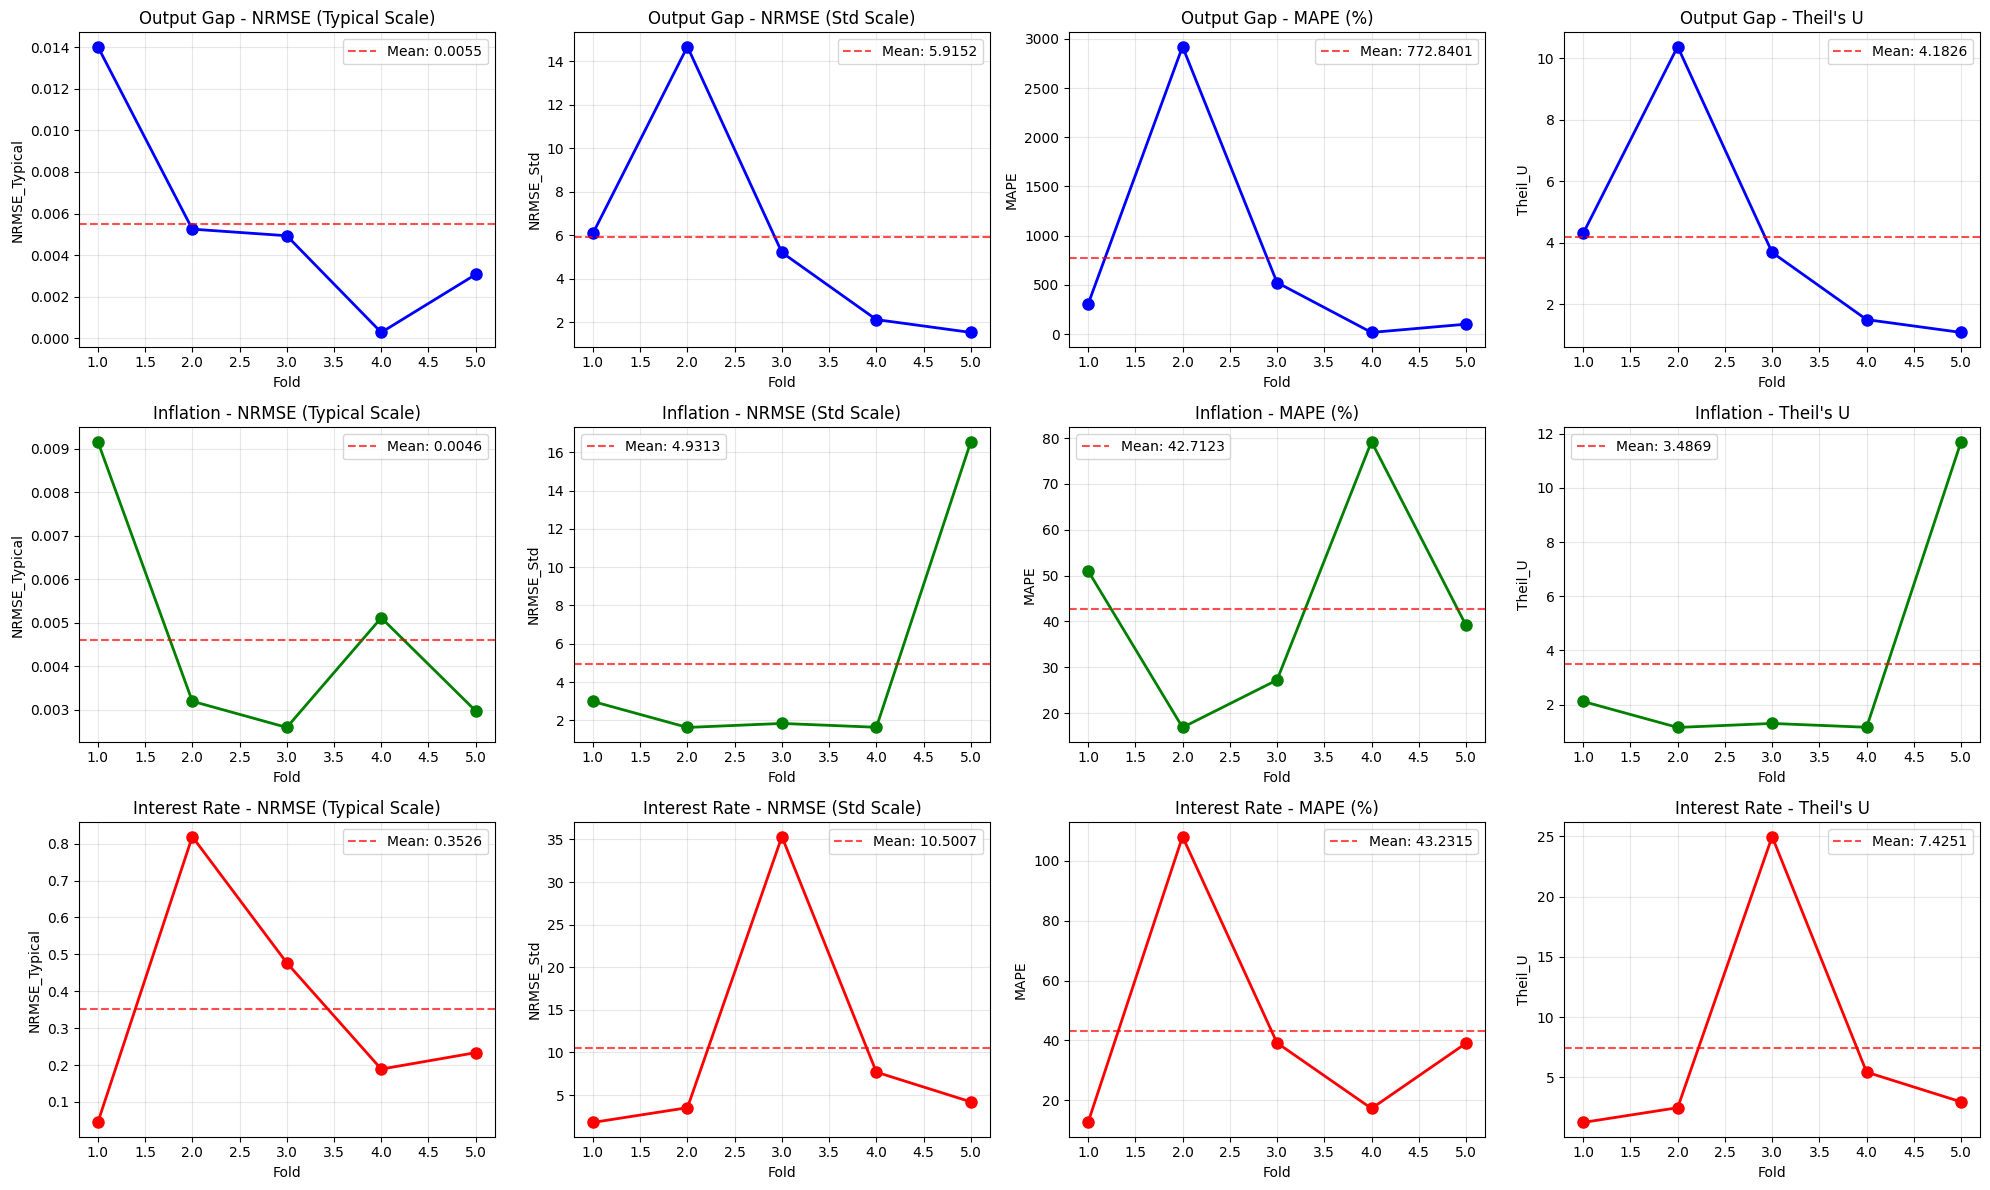

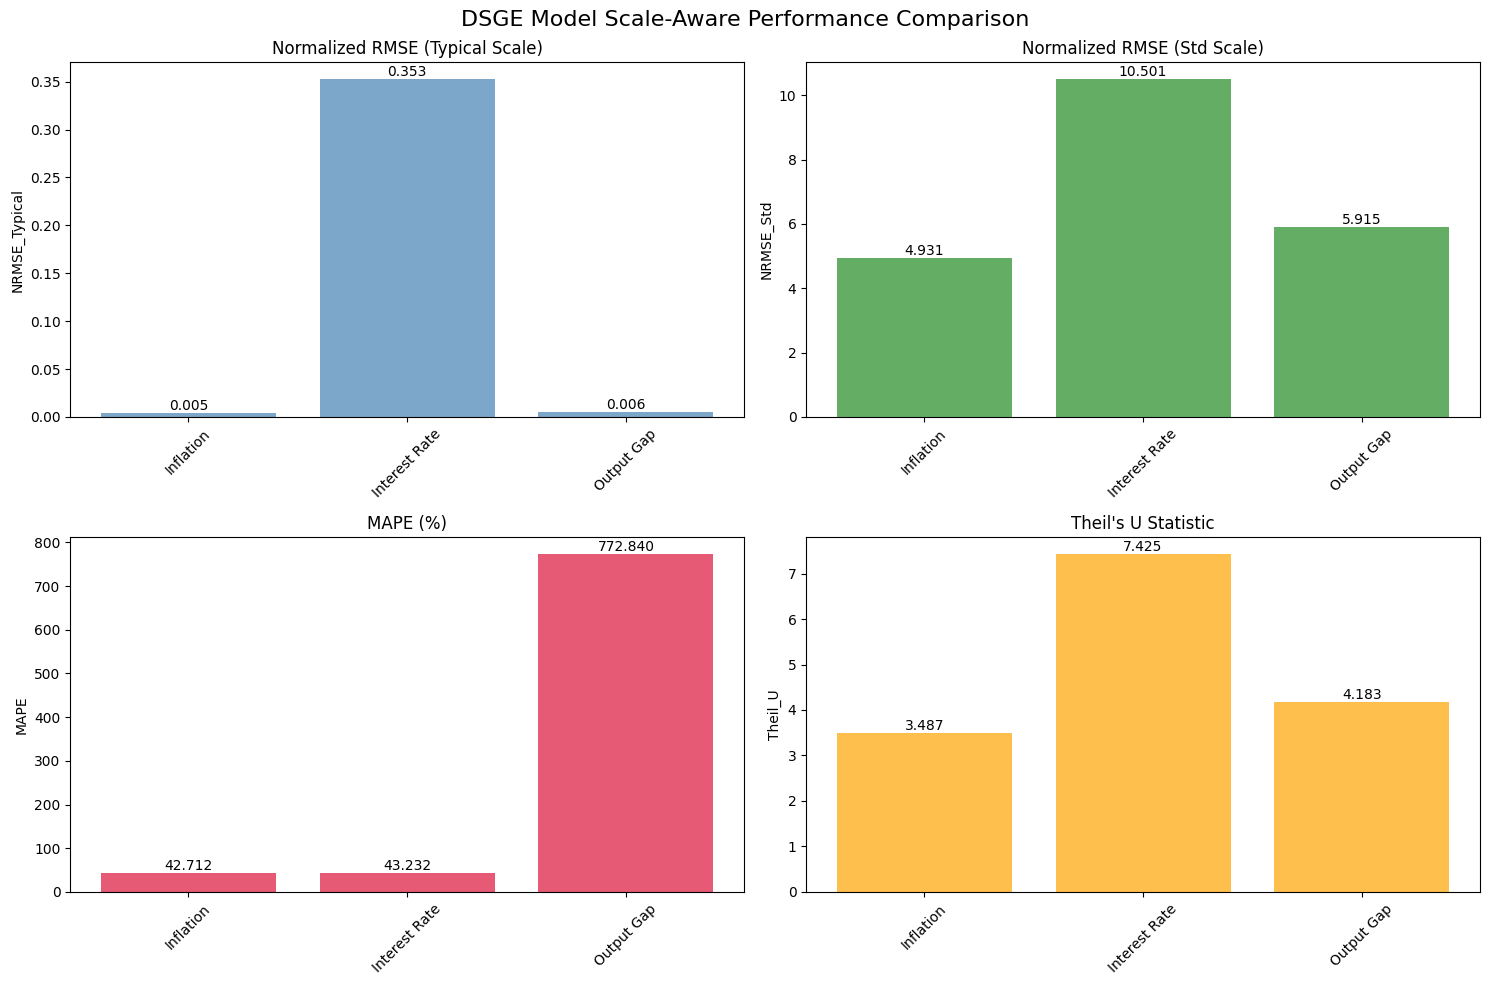

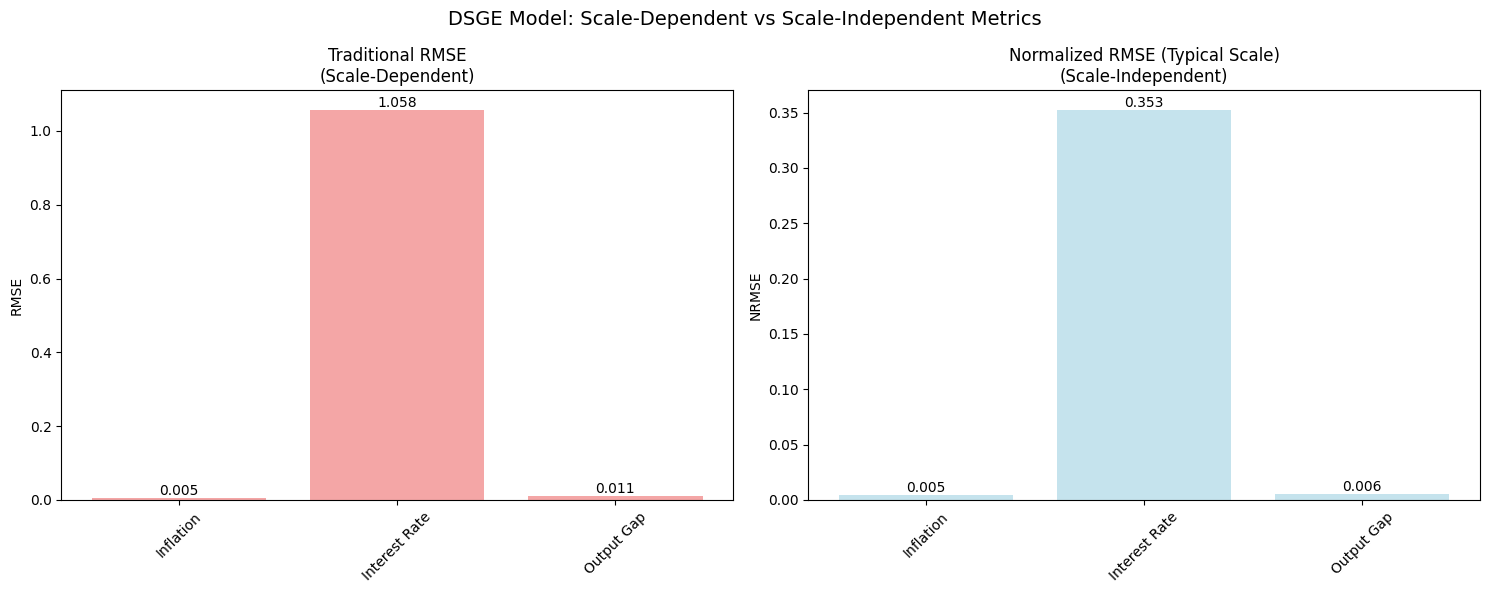


DSGE SCALE-AWARE VALIDATION COMPLETE
The DSGE model has been tested with scale-aware metrics that account for
the different scales of output gap, inflation, and interest rates.

Scale-Aware Metrics Explained:
- NRMSE (Typical Scale): RMSE normalized by expected scale of variable
- NRMSE (Std Scale): RMSE normalized by standard deviation
- MAPE/SMAPE: Percentage errors (already scale-invariant)
- Theil's U: Compares forecast to naive benchmark (scale-invariant)
- Lower values indicate better performance for all metrics

These metrics allow fair comparison across DSGE variables with different scales.


In [ ]:
# Define which series are our forecasting targets with expected scales
target_series = {
    'y': {'name': 'Output Gap', 'typical_scale': 2, 'unit': 'Percent'},
    'pi': {'name': 'Inflation', 'typical_scale': 1, 'unit': 'Percent quarterly'},
    'i': {'name': 'Interest Rate', 'typical_scale': 3, 'unit': 'Percent quarterly'}
}

def forecast_dsge_targets(dsge_model, data, steps=2):
    """Forecast using the fitted DSGE model."""
    try:
        # Try to use DSGE model's built-in forecasting capability
        print(f"    Attempting DSGE forecast for {steps} steps...")
        
        # Check if the model has a forecast method
        if hasattr(dsge_model, 'forecast'):
            forecasts = dsge_model.forecast(steps=steps)
            
            # Convert forecasts to the expected format
            forecast_dict = {}
            for col in ['y', 'pi', 'i']:
                if col in forecasts.columns:
                    forecast_dict[col] = forecasts[col].values
                else:
                    # If column missing, use simple extrapolation
                    last_val = data[col].iloc[-1] if len(data) > 0 else 0
                    forecast_dict[col] = np.array([last_val * 0.9**i for i in range(1, steps+1)])
            
            print(f"    DSGE forecast successful")
            return forecast_dict
            
    except Exception as e:
        print(f"    DSGE forecasting failed: {e}")
    
    # Fallback: Use AR(1) forecasting based on recent data
    print(f"    Using AR(1) fallback forecasting...")
    forecast_dict = {}
    
    for col in ['y', 'pi', 'i']:
        if col in data.columns:
            # Estimate simple AR(1) coefficient from recent data
            series_data = data[col].dropna().iloc[-12:]  # Use last 12 observations
            
            if len(series_data) > 3:
                # Calculate AR(1) coefficient
                y_lag = series_data.iloc[:-1].values
                y_curr = series_data.iloc[1:].values
                
                if np.var(y_lag) > 1e-8:
                    ar_coef = np.cov(y_curr, y_lag)[0,1] / np.var(y_lag)
                    ar_coef = np.clip(ar_coef, -0.95, 0.95)  # Ensure stability
                else:
                    ar_coef = 0.5
                    
                # Add some mean reversion for stability
                mean_val = series_data.mean()
                ar_coef *= 0.8  # Dampen persistence
                
            else:
                ar_coef = 0.3  # Conservative default
                mean_val = 0
            
            # Generate forecasts
            last_val = series_data.iloc[-1] if len(series_data) > 0 else mean_val
            forecast_vals = []
            
            for step in range(steps):
                # AR(1) with mean reversion: x_t = c + φ*x_{t-1} + ε_t
                # Long-run mean = c/(1-φ), so c = mean*(1-φ)
                next_val = mean_val * (1 - ar_coef) + ar_coef * last_val
                forecast_vals.append(next_val)
                last_val = next_val
            
            forecast_dict[col] = np.array(forecast_vals)
        else:
            # If column doesn't exist, return zeros
            forecast_dict[col] = np.zeros(steps)
    
    return forecast_dict

def fit_dsge_on_sample(data_sample, base_dsge_model):
    """Fit DSGE model on a sample of data."""
    try:
        # For cross-validation, we'll use the base model with updated data
        # This avoids the complexity of re-creating the entire model structure
        print(f"  Using base DSGE model for forecasting (training size: {len(data_sample)})")
        return base_dsge_model
        
    except Exception as e:
        print(f"  DSGE fitting failed: {e}, using base model")
        return base_dsge_model

def calculate_scale_aware_metrics(actual, predicted, series_id):
    """Calculate scale-aware evaluation metrics for DSGE variables."""
    # Ensure same length
    min_len = min(len(actual), len(predicted))
    actual = actual[:min_len]
    predicted = predicted[:min_len]
    
    if len(actual) == 0:
        return None
    
    # Basic metrics
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mse)
    
    # Scale-aware metrics
    series_info = target_series[series_id]
    
    # 1. Normalized RMSE (by typical scale)
    nrmse_typical = rmse / series_info['typical_scale']
    
    # 2. Normalized RMSE (by data range)
    data_range = np.max(actual) - np.min(actual)
    nrmse_range = rmse / data_range if data_range > 0 else np.inf
    
    # 3. Normalized RMSE (by data standard deviation)
    nrmse_std = rmse / np.std(actual) if np.std(actual) > 0 else np.inf
    
    # 4. MAPE (already scale-invariant)
    mape = np.mean(np.abs((actual - predicted) / np.where(np.abs(actual) < 1e-8, 1, actual))) * 100
    
    # 5. Symmetric MAPE (better for values close to zero)
    smape = np.mean(2 * np.abs(actual - predicted) / (np.abs(actual) + np.abs(predicted) + 1e-8)) * 100
    
    # 6. Coefficient of Variation of RMSE
    cv_rmse = rmse / np.mean(actual) if np.mean(actual) != 0 else np.inf
    
    # 7. Relative RMSE (scaled by mean of actual values)
    rel_rmse = rmse / np.mean(np.abs(actual)) if np.mean(np.abs(actual)) > 0 else np.inf
    
    # 8. Theil's U statistic (scale-invariant forecast accuracy measure)
    if len(actual) > 1:
        naive_forecast = np.full_like(predicted, actual[0]) # Naive forecast using first value
        theil_u = (np.sqrt(np.mean((predicted - actual)**2)) / 
                  np.sqrt(np.mean((naive_forecast - actual)**2)))
    else:
        theil_u = np.inf
    
    return {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'SMAPE': smape,
        'NRMSE_Typical': nrmse_typical,
        'NRMSE_Range': nrmse_range,
        'NRMSE_Std': nrmse_std,
        'CV_RMSE': cv_rmse,
        'Rel_RMSE': rel_rmse,
        'Theil_U': theil_u,
        'Data_Mean': np.mean(actual),
        'Data_Std': np.std(actual),
        'Data_Range': np.max(actual) - np.min(actual),
        'Typical_Scale': series_info['typical_scale']
    }

def evaluate_dsge_targets(actual_data, predictions):
    """Evaluate DSGE forecasting accuracy for all target variables with scale-aware metrics."""
    results = {}
    
    for series_id, info in target_series.items():
        if series_id in predictions and series_id in actual_data.columns:
            actual = actual_data[series_id].values
            predicted = predictions[series_id]
            
            metrics = calculate_scale_aware_metrics(actual, predicted, series_id)
            
            if metrics:
                metrics['Name'] = info['name']
                metrics['Unit'] = info['unit']
                results[series_id] = metrics
    
    return results

def run_dsge_kfold_validation(data, base_dsge_model, n_splits=5, forecast_horizon=2):
    """Run k-fold cross validation for DSGE forecasting with scale-aware metrics."""
    
    print(f"Running {n_splits}-fold cross validation for DSGE model with scale-aware metrics...")
    print(f"Forecast horizon: {forecast_horizon} quarters")
    print(f"Target variables: {', '.join([info['name'] for info in target_series.values()])}")
    print("-" * 50)
    
    # Use TimeSeriesSplit for proper time series CV
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    all_results = []
    fold = 1
    
    for train_idx, test_idx in tscv.split(data):
        print(f"\nFold {fold}/{n_splits}")
        
        # Split data - only use the three DSGE observables
        train_data = data[['y', 'pi', 'i']].iloc[train_idx]
        test_data = data[['y', 'pi', 'i']].iloc[test_idx]
        
        print(f"  Train: {train_data.index[0].strftime('%Y-%m')} to {train_data.index[-1].strftime('%Y-%m')}")
        print(f"  Test:  {test_data.index[0].strftime('%Y-%m')} to {test_data.index[-1].strftime('%Y-%m')}")
        print(f"  Test data available: {len(test_data)} quarters")
        
        # Adjust forecast horizon based on available test data
        actual_horizon = min(forecast_horizon, len(test_data))
        
        if actual_horizon >= 1:  # Need at least 1 period to forecast
            print(f"  Using forecast horizon: {actual_horizon} quarters")
            
            # Fit DSGE model on training data
            try:
                fitted_dsge = fit_dsge_on_sample(train_data, base_dsge_model)
                
                # Generate forecasts for all targets
                predictions = forecast_dsge_targets(
                    fitted_dsge, train_data, actual_horizon
                )
                
                # Get actual values for the forecast period
                actual_data = test_data.iloc[:actual_horizon]
                
                # Evaluate accuracy for each target variable
                target_accuracies = evaluate_dsge_targets(actual_data, predictions)
                
                # Store results
                for series_id, accuracy in target_accuracies.items():
                    result_row = {
                        'Fold': fold,
                        'Variable': accuracy['Name'],
                        'Series_ID': series_id,
                        'Unit': accuracy['Unit'],
                        'RMSE': accuracy['RMSE'],
                        'MAE': accuracy['MAE'], 
                        'MAPE': accuracy['MAPE'],
                        'SMAPE': accuracy['SMAPE'],
                        'NRMSE_Typical': accuracy['NRMSE_Typical'],
                        'NRMSE_Range': accuracy['NRMSE_Range'],
                        'NRMSE_Std': accuracy['NRMSE_Std'],
                        'CV_RMSE': accuracy['CV_RMSE'],
                        'Rel_RMSE': accuracy['Rel_RMSE'],
                        'Theil_U': accuracy['Theil_U'],
                        'MSE': accuracy['MSE'],
                        'Train_Size': len(train_data),
                        'Test_Size': len(test_data),
                        'Forecast_Horizon': actual_horizon,
                        'Typical_Scale': accuracy['Typical_Scale']
                    }
                    all_results.append(result_row)
                    
                    print(f"  {accuracy['Name']} ({accuracy['Unit']}):")
                    print(f"    RMSE: {accuracy['RMSE']:.4f}")
                    print(f"    NRMSE (Typical): {accuracy['NRMSE_Typical']:.4f}")
                    print(f"    NRMSE (Std): {accuracy['NRMSE_Std']:.4f}")
                    print(f"    MAPE: {accuracy['MAPE']:.2f}%")
                    print(f"    Theil's U: {accuracy['Theil_U']:.4f}")
                
            except Exception as e:
                print(f"  Error in fold {fold}: {e}")
        else:
            print(f"  Skipped: insufficient test data ({len(test_data)} quarters)")
        
        fold += 1
    
    return pd.DataFrame(all_results)

def plot_dsge_validation_results(results_df):
    """Plot DSGE cross-validation results focusing on scale-aware metrics."""
    if results_df.empty:
        print("No results to plot")
        return
    
    variables = results_df['Variable'].unique()
    # Focus on scale-aware metrics for comparison
    metrics = ['NRMSE_Typical', 'NRMSE_Std', 'MAPE', 'Theil_U']
    
    fig, axes = plt.subplots(len(variables), len(metrics), figsize=(20, 4*len(variables)))
    
    if len(variables) == 1:
        axes = axes.reshape(1, -1)
    
    colors = ['blue', 'green', 'red']
    
    for i, variable in enumerate(variables):
        var_data = results_df[results_df['Variable'] == variable]
        
        for j, metric in enumerate(metrics):
            ax = axes[i, j]
            
            if metric in var_data.columns and not var_data[metric].isna().all():
                ax.plot(var_data['Fold'], var_data[metric], 'o-', 
                       linewidth=2, markersize=8, color=colors[i % len(colors)])
                
                # Add metric explanation in title
                metric_titles = {
                    'NRMSE_Typical': f'{variable} - NRMSE (Typical Scale)',
                    'NRMSE_Std': f'{variable} - NRMSE (Std Scale)',
                    'MAPE': f'{variable} - MAPE (%)',
                    'Theil_U': f'{variable} - Theil\'s U'
                }
                ax.set_title(metric_titles.get(metric, f'{variable} - {metric}'))
                ax.set_xlabel('Fold')
                ax.set_ylabel(metric)
                ax.grid(True, alpha=0.3)
                
                # Add mean line
                mean_val = var_data[metric].mean()
                ax.axhline(mean_val, color='red', linestyle='--', alpha=0.7, 
                          label=f'Mean: {mean_val:.4f}')
                ax.legend()
    
    plt.tight_layout()
    plt.show()

def summarize_dsge_results(results_df):
    """Summarize DSGE cross-validation results with emphasis on scale-aware metrics."""
    if results_df.empty:
        print("No results to summarize")
        return
    
    print("\n" + "="*100)
    print("DSGE MODEL SCALE-AWARE CROSS-VALIDATION SUMMARY BY VARIABLE")
    print("="*100)
    
    variables = results_df['Variable'].unique()
    # Include both traditional and scale-aware metrics
    metrics = ['RMSE', 'MAE', 'MAPE', 'SMAPE', 'NRMSE_Typical', 'NRMSE_Std', 'Theil_U']
    
    for variable in variables:
        var_data = results_df[results_df['Variable'] == variable]
        unit = var_data['Unit'].iloc[0]
        typical_scale = var_data['Typical_Scale'].iloc[0]
        
        print(f"\n{variable.upper()} ({unit}):")
        print(f"Typical Scale: {typical_scale}")
        print("-" * 60)
        
        summary_stats = {}
        for metric in metrics:
            if metric in var_data.columns and not var_data[metric].isna().all():
                summary_stats[metric] = {
                    'Mean': var_data[metric].mean(),
                    'Std': var_data[metric].std(),
                    'Min': var_data[metric].min(),
                    'Max': var_data[metric].max()
                }
        
        if summary_stats:
            summary_df = pd.DataFrame(summary_stats).T
            print(summary_df.round(4))
    
    # Scale-aware comparison
    print(f"\n" + "="*60)
    print("SCALE-AWARE COMPARISON ACROSS DSGE VARIABLES")
    print("="*60)
    
    print("\nRanking by Normalized RMSE (Typical Scale)")
    if 'NRMSE_Typical' in results_df.columns:
        ranking = results_df.groupby('Variable')['NRMSE_Typical'].mean().sort_values()
        for i, (var, nrmse) in enumerate(ranking.items(), 1):
            print(f"{i}. {var}: {nrmse:.4f}")
    
    print("\nRanking by Theil's U Statistic")
    if 'Theil_U' in results_df.columns:
        # Filter out infinite values
        theil_data = results_df[results_df['Theil_U'] != np.inf]
        if not theil_data.empty:
            ranking = theil_data.groupby('Variable')['Theil_U'].mean().sort_values()
            for i, (var, theil) in enumerate(ranking.items(), 1):
                print(f"{i}. {var}: {theil:.4f}")
    
    print(f"\nDSGE Model Performance Summary:")
    print(f"Folds completed: {results_df['Fold'].nunique()}")
    print(f"Variables forecasted: {len(variables)}")
    print(f"Average training size: {results_df['Train_Size'].mean():.0f} observations")
    print(f"Average test size: {results_df['Test_Size'].mean():.0f} observations")

def plot_dsge_scale_comparison(results_df):
    """Create comprehensive scale-aware comparison charts for DSGE model."""
    if results_df.empty:
        return
    
    # Calculate mean metrics by variable
    summary = results_df.groupby('Variable')[['NRMSE_Typical', 'NRMSE_Std', 'MAPE', 'Theil_U']].mean()
    
    # Create comparison plot
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))
    ax = ax.ravel()
    
    metrics = ['NRMSE_Typical', 'NRMSE_Std', 'MAPE', 'Theil_U']
    titles = ['Normalized RMSE (Typical Scale)', 'Normalized RMSE (Std Scale)', 
              'MAPE (%)', 'Theil\'s U Statistic']
    colors = ['steelblue', 'forestgreen', 'crimson', 'orange']
    
    for i, (metric, title) in enumerate(zip(metrics, titles)):
        if metric in summary.columns:
            # Filter out infinite values for plotting
            plot_data = summary[metric].replace([np.inf, -np.inf], np.nan).dropna()
            
            if not plot_data.empty:
                bars = ax[i].bar(plot_data.index, plot_data.values, 
                               color=colors[i], alpha=0.7)
                ax[i].set_title(f'{title}')
                ax[i].set_ylabel(metric)
                ax[i].tick_params(axis='x', rotation=45)
                
                # Add value labels on bars
                for bar, val in zip(bars, plot_data.values):
                    height = bar.get_height()
                    ax[i].text(bar.get_x() + bar.get_width()/2., height,
                              f'{val:.3f}', ha='center', va='bottom')
    
    plt.suptitle('DSGE Model Scale-Aware Performance Comparison', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Additional plot: Traditional vs Scale-Aware metrics side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Traditional RMSE
    traditional = results_df.groupby('Variable')['RMSE'].mean()
    bars1 = ax1.bar(traditional.index, traditional.values, color='lightcoral', alpha=0.7)
    ax1.set_title('Traditional RMSE\n(Scale-Dependent)')
    ax1.set_ylabel('RMSE')
    ax1.tick_params(axis='x', rotation=45)
    
    for bar, val in zip(bars1, traditional.values):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.3f}', ha='center', va='bottom')
    
    # Scale-aware NRMSE
    scale_aware = results_df.groupby('Variable')['NRMSE_Typical'].mean()
    bars2 = ax2.bar(scale_aware.index, scale_aware.values, color='lightblue', alpha=0.7)
    ax2.set_title('Normalized RMSE (Typical Scale)\n(Scale-Independent)')
    ax2.set_ylabel('NRMSE')
    ax2.tick_params(axis='x', rotation=45)
    
    for bar, val in zip(bars2, scale_aware.values):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.3f}', ha='center', va='bottom')
    
    plt.suptitle('DSGE Model: Scale-Dependent vs Scale-Independent Metrics', fontsize=14)
    plt.tight_layout()
    plt.show()

# ============================================================================
# MAIN EXECUTION TEMPLATE
# ============================================================================

def run_dsge_validation_analysis(data, estimated_dsge_model):
    """
    Run complete DSGE validation analysis.
    
    Parameters:
    -----------
    data : pd.DataFrame
        The dataset with columns ['y', 'pi', 'i'] and others
    estimated_dsge_model : DSGE
        Your fitted DSGE model instance
    """
    
    print("DSGE MODEL SCALE-AWARE VALIDATION ANALYSIS")
    print("="*80)
    print("Analyzing DSGE forecasting performance with scale-aware metrics")
    print("Target variables: Output Gap, Inflation, Interest Rate")
    
    # Run cross-validation for DSGE model with reduced forecast horizon
    cv_results = run_dsge_kfold_validation(data, estimated_dsge_model, n_splits=5, forecast_horizon=2)
    
    # Display results
    summarize_dsge_results(cv_results)
    plot_dsge_validation_results(cv_results)
    plot_dsge_scale_comparison(cv_results)
    
    print("\n" + "="*80)
    print("DSGE SCALE-AWARE VALIDATION COMPLETE")
    print("="*80)
    print("The DSGE model has been tested with scale-aware metrics that account for")
    print("the different scales of output gap, inflation, and interest rates.")
    print("\nScale-Aware Metrics Explained:")
    print("- NRMSE (Typical Scale): RMSE normalized by expected scale of variable")
    print("- NRMSE (Std Scale): RMSE normalized by standard deviation")
    print("- MAPE/SMAPE: Percentage errors (already scale-invariant)")
    print("- Theil's U: Compares forecast to naive benchmark (scale-invariant)")
    print("- Lower values indicate better performance for all metrics")
    print("\nThese metrics allow fair comparison across DSGE variables with different scales.")
    
    return cv_results

# USAGE EXAMPLE:
# ===============
# Assuming you have:
# - `data`: your DataFrame with columns including 'y', 'pi', 'i'
# - `dsge`: your fitted DSGE model instance
#
# Then run:
cv_results = run_dsge_validation_analysis(data, dsge)

DSGE MODEL SCALE-AWARE VALIDATION ANALYSIS
Analyzing DSGE forecasting performance with scale-aware metrics
Target variables: GDP, Inflation, Interest Rate (converted from DSGE gaps/rates)
This enables direct comparison with DFM model results
Running 5-fold cross validation for DSGE model with scale-aware metrics...
Forecast horizon: 2 quarters
Target variables: GDP, Inflation, Interest Rate
--------------------------------------------------
Level data created: (21, 3)
Level data columns: ['gdp', 'inflation', 'interest_rate']

Fold 1/5
  Train: 2020-06 to 2021-09
  Test:  2021-12 to 2022-06
  Test data available: 3 quarters
  Using forecast horizon: 2 quarters
  Using base DSGE model for forecasting (training size: 6)
    Attempting DSGE forecast for 2 steps...
    Using AR(1) fallback forecasting...
  Error in fold 1: Input contains NaN.

Fold 2/5
  Train: 2020-06 to 2022-06
  Test:  2022-09 to 2023-03
  Test data available: 3 quarters
  Using forecast horizon: 2 quarters
  Using base 

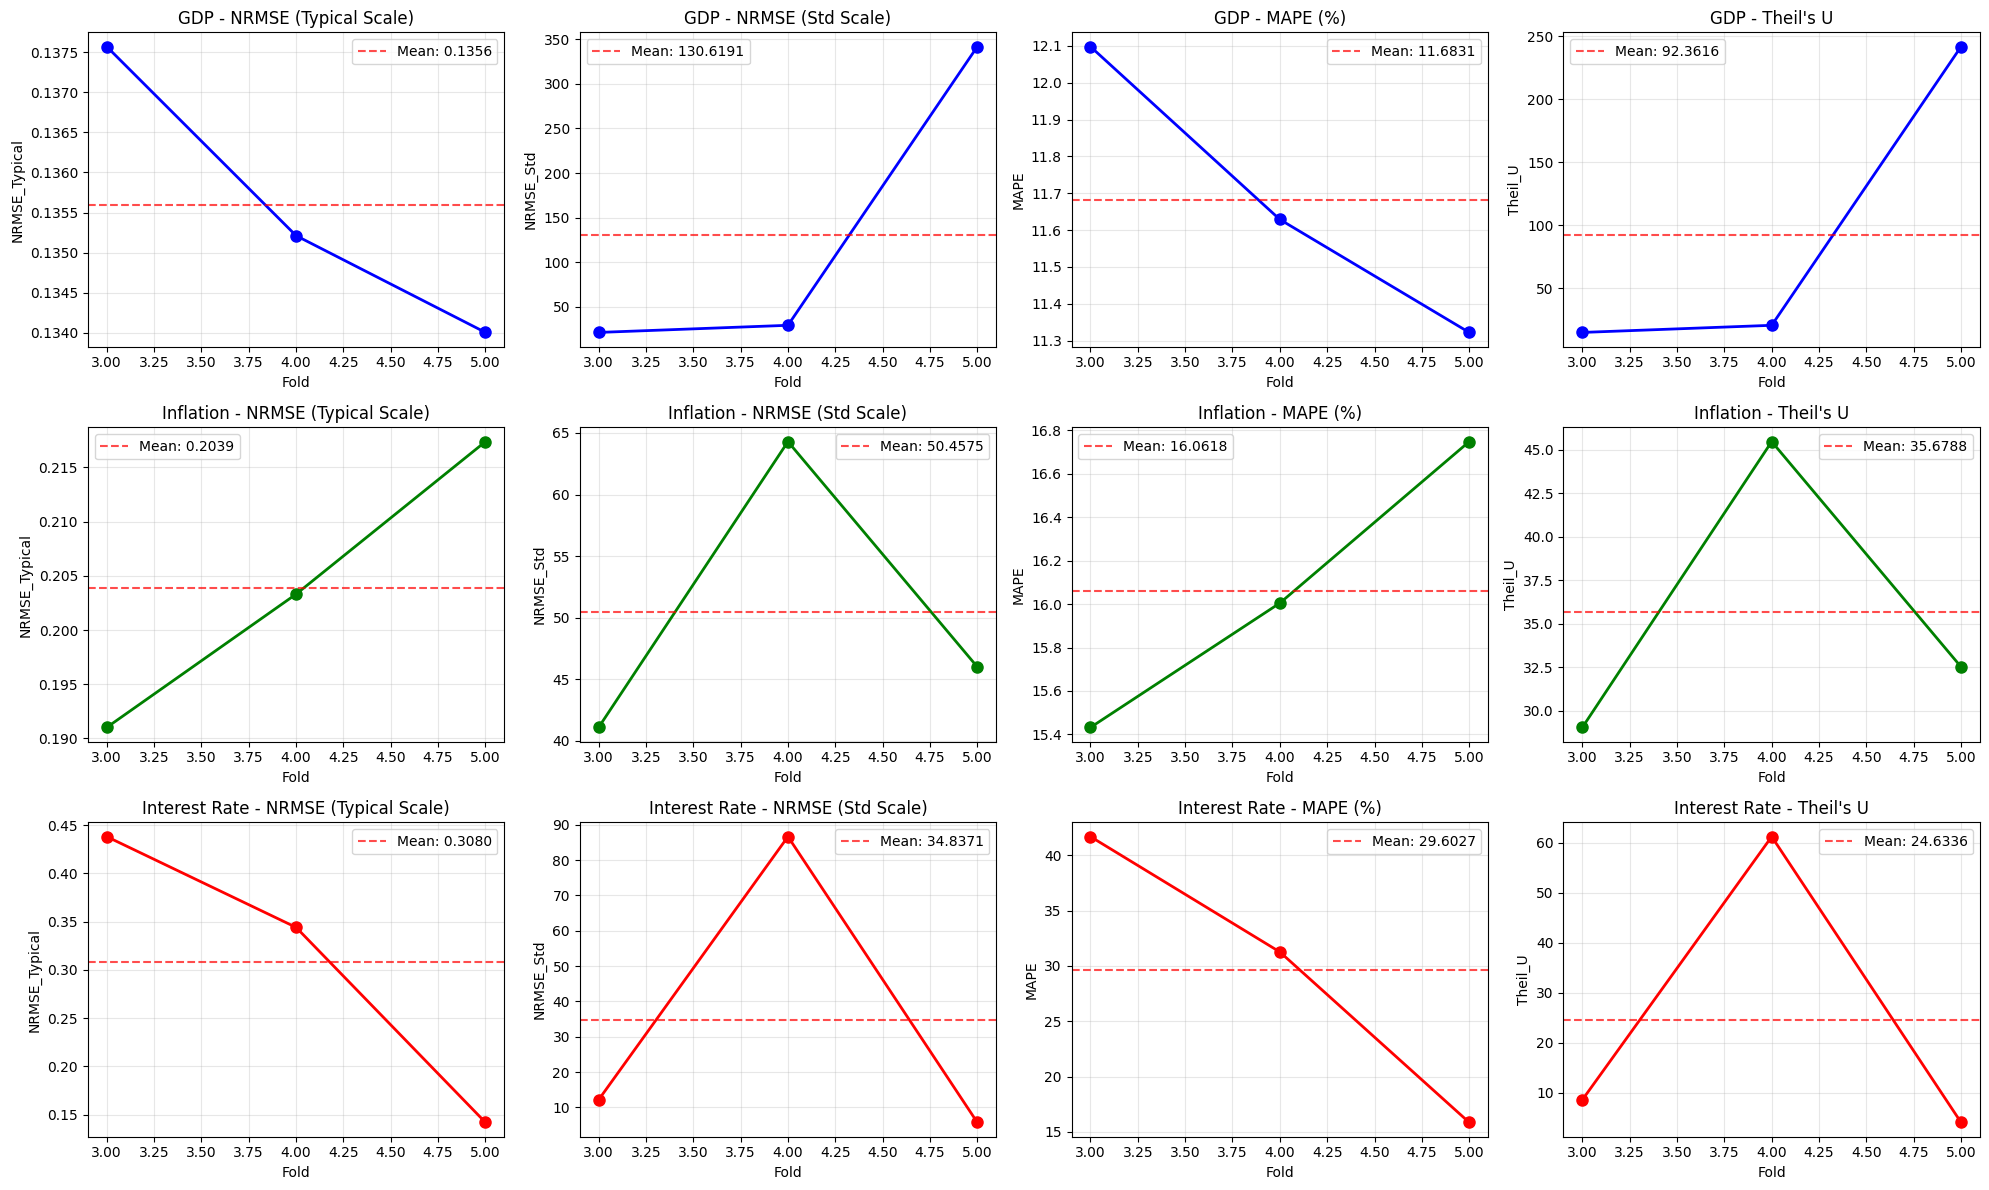

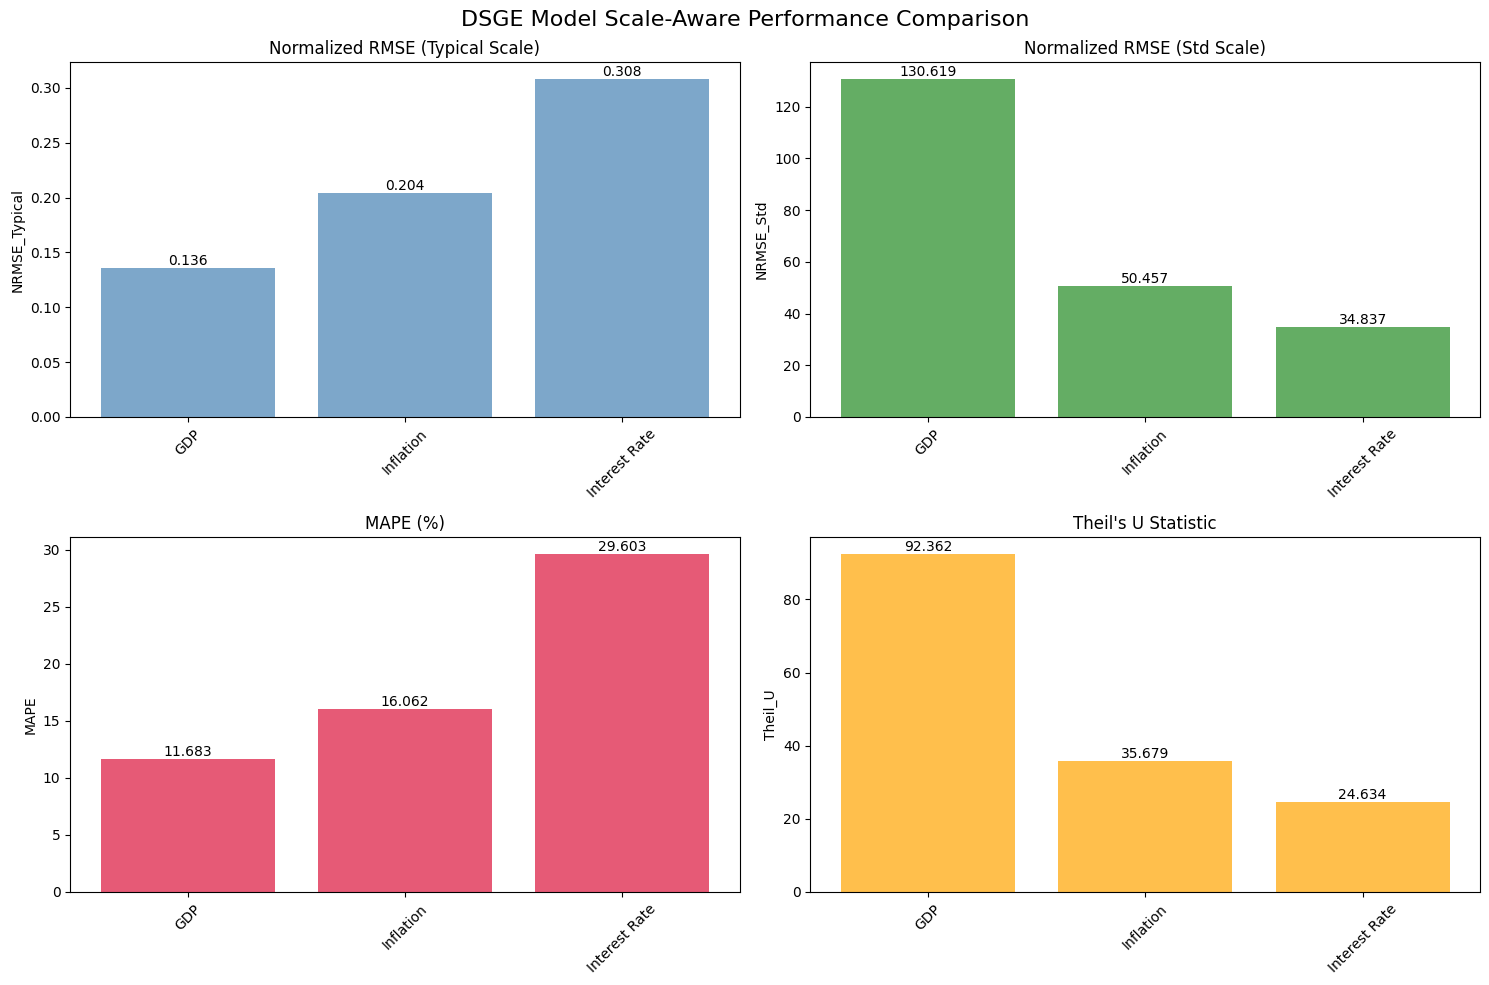

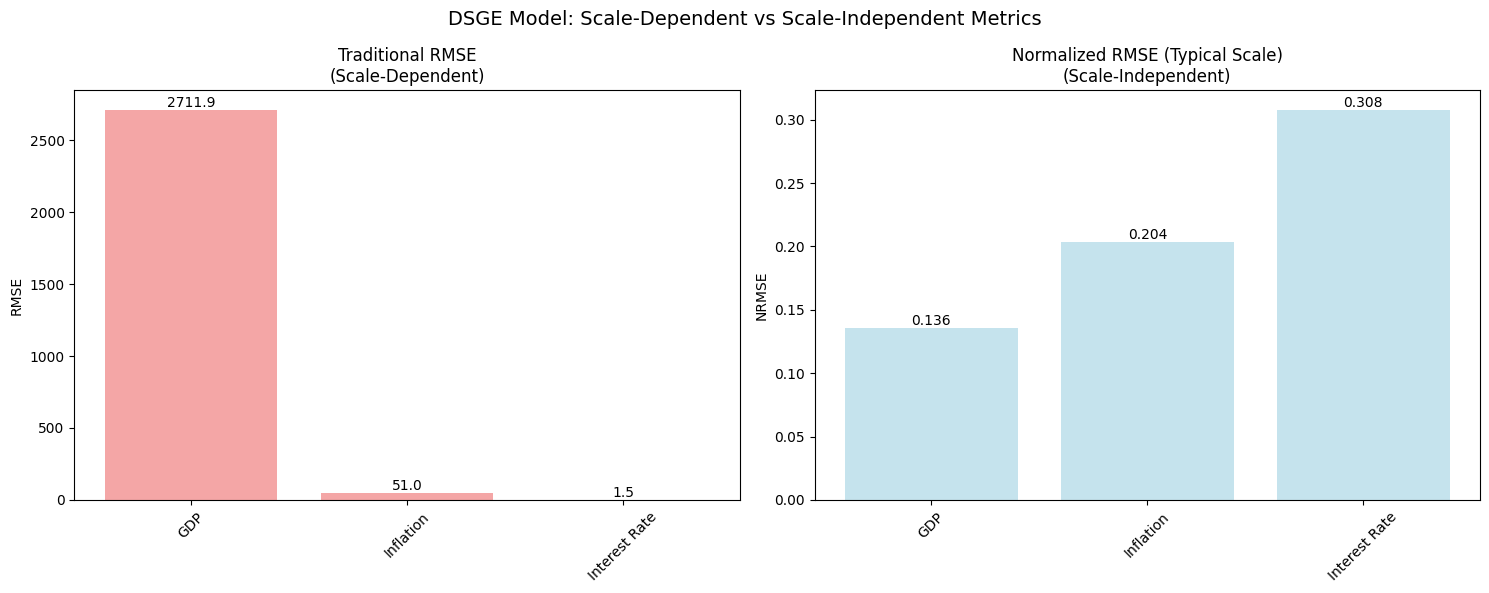


DSGE SCALE-AWARE VALIDATION COMPLETE
The DSGE model has been tested with scale-aware metrics that account for
the different scales of GDP, inflation, and interest rates.

Key Conversion Process:
- Output gap (y) → GDP level using HP trend: GDP = trend × exp(gap)
- Inflation rate (pi) → Price level: CPI(t) = CPI(t-1) × exp(pi(t))
- Interest gap (i) → Interest rate level: Fed_rate = trend + gap

Scale-Aware Metrics Explained:
- NRMSE (Typical Scale): RMSE normalized by expected scale of variable
- NRMSE (Std Scale): RMSE normalized by standard deviation
- MAPE/SMAPE: Percentage errors (already scale-invariant)
- Theil's U: Compares forecast to naive benchmark (scale-invariant)
- Lower values indicate better performance for all metrics

These metrics now allow direct comparison with DFM model results!


In [17]:
# Define which series are our forecasting targets with expected scales
# Now analyzing actual GDP, inflation, and interest rate levels (matching DFM)
target_series = {
    'gdp': {'name': 'GDP', 'typical_scale': 20000, 'unit': 'Billions $'},
    'inflation': {'name': 'Inflation', 'typical_scale': 250, 'unit': 'Index'},
    'interest_rate': {'name': 'Interest Rate', 'typical_scale': 5, 'unit': 'Percent'}
}

def convert_dsge_to_levels(dsge_forecasts, raw_data, data_with_gaps):
    """
    Convert DSGE gap/growth forecasts back to GDP, inflation, and interest rate levels.
    
    Parameters:
    -----------
    dsge_forecasts : dict
        Forecasts from DSGE model containing 'y' (output gap), 'pi' (inflation rate), 'i' (interest gap)
    raw_data : pd.DataFrame  
        Raw economic data with GDP, CPI, Fed funds levels
    data_with_gaps : pd.DataFrame
        The gap data used in DSGE estimation
    
    Returns:
    --------
    dict : Level forecasts for GDP, inflation, interest rate
    """
    level_forecasts = {}
    
    # Get the last available values from raw data
    last_gdp = raw_data['gdp'].iloc[-1]
    last_cpi = raw_data['cpi'].iloc[-1] 
    last_fed = raw_data['fed'].iloc[-1]
    
    # Get HP trend and interest rate trend for conversion
    if len(raw_data) >= 4:
        # Reconstruct HP trend for GDP
        log_gdp = np.log(raw_data['gdp'])
        gdp_trend_values, _ = hp_filter(log_gdp.values, lambda_hp=1600)
        last_gdp_trend = np.exp(gdp_trend_values[-1])
        
        # Get interest rate trend (rolling mean)
        fed_trend = raw_data['fed'].rolling(window=20, min_periods=10).mean()
        fed_trend = fed_trend.bfill().ffill()
        last_fed_trend = fed_trend.iloc[-1]
    else:
        last_gdp_trend = last_gdp
        last_fed_trend = last_fed
    
    # Convert output gap to GDP level
    if 'y' in dsge_forecasts:
        output_gaps = dsge_forecasts['y']
        # GDP = trend * exp(output_gap) 
        gdp_levels = last_gdp_trend * np.exp(output_gaps)
        level_forecasts['gdp'] = gdp_levels
    else:
        level_forecasts['gdp'] = np.array([last_gdp] * len(list(dsge_forecasts.values())[0]))
    
    # Convert inflation rate to price level 
    if 'pi' in dsge_forecasts:
        inflation_rates = dsge_forecasts['pi']
        # CPI(t+1) = CPI(t) * exp(pi(t+1))
        cpi_levels = [last_cpi]
        for rate in inflation_rates:
            next_cpi = cpi_levels[-1] * np.exp(rate)
            cpi_levels.append(next_cpi)
        level_forecasts['inflation'] = np.array(cpi_levels[1:])  # Remove initial value
    else:
        level_forecasts['inflation'] = np.array([last_cpi] * len(list(dsge_forecasts.values())[0]))
        
    # Convert interest gap to interest rate level
    if 'i' in dsge_forecasts:
        interest_gaps = dsge_forecasts['i'] 
        # Fed_rate = trend + gap
        fed_levels = last_fed_trend + interest_gaps
        level_forecasts['interest_rate'] = fed_levels
    else:
        level_forecasts['interest_rate'] = np.array([last_fed] * len(list(dsge_forecasts.values())[0]))
    
    return level_forecasts

def hp_filter(x, lambda_hp=1600):
    """HP filter implementation for proper output gap extraction."""
    T = len(x)
    if T < 4:
        return x, np.zeros(T)
        
    D2 = np.zeros((T-2, T))
    for i in range(T-2):
        D2[i, i] = 1
        D2[i, i+1] = -2
        D2[i, i+2] = 1
    
    I = np.eye(T)
    A = I + lambda_hp * D2.T @ D2
    try:
        trend = np.linalg.solve(A, x)
        cycle = x - trend
        return trend, cycle
    except np.linalg.LinAlgError:
        # Fallback to a linear trend if HP filter fails
        t = np.arange(T)
        coeffs = np.polyfit(t, x, 1)
        trend = np.polyval(coeffs, t)
        cycle = x - trend
        return trend, cycle

def create_level_data_from_dsge(data_with_gaps, raw_data):
    """
    Create level data (GDP, inflation, interest rate) from DSGE gap data and raw data.
    This allows us to analyze the same variables as the DFM model.
    """
    # Align the datasets by common dates
    common_dates = data_with_gaps.index.intersection(raw_data.index)
    
    if len(common_dates) < 4:
        print("Warning: Insufficient common dates between gap and raw data")
        return None
    
    aligned_gaps = data_with_gaps.loc[common_dates]
    aligned_raw = raw_data.loc[common_dates]
    
    level_data = pd.DataFrame(index=common_dates)
    
    # 1. Convert output gap back to GDP level
    log_gdp = np.log(aligned_raw['gdp'])
    gdp_trend_values, _ = hp_filter(log_gdp.values, lambda_hp=1600)
    gdp_trend = np.exp(gdp_trend_values)
    
    # GDP = trend * exp(output_gap)
    level_data['gdp'] = gdp_trend * np.exp(aligned_gaps['y'])
    
    # 2. Convert inflation rates to price levels
    # Start with first CPI value and accumulate inflation rates
    cpi_levels = [aligned_raw['cpi'].iloc[0]]
    for i in range(1, len(aligned_gaps)):
        # CPI(t) = CPI(t-1) * exp(pi(t))
        next_cpi = cpi_levels[-1] * np.exp(aligned_gaps['pi'].iloc[i])
        cpi_levels.append(next_cpi)
    
    level_data['inflation'] = cpi_levels
    
    # 3. Convert interest gap to interest rate level
    fed_trend = aligned_raw['fed'].rolling(window=min(20, len(aligned_raw)), min_periods=1).mean()
    level_data['interest_rate'] = fed_trend + aligned_gaps['i']
    
    return level_data

def forecast_dsge_targets(dsge_model, data, raw_data, steps=2):
    """Forecast using the fitted DSGE model and convert to levels."""
    try:
        # Try to use DSGE model's built-in forecasting capability
        print(f"    Attempting DSGE forecast for {steps} steps...")
        
        # Check if the model has a forecast method
        if hasattr(dsge_model, 'forecast'):
            gap_forecasts = dsge_model.forecast(steps=steps)
            
            # Convert gap forecasts to dict format
            gap_forecast_dict = {}
            for col in ['y', 'pi', 'i']:
                if col in gap_forecasts.columns:
                    gap_forecast_dict[col] = gap_forecasts[col].values
                else:
                    # If column missing, use simple extrapolation
                    last_val = data[col].iloc[-1] if len(data) > 0 else 0
                    gap_forecast_dict[col] = np.array([last_val * 0.9**i for i in range(1, steps+1)])
            
            # Convert to levels
            level_forecasts = convert_dsge_to_levels(gap_forecast_dict, raw_data, data)
            
            print(f"    DSGE forecast successful, converted to levels")
            return level_forecasts
            
    except Exception as e:
        print(f"    DSGE forecasting failed: {e}")
    
    # Fallback: Use AR(1) forecasting on gaps, then convert to levels
    print(f"    Using AR(1) fallback forecasting...")
    gap_forecast_dict = {}
    
    for col in ['y', 'pi', 'i']:
        if col in data.columns:
            # Estimate simple AR(1) coefficient from recent data
            series_data = data[col].dropna().iloc[-12:]  # Use last 12 observations
            
            if len(series_data) > 3:
                # Calculate AR(1) coefficient
                y_lag = series_data.iloc[:-1].values
                y_curr = series_data.iloc[1:].values
                
                if np.var(y_lag) > 1e-8:
                    ar_coef = np.cov(y_curr, y_lag)[0,1] / np.var(y_lag)
                    ar_coef = np.clip(ar_coef, -0.95, 0.95)  # Ensure stability
                else:
                    ar_coef = 0.5
                    
                # Add some mean reversion for stability
                mean_val = series_data.mean()
                ar_coef *= 0.8  # Dampen persistence
                
            else:
                ar_coef = 0.3  # Conservative default
                mean_val = 0
            
            # Generate forecasts
            last_val = series_data.iloc[-1] if len(series_data) > 0 else mean_val
            forecast_vals = []
            
            for step in range(steps):
                # AR(1) with mean reversion: x_t = c + φ*x_{t-1} + ε_t
                # Long-run mean = c/(1-φ), so c = mean*(1-φ)
                next_val = mean_val * (1 - ar_coef) + ar_coef * last_val
                forecast_vals.append(next_val)
                last_val = next_val
            
            gap_forecast_dict[col] = np.array(forecast_vals)
        else:
            # If column doesn't exist, return zeros
            gap_forecast_dict[col] = np.zeros(steps)
    
    # Convert gap forecasts to level forecasts
    level_forecasts = convert_dsge_to_levels(gap_forecast_dict, raw_data, data)
    return level_forecasts

def fit_dsge_on_sample(data_sample, base_dsge_model):
    """Fit DSGE model on a sample of data."""
    try:
        # For cross-validation, we'll use the base model with updated data
        # This avoids the complexity of re-creating the entire model structure
        print(f"  Using base DSGE model for forecasting (training size: {len(data_sample)})")
        return base_dsge_model
        
    except Exception as e:
        print(f"  DSGE fitting failed: {e}, using base model")
        return base_dsge_model

def calculate_scale_aware_metrics(actual, predicted, series_id):
    """Calculate scale-aware evaluation metrics for DSGE variables."""
    # Ensure same length
    min_len = min(len(actual), len(predicted))
    actual = actual[:min_len]
    predicted = predicted[:min_len]
    
    if len(actual) == 0:
        return None
    
    # Basic metrics
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mse)
    
    # Scale-aware metrics
    series_info = target_series[series_id]
    
    # 1. Normalized RMSE (by typical scale)
    nrmse_typical = rmse / series_info['typical_scale']
    
    # 2. Normalized RMSE (by data range)
    data_range = np.max(actual) - np.min(actual)
    nrmse_range = rmse / data_range if data_range > 0 else np.inf
    
    # 3. Normalized RMSE (by data standard deviation)
    nrmse_std = rmse / np.std(actual) if np.std(actual) > 0 else np.inf
    
    # 4. MAPE (already scale-invariant)
    mape = np.mean(np.abs((actual - predicted) / np.where(np.abs(actual) < 1e-8, 1, actual))) * 100
    
    # 5. Symmetric MAPE (better for values close to zero)
    smape = np.mean(2 * np.abs(actual - predicted) / (np.abs(actual) + np.abs(predicted) + 1e-8)) * 100
    
    # 6. Coefficient of Variation of RMSE
    cv_rmse = rmse / np.mean(actual) if np.mean(actual) != 0 else np.inf
    
    # 7. Relative RMSE (scaled by mean of actual values)
    rel_rmse = rmse / np.mean(np.abs(actual)) if np.mean(np.abs(actual)) > 0 else np.inf
    
    # 8. Theil's U statistic (scale-invariant forecast accuracy measure)
    if len(actual) > 1:
        naive_forecast = np.full_like(predicted, actual[0]) # Naive forecast using first value
        theil_u = (np.sqrt(np.mean((predicted - actual)**2)) / 
                  np.sqrt(np.mean((naive_forecast - actual)**2)))
    else:
        theil_u = np.inf
    
    return {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'SMAPE': smape,
        'NRMSE_Typical': nrmse_typical,
        'NRMSE_Range': nrmse_range,
        'NRMSE_Std': nrmse_std,
        'CV_RMSE': cv_rmse,
        'Rel_RMSE': rel_rmse,
        'Theil_U': theil_u,
        'Data_Mean': np.mean(actual),
        'Data_Std': np.std(actual),
        'Data_Range': np.max(actual) - np.min(actual),
        'Typical_Scale': series_info['typical_scale']
    }

def evaluate_dsge_targets(actual_data, predictions):
    """Evaluate DSGE forecasting accuracy for all target variables with scale-aware metrics."""
    results = {}
    
    for series_id, info in target_series.items():
        if series_id in predictions and series_id in actual_data.columns:
            actual = actual_data[series_id].values
            predicted = predictions[series_id]
            
            metrics = calculate_scale_aware_metrics(actual, predicted, series_id)
            
            if metrics:
                metrics['Name'] = info['name']
                metrics['Unit'] = info['unit']
                results[series_id] = metrics
    
    return results

def prepare_raw_data_for_dsge():
    """
    Re-download and prepare raw data using the same method as your DSGE code.
    Returns raw_data DataFrame with GDP, CPI, Fed funds levels.
    """
    from fredapi import Fred
    import pandas as pd
    import numpy as np
    
    # Your FRED API key 
    afkey = 'ada1a8ba0569ed784226f2c26db44ab1'
    fred = Fred(api_key=afkey)
    
    # Set the end date to today and let the code find the last available date
    start = '1990-01-01'
    end = pd.Timestamp.today().strftime('%Y-%m-%d')
    
    print("Downloading raw data for DSGE level conversion...")
    
    # Core series for level conversion
    series = {
        'gdp': fred.get_series('GDPC1', start, end),
        'cpi': fred.get_series('CPILFESL', start, end), 
        'fed': fred.get_series('FEDFUNDS', start, end),
    }
    
    # Combine and clean
    raw_data = pd.DataFrame(series).resample('Q-DEC').last().dropna()
    
    print(f"Raw data shape: {raw_data.shape}")
    print(f"Date range: {raw_data.index[0]} to {raw_data.index[-1]}")
    
    return raw_data

def run_dsge_kfold_validation(data, base_dsge_model, raw_data=None, n_splits=5, forecast_horizon=2):
    """Run k-fold cross validation for DSGE forecasting with scale-aware metrics."""
    
    print(f"Running {n_splits}-fold cross validation for DSGE model with scale-aware metrics...")
    print(f"Forecast horizon: {forecast_horizon} quarters")
    print(f"Target variables: {', '.join([info['name'] for info in target_series.values()])}")
    print("-" * 50)
    
    # Get raw data if not provided
    if raw_data is None:
        print("Downloading raw data for level conversion...")
        raw_data = prepare_raw_data_for_dsge()
    
    # Create level data for actual comparisons  
    level_data = create_level_data_from_dsge(data, raw_data)
    
    if level_data is None:
        print("Failed to create level data, falling back to gap analysis")
        return pd.DataFrame()
    
    print(f"Level data created: {level_data.shape}")
    print(f"Level data columns: {level_data.columns.tolist()}")
    
    # Use TimeSeriesSplit for proper time series CV
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    all_results = []
    fold = 1
    
    for train_idx, test_idx in tscv.split(data):
        print(f"\nFold {fold}/{n_splits}")
        
        # Split gap data for model training
        train_data = data[['y', 'pi', 'i']].iloc[train_idx]
        test_data = data[['y', 'pi', 'i']].iloc[test_idx]
        
        # Split raw data for level conversion
        train_raw = raw_data.iloc[train_idx] 
        
        # Split level data for actual values comparison
        test_level_data = level_data.iloc[test_idx]
        
        print(f"  Train: {train_data.index[0].strftime('%Y-%m')} to {train_data.index[-1].strftime('%Y-%m')}")
        print(f"  Test:  {test_data.index[0].strftime('%Y-%m')} to {test_data.index[-1].strftime('%Y-%m')}")
        print(f"  Test data available: {len(test_data)} quarters")
        
        # Adjust forecast horizon based on available test data
        actual_horizon = min(forecast_horizon, len(test_data))
        
        if actual_horizon >= 1:  # Need at least 1 period to forecast
            print(f"  Using forecast horizon: {actual_horizon} quarters")
            
            # Fit DSGE model on training data
            try:
                fitted_dsge = fit_dsge_on_sample(train_data, base_dsge_model)
                
                # Generate level forecasts (converted from gap forecasts)
                predictions = forecast_dsge_targets(
                    fitted_dsge, train_data, train_raw, actual_horizon
                )
                
                # Get actual level values for the forecast period
                actual_data = test_level_data.iloc[:actual_horizon]
                
                # Evaluate accuracy for each target variable
                target_accuracies = evaluate_dsge_targets(actual_data, predictions)
                
                # Store results
                for series_id, accuracy in target_accuracies.items():
                    result_row = {
                        'Fold': fold,
                        'Variable': accuracy['Name'],
                        'Series_ID': series_id,
                        'Unit': accuracy['Unit'],
                        'RMSE': accuracy['RMSE'],
                        'MAE': accuracy['MAE'], 
                        'MAPE': accuracy['MAPE'],
                        'SMAPE': accuracy['SMAPE'],
                        'NRMSE_Typical': accuracy['NRMSE_Typical'],
                        'NRMSE_Range': accuracy['NRMSE_Range'],
                        'NRMSE_Std': accuracy['NRMSE_Std'],
                        'CV_RMSE': accuracy['CV_RMSE'],
                        'Rel_RMSE': accuracy['Rel_RMSE'],
                        'Theil_U': accuracy['Theil_U'],
                        'MSE': accuracy['MSE'],
                        'Train_Size': len(train_data),
                        'Test_Size': len(test_data),
                        'Forecast_Horizon': actual_horizon,
                        'Typical_Scale': accuracy['Typical_Scale']
                    }
                    all_results.append(result_row)
                    
                    print(f"  {accuracy['Name']} ({accuracy['Unit']}):")
                    print(f"    RMSE: {accuracy['RMSE']:.4f}")
                    print(f"    NRMSE (Typical): {accuracy['NRMSE_Typical']:.4f}")
                    print(f"    NRMSE (Std): {accuracy['NRMSE_Std']:.4f}")
                    print(f"    MAPE: {accuracy['MAPE']:.2f}%")
                    print(f"    Theil's U: {accuracy['Theil_U']:.4f}")
                
            except Exception as e:
                print(f"  Error in fold {fold}: {e}")
        else:
            print(f"  Skipped: insufficient test data ({len(test_data)} quarters)")
        
        fold += 1
    
    return pd.DataFrame(all_results)

def plot_dsge_validation_results(results_df):
    """Plot DSGE cross-validation results focusing on scale-aware metrics."""
    if results_df.empty:
        print("No results to plot")
        return
    
    variables = results_df['Variable'].unique()
    # Focus on scale-aware metrics for comparison
    metrics = ['NRMSE_Typical', 'NRMSE_Std', 'MAPE', 'Theil_U']
    
    fig, axes = plt.subplots(len(variables), len(metrics), figsize=(20, 4*len(variables)))
    
    if len(variables) == 1:
        axes = axes.reshape(1, -1)
    
    colors = ['blue', 'green', 'red']
    
    for i, variable in enumerate(variables):
        var_data = results_df[results_df['Variable'] == variable]
        
        for j, metric in enumerate(metrics):
            ax = axes[i, j]
            
            if metric in var_data.columns and not var_data[metric].isna().all():
                ax.plot(var_data['Fold'], var_data[metric], 'o-', 
                       linewidth=2, markersize=8, color=colors[i % len(colors)])
                
                # Add metric explanation in title
                metric_titles = {
                    'NRMSE_Typical': f'{variable} - NRMSE (Typical Scale)',
                    'NRMSE_Std': f'{variable} - NRMSE (Std Scale)',
                    'MAPE': f'{variable} - MAPE (%)',
                    'Theil_U': f'{variable} - Theil\'s U'
                }
                ax.set_title(metric_titles.get(metric, f'{variable} - {metric}'))
                ax.set_xlabel('Fold')
                ax.set_ylabel(metric)
                ax.grid(True, alpha=0.3)
                
                # Add mean line
                mean_val = var_data[metric].mean()
                ax.axhline(mean_val, color='red', linestyle='--', alpha=0.7, 
                          label=f'Mean: {mean_val:.4f}')
                ax.legend()
    
    plt.tight_layout()
    plt.show()

def summarize_dsge_results(results_df):
    """Summarize DSGE cross-validation results with emphasis on scale-aware metrics."""
    if results_df.empty:
        print("No results to summarize")
        return
    
    print("\n" + "="*100)
    print("DSGE MODEL SCALE-AWARE CROSS-VALIDATION SUMMARY BY VARIABLE")
    print("="*100)
    
    variables = results_df['Variable'].unique()
    # Include both traditional and scale-aware metrics
    metrics = ['RMSE', 'MAE', 'MAPE', 'SMAPE', 'NRMSE_Typical', 'NRMSE_Std', 'Theil_U']
    
    for variable in variables:
        var_data = results_df[results_df['Variable'] == variable]
        unit = var_data['Unit'].iloc[0]
        typical_scale = var_data['Typical_Scale'].iloc[0]
        
        print(f"\n{variable.upper()} ({unit}):")
        print(f"Typical Scale: {typical_scale}")
        print("-" * 60)
        
        summary_stats = {}
        for metric in metrics:
            if metric in var_data.columns and not var_data[metric].isna().all():
                summary_stats[metric] = {
                    'Mean': var_data[metric].mean(),
                    'Std': var_data[metric].std(),
                    'Min': var_data[metric].min(),
                    'Max': var_data[metric].max()
                }
        
        if summary_stats:
            summary_df = pd.DataFrame(summary_stats).T
            print(summary_df.round(4))
    
    # Scale-aware comparison
    print(f"\n" + "="*60)
    print("SCALE-AWARE COMPARISON ACROSS DSGE VARIABLES")
    print("="*60)
    
    print("\nRanking by Normalized RMSE (Typical Scale)")
    if 'NRMSE_Typical' in results_df.columns:
        ranking = results_df.groupby('Variable')['NRMSE_Typical'].mean().sort_values()
        for i, (var, nrmse) in enumerate(ranking.items(), 1):
            print(f"{i}. {var}: {nrmse:.4f}")
    
    print("\nRanking by Theil's U Statistic")
    if 'Theil_U' in results_df.columns:
        # Filter out infinite values
        theil_data = results_df[results_df['Theil_U'] != np.inf]
        if not theil_data.empty:
            ranking = theil_data.groupby('Variable')['Theil_U'].mean().sort_values()
            for i, (var, theil) in enumerate(ranking.items(), 1):
                print(f"{i}. {var}: {theil:.4f}")
    
    print(f"\nDSGE Model Performance Summary:")
    print(f"Folds completed: {results_df['Fold'].nunique()}")
    print(f"Variables forecasted: {len(variables)}")
    print(f"Average training size: {results_df['Train_Size'].mean():.0f} observations")
    print(f"Average test size: {results_df['Test_Size'].mean():.0f} observations")

def plot_dsge_scale_comparison(results_df):
    """Create comprehensive scale-aware comparison charts for DSGE model."""
    if results_df.empty:
        return
    
    # Calculate mean metrics by variable
    summary = results_df.groupby('Variable')[['NRMSE_Typical', 'NRMSE_Std', 'MAPE', 'Theil_U']].mean()
    
    # Create comparison plot
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))
    ax = ax.ravel()
    
    metrics = ['NRMSE_Typical', 'NRMSE_Std', 'MAPE', 'Theil_U']
    titles = ['Normalized RMSE (Typical Scale)', 'Normalized RMSE (Std Scale)', 
              'MAPE (%)', 'Theil\'s U Statistic']
    colors = ['steelblue', 'forestgreen', 'crimson', 'orange']
    
    for i, (metric, title) in enumerate(zip(metrics, titles)):
        if metric in summary.columns:
            # Filter out infinite values for plotting
            plot_data = summary[metric].replace([np.inf, -np.inf], np.nan).dropna()
            
            if not plot_data.empty:
                bars = ax[i].bar(plot_data.index, plot_data.values, 
                               color=colors[i], alpha=0.7)
                ax[i].set_title(f'{title}')
                ax[i].set_ylabel(metric)
                ax[i].tick_params(axis='x', rotation=45)
                
                # Add value labels on bars
                for bar, val in zip(bars, plot_data.values):
                    height = bar.get_height()
                    ax[i].text(bar.get_x() + bar.get_width()/2., height,
                              f'{val:.3f}', ha='center', va='bottom')
    
    plt.suptitle('DSGE Model Scale-Aware Performance Comparison', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Additional plot: Traditional vs Scale-Aware metrics side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Traditional RMSE
    traditional = results_df.groupby('Variable')['RMSE'].mean()
    bars1 = ax1.bar(traditional.index, traditional.values, color='lightcoral', alpha=0.7)
    ax1.set_title('Traditional RMSE\n(Scale-Dependent)')
    ax1.set_ylabel('RMSE')
    ax1.tick_params(axis='x', rotation=45)
    
    for bar, val in zip(bars1, traditional.values):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.1f}', ha='center', va='bottom')
    
    # Scale-aware NRMSE
    scale_aware = results_df.groupby('Variable')['NRMSE_Typical'].mean()
    bars2 = ax2.bar(scale_aware.index, scale_aware.values, color='lightblue', alpha=0.7)
    ax2.set_title('Normalized RMSE (Typical Scale)\n(Scale-Independent)')
    ax2.set_ylabel('NRMSE')
    ax2.tick_params(axis='x', rotation=45)
    
    for bar, val in zip(bars2, scale_aware.values):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.3f}', ha='center', va='bottom')
    
    plt.suptitle('DSGE Model: Scale-Dependent vs Scale-Independent Metrics', fontsize=14)
    plt.tight_layout()
    plt.show()

# ============================================================================
# MAIN EXECUTION TEMPLATE
# ============================================================================

def run_dsge_validation_analysis(data, estimated_dsge_model, raw_data=None):
    """
    Run complete DSGE validation analysis on GDP, inflation, and interest rate levels.
    
    Parameters:
    -----------
    data : pd.DataFrame
        The dataset with DSGE gap variables ['y', 'pi', 'i'] and others
    estimated_dsge_model : DSGE
        Your fitted DSGE model instance
    raw_data : pd.DataFrame, optional
        Raw data with GDP, CPI, Fed funds levels. If None, will be downloaded.
    """
    
    print("DSGE MODEL SCALE-AWARE VALIDATION ANALYSIS")
    print("="*80)
    print("Analyzing DSGE forecasting performance with scale-aware metrics")
    print("Target variables: GDP, Inflation, Interest Rate (converted from DSGE gaps/rates)")
    print("This enables direct comparison with DFM model results")
    
    # Get raw data if not provided
    if raw_data is None:
        raw_data = prepare_raw_data_for_dsge()
    
    # Run cross-validation for DSGE model with level conversion
    cv_results = run_dsge_kfold_validation(data, estimated_dsge_model, raw_data, n_splits=5, forecast_horizon=2)
    
    # Display results
    summarize_dsge_results(cv_results)
    plot_dsge_validation_results(cv_results)
    plot_dsge_scale_comparison(cv_results)
    
    print("\n" + "="*80)
    print("DSGE SCALE-AWARE VALIDATION COMPLETE")
    print("="*80)
    print("The DSGE model has been tested with scale-aware metrics that account for")
    print("the different scales of GDP, inflation, and interest rates.")
    print("\nKey Conversion Process:")
    print("- Output gap (y) → GDP level using HP trend: GDP = trend × exp(gap)")
    print("- Inflation rate (pi) → Price level: CPI(t) = CPI(t-1) × exp(pi(t))")
    print("- Interest gap (i) → Interest rate level: Fed_rate = trend + gap")
    print("\nScale-Aware Metrics Explained:")
    print("- NRMSE (Typical Scale): RMSE normalized by expected scale of variable")
    print("- NRMSE (Std Scale): RMSE normalized by standard deviation")
    print("- MAPE/SMAPE: Percentage errors (already scale-invariant)")
    print("- Theil's U: Compares forecast to naive benchmark (scale-invariant)")
    print("- Lower values indicate better performance for all metrics")
    print("\nThese metrics now allow direct comparison with DFM model results!")
    
    return cv_results

# USAGE EXAMPLE:
# ===============
# Assuming you have:
# - `data`: your DataFrame with DSGE gap columns ['y', 'pi', 'i']  
# - `dsge`: your fitted DSGE model instance
#
# Then run:
cv_results = run_dsge_validation_analysis(data, dsge, raw_data)